# Day 2 
[![Author - DanRamirez](https://img.shields.io/badge/Author-DanRamirez-2ea44f?style=for-the-badge)](https://github.com/Dandata0101)
![Python - Version](https://img.shields.io/badge/PYTHON-3.11-red?style=for-the-badge&logo=python&logoColor=white)
[![Project Repo](https://img.shields.io/badge/Our_Project_Repo-Visit-blue?style=for-the-badge&logo=github&logoColor=white)](https://github.com/Dandata0101/mbs-fraud-detection)

I used LightGBM to explain Top impacting features to the **TARGET** variable for the training and Test Application Files. Before producing any analysis, I converted csv files in Parquet files to flatten and reduce the size of files by more than half.

##  flattening file sizes

In [27]:
# select at least 3 variables for this analysis

import os
import sys
from scripts.csvtopaquet import csv_to_parquet_single_file

current_directory = os.getcwd()
csv1_file_path = os.path.join(current_directory, '01-data', 'FD_02_apl_test.csv')
csv2_file_path = os.path.join(current_directory, '01-data', 'FD_02_apl_train.csv')
csv3_file_path = os.path.join(current_directory, '01-data', 'FD_02_previos_appl.csv')

output_file_path1 = os.path.join(current_directory, '01-data', 'FD_02_apl_test.parquet')
output_file_path2 = os.path.join(current_directory, '01-data', 'FD_02_apl_train.parquet')
output_file_path3 = os.path.join(current_directory, '01-data', 'FD_02_previos_appl.parquet')



csv_to_parquet_single_file(csv_file_path=csv1_file_path, output_file_path=output_file_path1, chunksize=100000, sample_rows=None, drop_columns=None)
csv_to_parquet_single_file(csv_file_path=csv2_file_path, output_file_path=output_file_path2, chunksize=100000, sample_rows=None, drop_columns=None)
csv_to_parquet_single_file(csv_file_path=csv3_file_path, output_file_path=output_file_path3, chunksize=100000, sample_rows=None, drop_columns=None)


Row count before sampling: 48744
Row count after sampling: 48744
Conversion completed. The data has been saved to '/Users/danramirez/mbs-fraud-detection/01-data/FD_02_apl_test.parquet'.
Row count before sampling: 307511
Row count after sampling: 307511
Conversion completed. The data has been saved to '/Users/danramirez/mbs-fraud-detection/01-data/FD_02_apl_train.parquet'.
Row count before sampling: 1670214
Row count after sampling: 1670214
Conversion completed. The data has been saved to '/Users/danramirez/mbs-fraud-detection/01-data/FD_02_previos_appl.parquet'.


# Import Parquet Files and assign DFs

In [28]:
import pandas as pd
import numpy as np
import sys,os

current_directory = os.getcwd()
parquetFile1 = os.path.join(current_directory, '01-data', 'FD_02_apl_test.parquet')
parquetFile2 = os.path.join(current_directory, '01-data', 'FD_02_apl_train.parquet')
parquetFile3 = os.path.join(current_directory, '01-data', 'FD_02_previos_appl.parquet')

df1 = pd.read_parquet(parquetFile1)
df1 = df1.fillna(0)
df1.columns = df1.columns.str.replace('[^a-zA-Z0-9_]', '_')
df1.columns = df1.columns.str.replace('/', '_')

print('test Data:')
print(df1.dtypes)
print('')

df2 = pd.read_parquet(parquetFile2)

df2 = df2.fillna(0)
df2.columns = df2.columns.str.replace('[^a-zA-Z0-9_]', '_')
df2.columns = df2.columns.str.replace('/', '_')

print('train Data:')
print(df2.dtypes)
print('')

df3 = pd.read_parquet(parquetFile3)
df3 = df3.fillna(0)
df3.columns = df3.columns.str.replace('[^a-zA-Z0-9_]', '_')
df3.columns = df3.columns.str.replace('/', '_')
print(df3.dtypes)
print('')
# Load the datasets
test  = df1
train = df2

current_data = pd.concat([test,train], axis=0)

print('Prior Data:')
print(df3.dtypes)
previous_data = df3
print('')

test Data:
SK_ID_CURR                      int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 121, dtype: object

train Data:
SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

SK_ID_PREV                       int64
SK_ID_CURR                       int64
NAME_CO

# Target Distribution

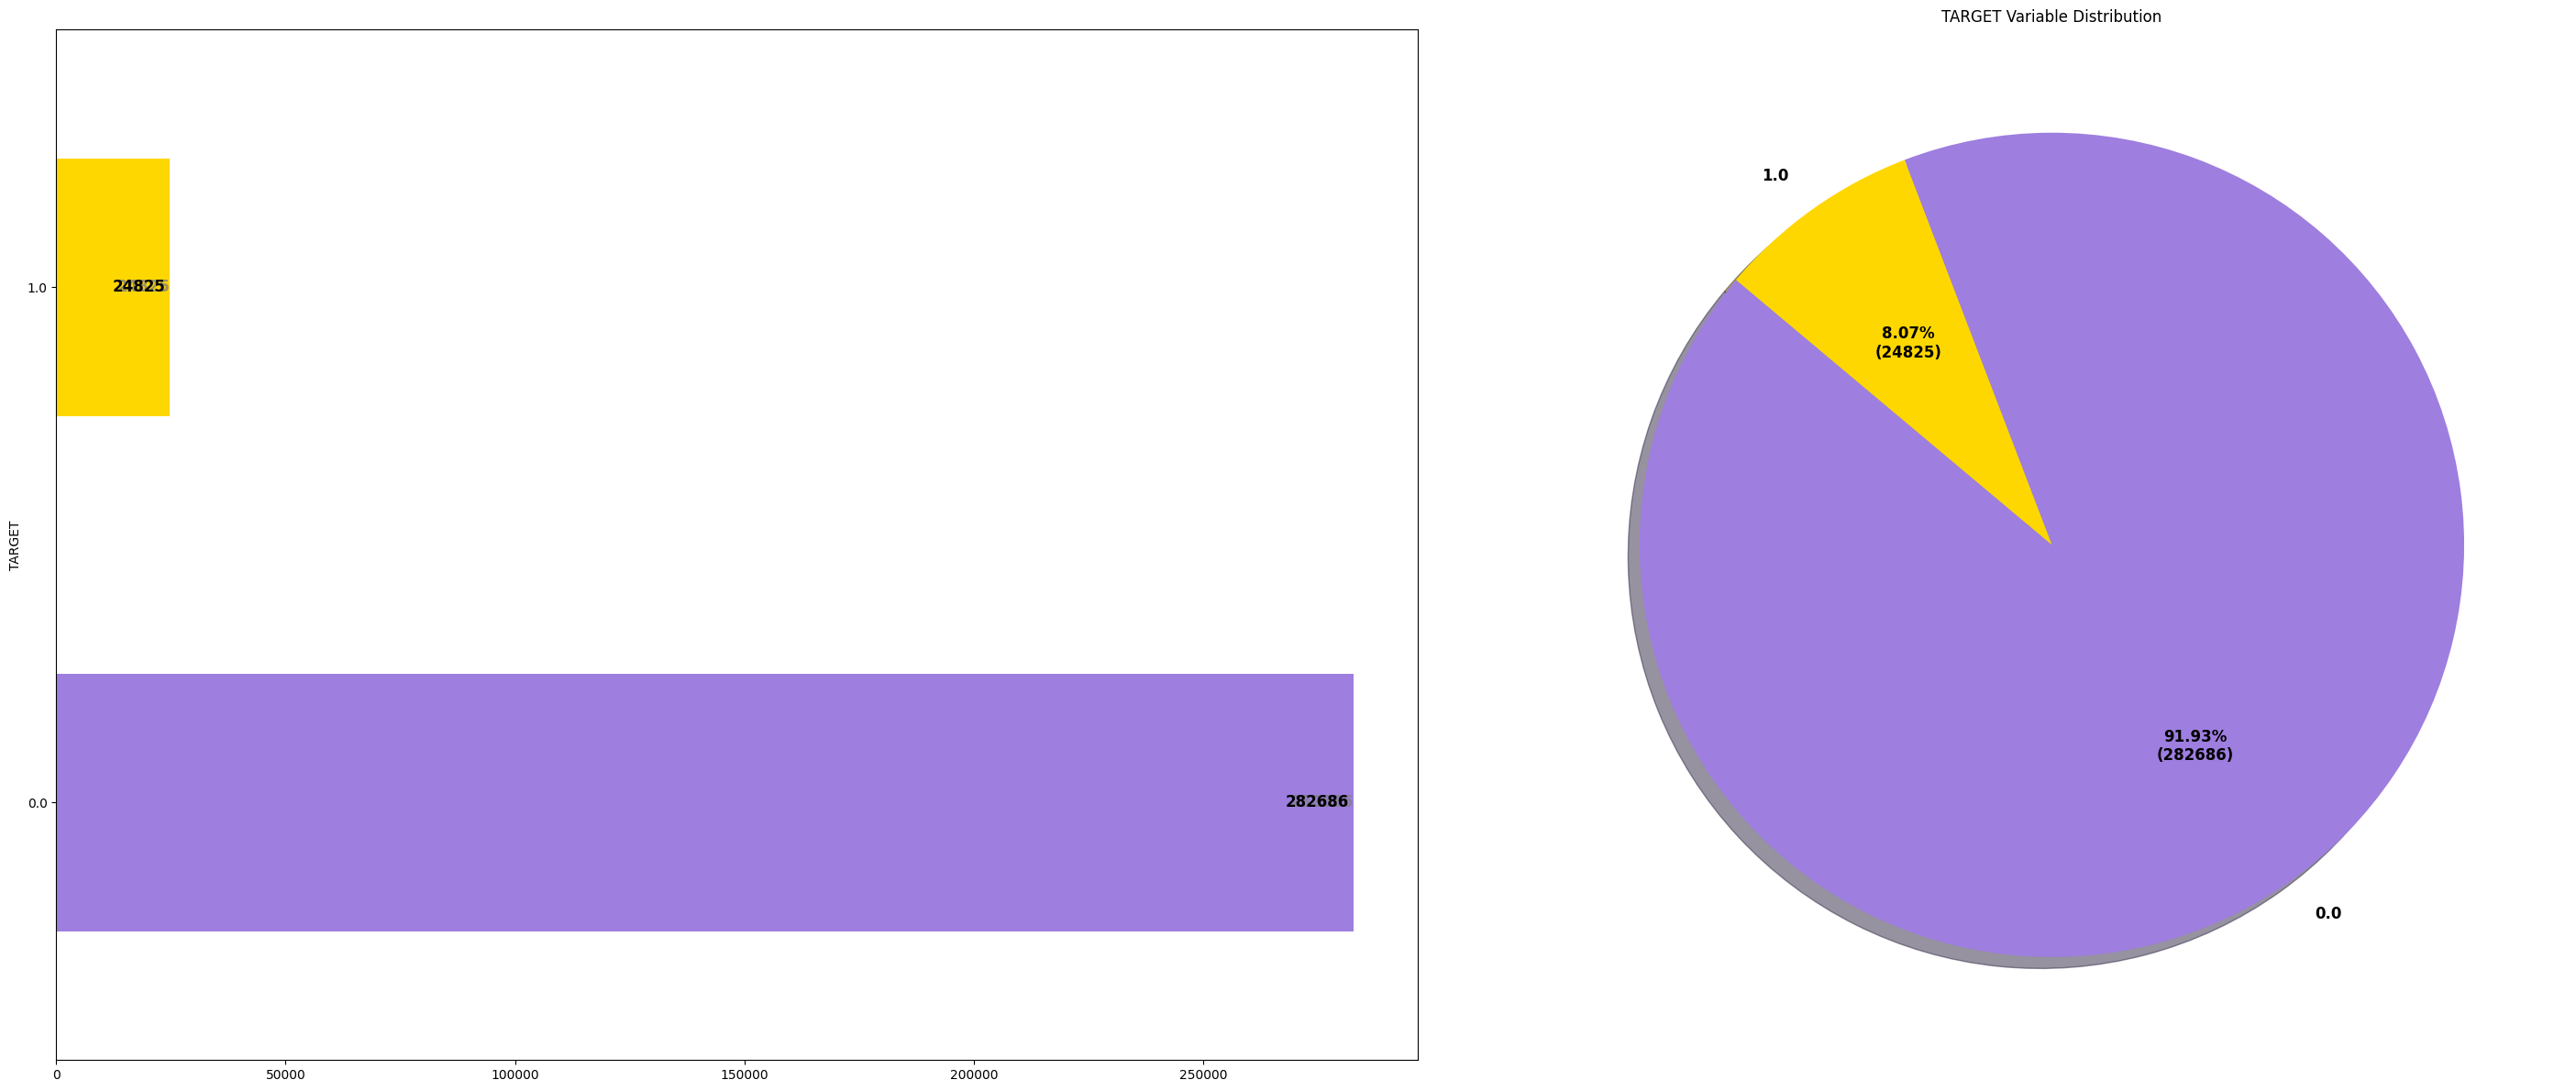

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Plotting setup
plt.figure(figsize=(30, 12))

# Horizontal Bar Chart for 'TARGET' value counts
plt.subplot(1, 2, 1)
target_counts = current_data['TARGET'].value_counts()
bars = target_counts.plot(kind='barh', color=['#9e7edf', '#FFD700'])
for index, value in enumerate(target_counts):
    # Shadow effect for text
    plt.text(value, index, str(value), va='center', ha='right', color='gray', fontsize=12, alpha=0.8, fontweight='bold')
    plt.text(value-1000, index, str(value), va='center', ha='right', color='black', fontsize=12, fontweight='bold')  # Actual text

# Pie Chart for 'TARGET' value counts
plt.subplot(1, 2, 2)
colors = ['#9e7edf', '#FFD700']
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_format

target_counts.plot(kind='pie', colors=colors, autopct=autopct_format(target_counts), startangle=140, shadow=True, textprops={'fontsize': 12, 'fontweight': 'bold'})

plt.ylabel('')  # Hide the 'TARGET' label on y-axis for the pie chart
plt.title('TARGET Variable Distribution')

plt.tight_layout()  # Adjust layout to not overlap subplots
plt.show()


# Filter by Column Types

In [30]:
import pandas as pd


# Then proceed with training your LightGBM model
dataset=current_data

print('dataset:',dataset['TARGET'].dtypes)
# Splitting the DataFrame into object and numeric DataFrames
current_data_object = dataset.select_dtypes(include=['object'])
Current_data_Numericonly = dataset.select_dtypes(include=['number'])  # This includes int, float, etc.
current_data_object.columns.tolist()
Current_data_Numericonly.columns.tolist()
columns_data = dataset.columns.values.tolist()
dummy_columns = pd.get_dummies(current_data_object, dtype=int)


merged_data = pd.concat([Current_data_Numericonly, dummy_columns], axis=1)
# Drop 'SK_ID_CURR' and columns with blank names
merged_data.drop(columns=['SK_ID_CURR'], inplace=True)
def clean_column_names(df):
    df.columns = [col.replace('{', '')
                     .replace('}', '')
                     .replace('[', '')
                     .replace(']', '')
                     .replace('"', '')
                     .replace(':', '')
                     .replace(',', '') for col in df.columns]
    return df

# Clean the column names of your DataFrame
merged_data = clean_column_names(merged_data)

print(merged_data.dtypes)

sample=merged_data.head(1)
print(merged_data.head(1).T)

merged_data.to_csv('testmerge.csv')

print(Current_data_Numericonly.dtypes)

# To see the columns of each DataFrame
print("Object Columns:", len(current_data_object.columns.tolist()))
print("Numeric Columns:", len(Current_data_Numericonly.columns.tolist()))

columns_data[(columns_data == 'current_data')]


dataset: float64
CNT_CHILDREN                        int64
AMT_INCOME_TOTAL                  float64
AMT_CREDIT                        float64
AMT_ANNUITY                       float64
AMT_GOODS_PRICE                   float64
                                   ...   
WALLSMATERIAL_MODE_Stone brick      int64
WALLSMATERIAL_MODE_Wooden           int64
EMERGENCYSTATE_MODE_0               int64
EMERGENCYSTATE_MODE_No              int64
EMERGENCYSTATE_MODE_Yes             int64
Length: 251, dtype: object
                                       0
CNT_CHILDREN                         0.0
AMT_INCOME_TOTAL                135000.0
AMT_CREDIT                      568800.0
AMT_ANNUITY                      20560.5
AMT_GOODS_PRICE                 450000.0
...                                  ...
WALLSMATERIAL_MODE_Stone brick       1.0
WALLSMATERIAL_MODE_Wooden            0.0
EMERGENCYSTATE_MODE_0                0.0
EMERGENCYSTATE_MODE_No               1.0
EMERGENCYSTATE_MODE_Yes              0.0

[

'SK_ID_CURR'

# Top Factors

In [31]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
merged_data
merged_data = merged_data.fillna(0)
# Assuming your DataFrame and target variable setup
X = merged_data.drop('TARGET', axis=1)
y = merged_data['TARGET']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Parameters
params = {
    'objective': 'binary', 
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
}

# Early stopping callback
early_stopping_callback = lgb.early_stopping(stopping_rounds=10)

# Training the model
num_round = 100
bst = lgb.train(
    params,
    train_data,
    num_boost_round=num_round,
    valid_sets=[test_data],
    callbacks=[early_stopping_callback]
)

# Prediction
y_pred_proba = bst.predict(X_test, num_iteration=bst.best_iteration)
y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred_proba]

# Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19888, number of negative: 265116
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11491
[LightGBM] [Info] Number of data points in the train set: 285004, number of used features: 242
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069781 -> initscore=-2.590051
[LightGBM] [Info] Start training from score -2.590051
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.223565
Accuracy: 0.9308781631135001


# Shap Values— Top Features

/Users/danramirez/mbs-fraud-detection/fraudenv/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


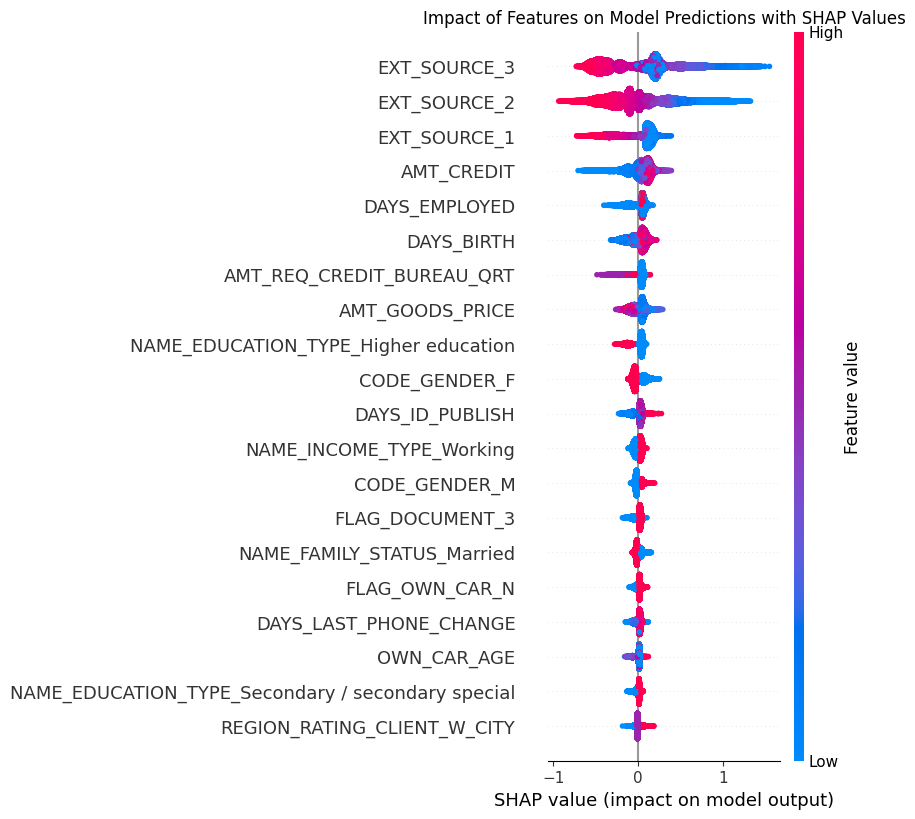

In [32]:
import shap

# You should replace 'model' with 'bst', which is your trained LightGBM booster
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test)

# Now you can generate the SHAP summary plot with the correct SHAP values
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)

import matplotlib.pyplot as plt
plt.title("Impact of Features on Model Predictions with SHAP Values")
plt.gcf().set_size_inches(10, 8)
plt.show()


## SHAP Summary Plot Analysis for Fraud Detection Model

The SHAP summary plot reveals the influence of different features on the predictions of a binary classification model, aimed at detecting fraudulent applications (where Target=1 indicates fraud). Below is an analysis of the key features impacting the model's predictions:

### Most Influential Features
- **EXT_SOURCE_3, EXT_SOURCE_2, EXT_SOURCE_1**: 
  - These features are top indicators.
  - Higher values typically suggest a lower likelihood of fraud.
  - Lower values are more indicative of a potential fraud case.

### Significant Features
- **AMT_CREDIT**:
  - The credit amount shows a variable influence on the predictions.
  - Both high and low values can suggest a fraud case, but high values more often indicate non-fraud.

- **DAYS_EMPLOYED**:
  - Indicates time since employment started.
  - Recent employment (lower values) is more often associated with non-fraud cases.
  - Less recent employment (higher values) tends to lean towards fraud predictions.

- **DAYS_BIRTH**:
  - Represents the applicant's age.
  - Younger individuals are more frequently associated with fraud predictions.

- **AMT_GOODS_PRICE**:
  - The price of goods for which the credit is sought.
  - Both high and low values are spread across fraud and non-fraud predictions.

- **AMT_REQ_CREDIT_BUREAU_QRT**:
  - Enquiries to the Credit Bureau in the last quarter.
  - A larger number of enquiries might be slightly indicative of fraud.

### Other Notable Features
- **NAME_EDUCATION_TYPE_Higher education**:
  - Individuals with higher education tend to show a lower probability of fraud.

- **CODE_GENDER_F/M**:
  - Gender shows a mixed influence, not being a strong indicator of fraud.

- **DAYS_ID_PUBLISH**:
  - The recency of ID document publication shows a lower impact on predictions.

- **NAME_INCOME_TYPE_Working**:
  - Individuals classified as 'Working' show a slightly higher likelihood of fraud.

### Plot Interpretation
- The color of the dots (from blue to red) corresponds to the feature value from low to high.
- The positioning of the dots on the x-axis indicates the SHAP value's impact on the model's output.
- Red dots positioned to the right suggest that higher feature values contribute to an increased likelihood of fraud.
- Blue dots to the left suggest that lower feature values contribute to an increased likelihood of fraud.
- The center area, where blue and red dots overlap, shows where feature values do not clearly distinguish between fraud and non-fraud cases.


# Misc. Column charting

## Object Column Distribution

Distribution Based on NAME_CONTRACT_TYPE
Description :  SK_ID_CURR 



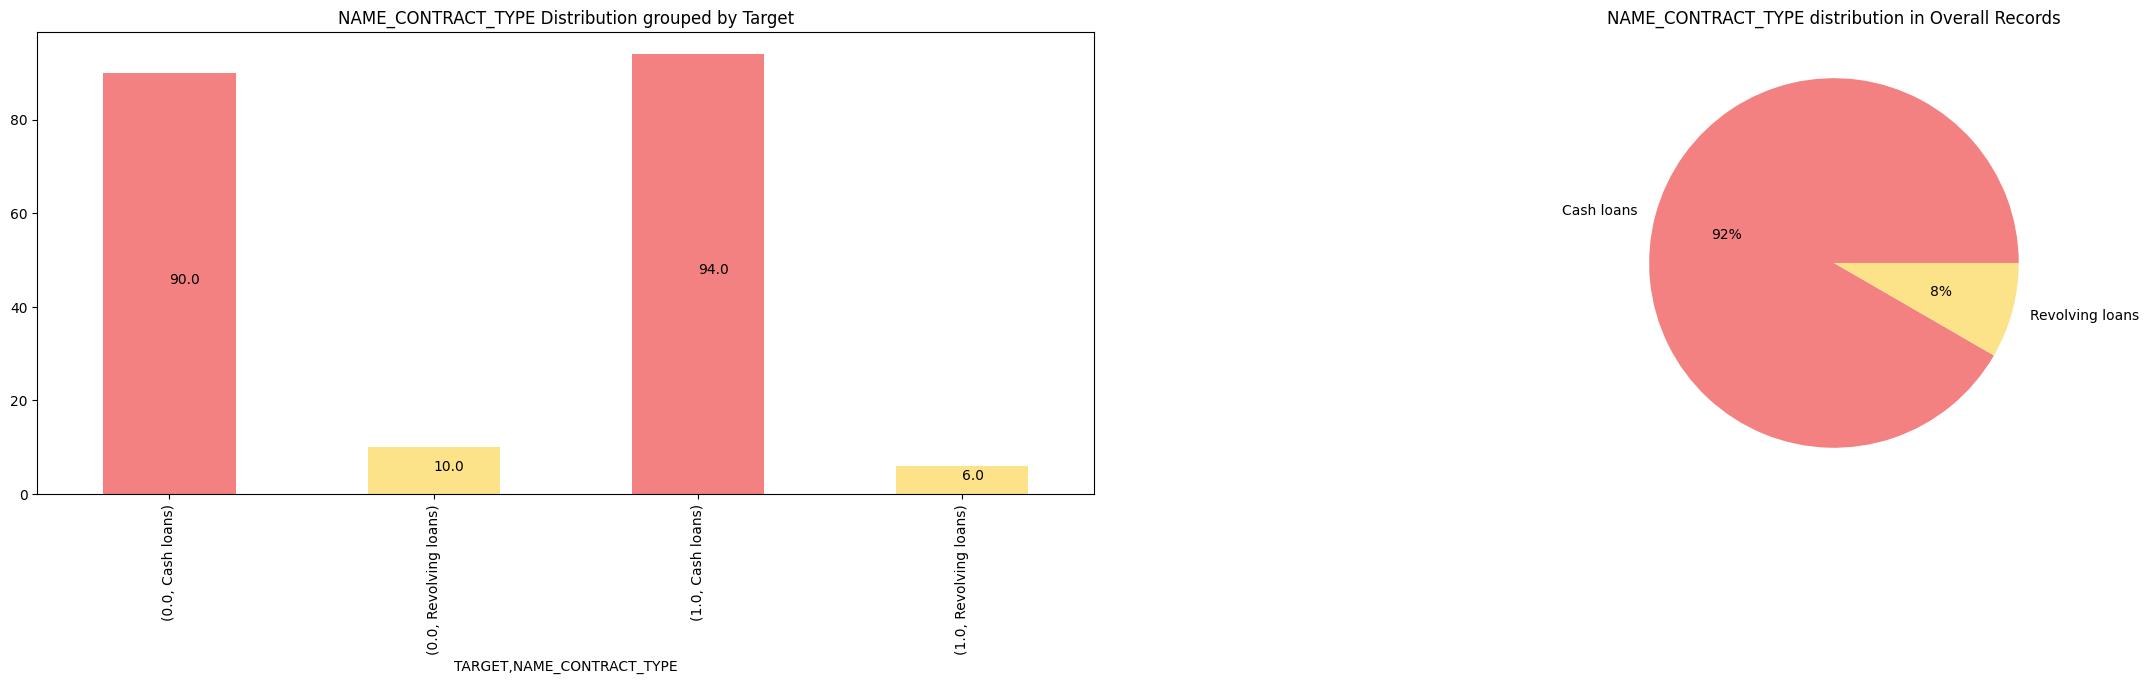

Table View
TARGET  NAME_CONTRACT_TYPE
0.0     Cash loans            90.0
        Revolving loans       10.0
1.0     Cash loans            94.0
        Revolving loans        6.0
Name: proportion, dtype: float64



Distribution Based on CODE_GENDER
Description :  SK_ID_CURR 



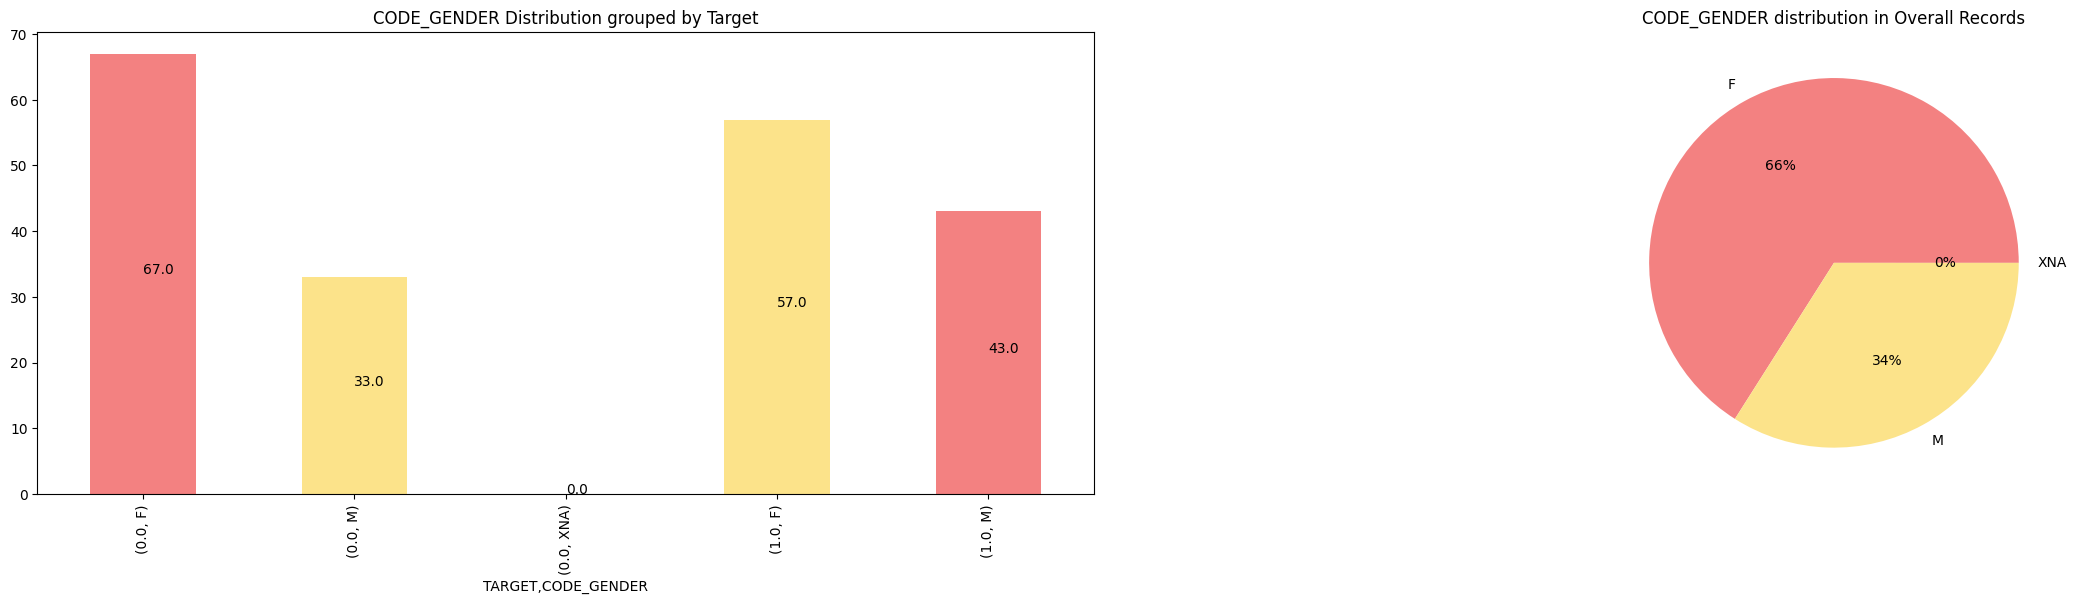

Table View
TARGET  CODE_GENDER
0.0     F              67.0
        M              33.0
        XNA             0.0
1.0     F              57.0
        M              43.0
Name: proportion, dtype: float64



Distribution Based on FLAG_OWN_CAR
Description :  SK_ID_CURR 



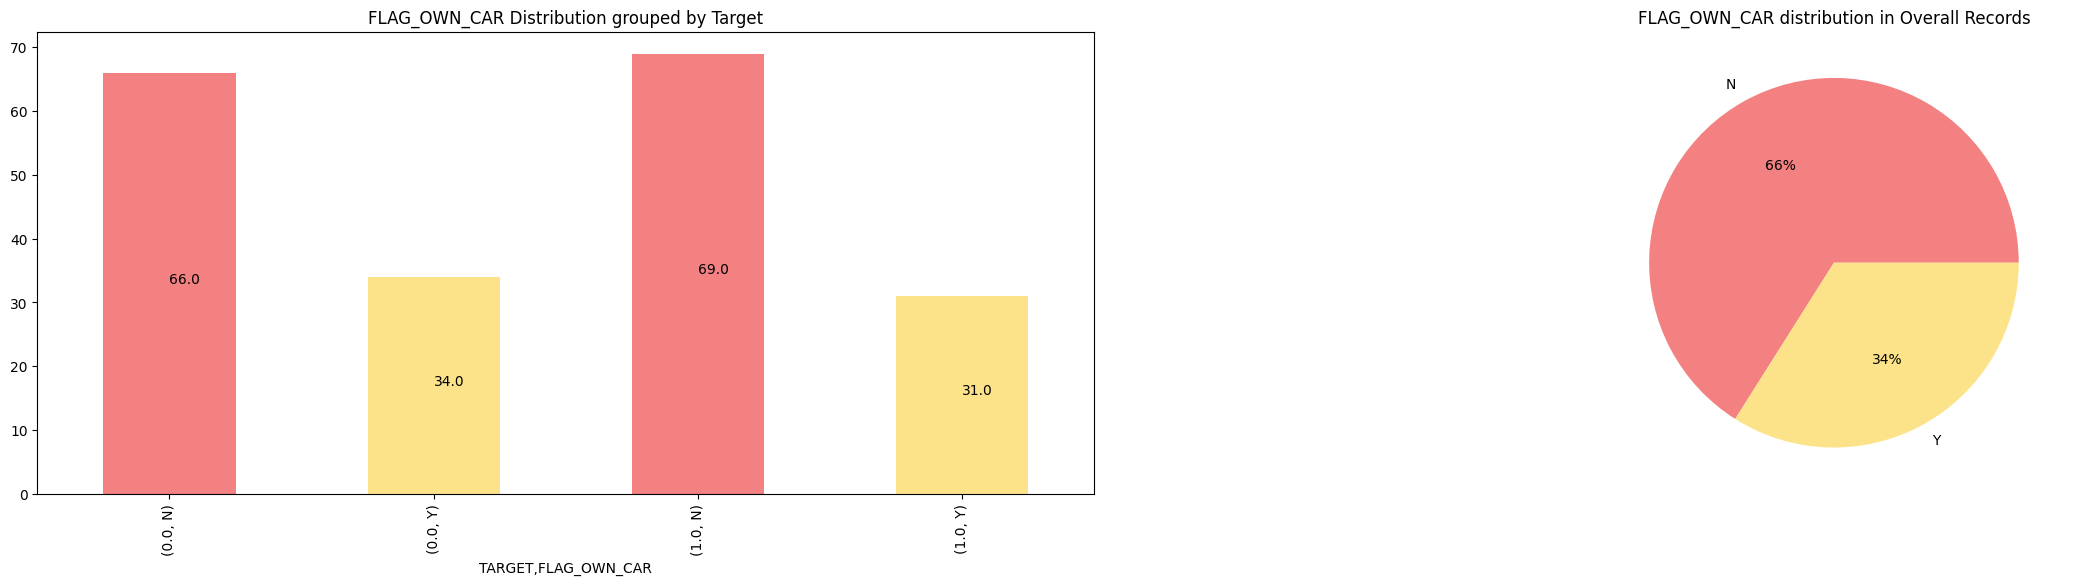

Table View
TARGET  FLAG_OWN_CAR
0.0     N               66.0
        Y               34.0
1.0     N               69.0
        Y               31.0
Name: proportion, dtype: float64



Distribution Based on FLAG_OWN_REALTY
Description :  SK_ID_CURR 



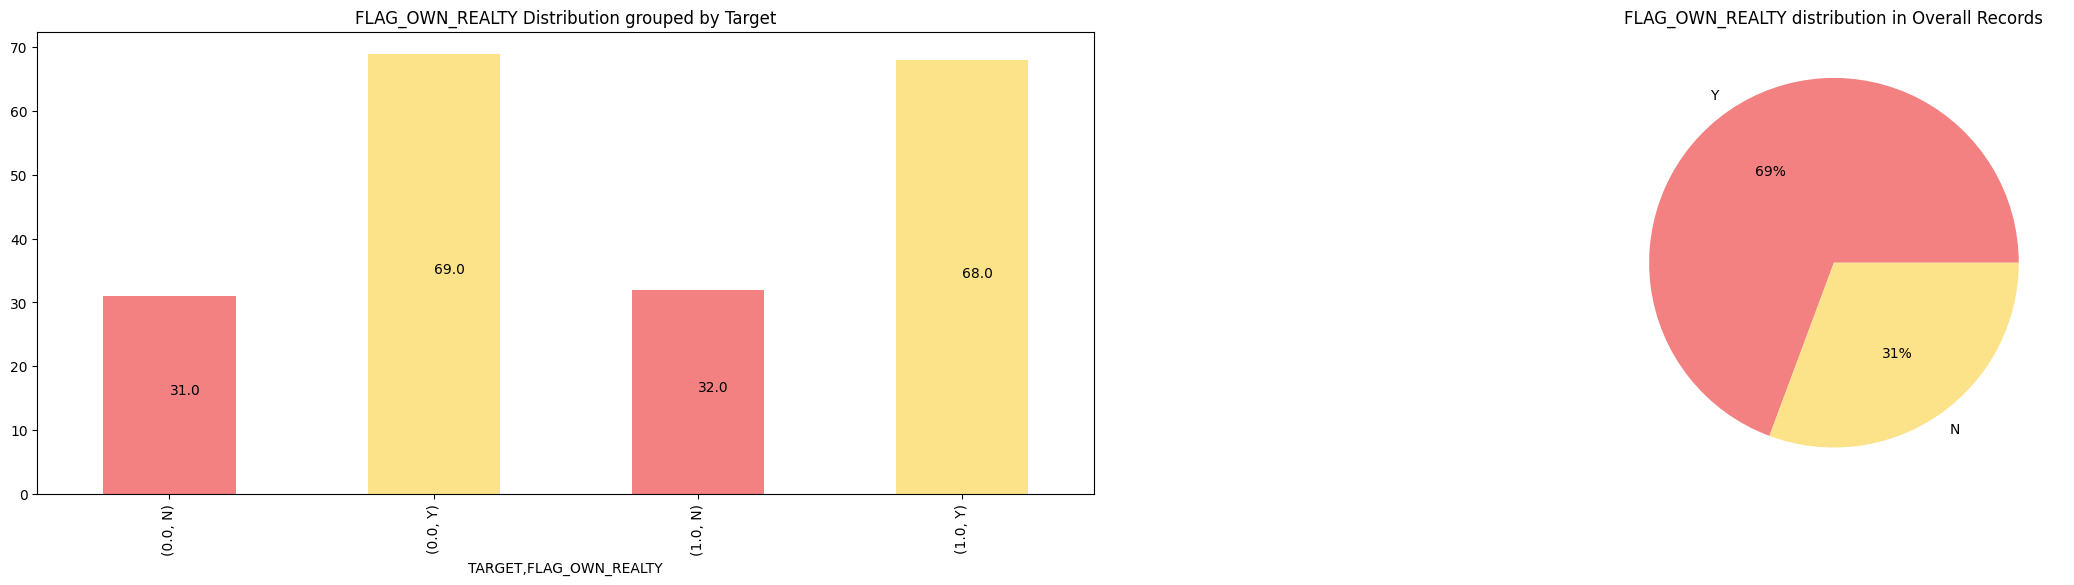

Table View
TARGET  FLAG_OWN_REALTY
0.0     N                  31.0
        Y                  69.0
1.0     N                  32.0
        Y                  68.0
Name: proportion, dtype: float64



Distribution Based on NAME_TYPE_SUITE
Description :  SK_ID_CURR 



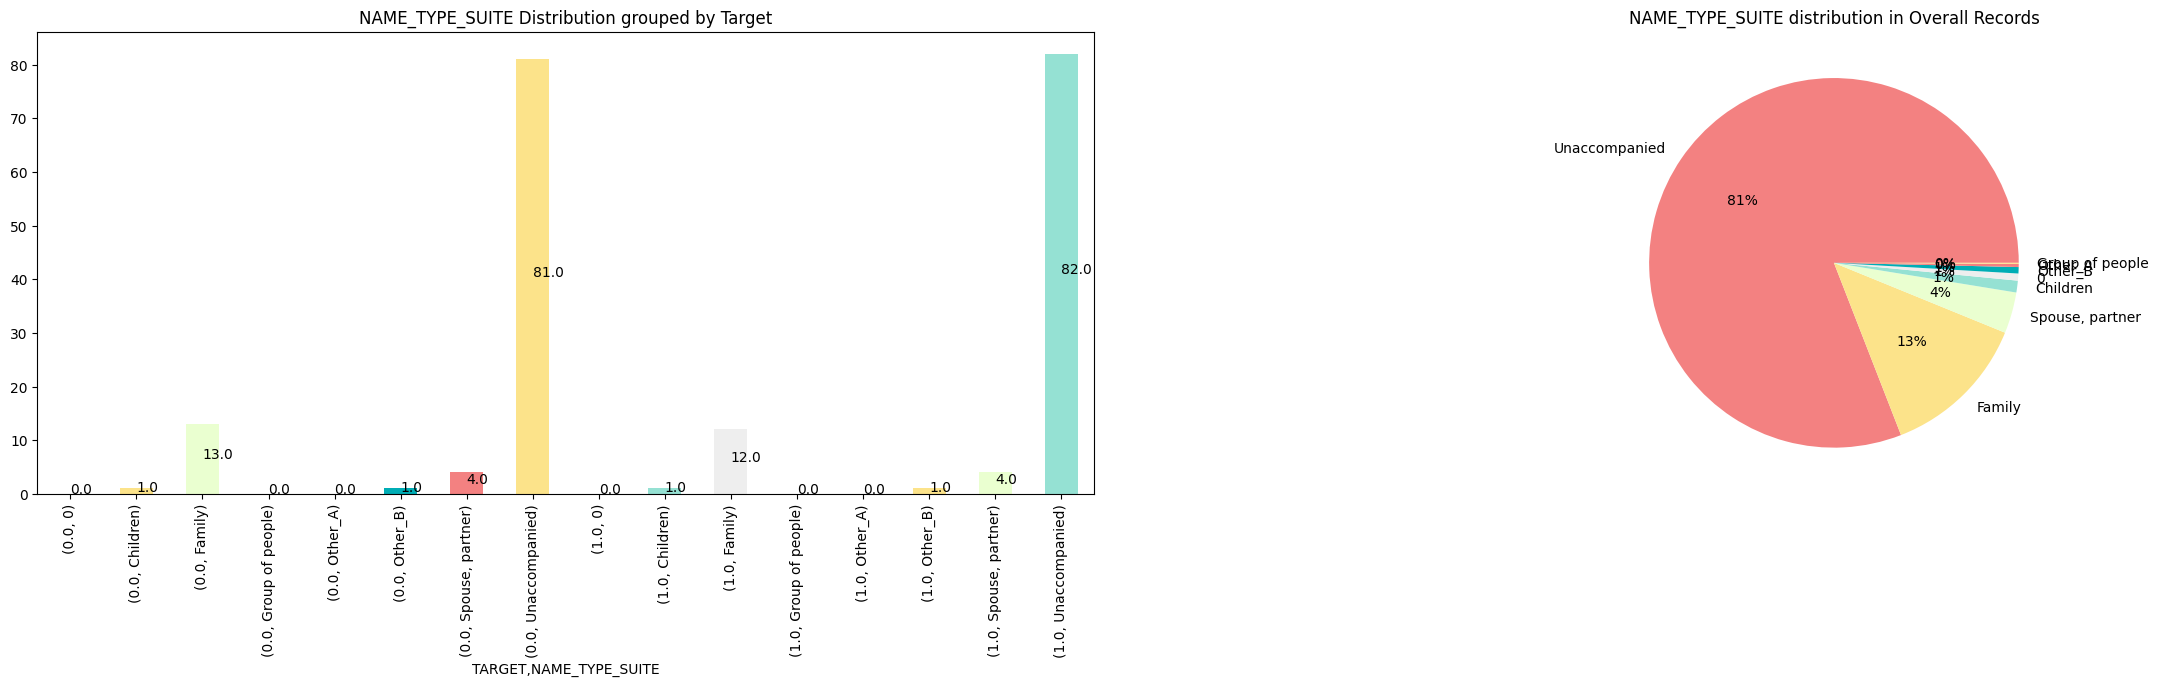

Table View
TARGET  NAME_TYPE_SUITE
0.0     0                   0.0
        Children            1.0
        Family             13.0
        Group of people     0.0
        Other_A             0.0
        Other_B             1.0
        Spouse, partner     4.0
        Unaccompanied      81.0
1.0     0                   0.0
        Children            1.0
        Family             12.0
        Group of people     0.0
        Other_A             0.0
        Other_B             1.0
        Spouse, partner     4.0
        Unaccompanied      82.0
Name: proportion, dtype: float64



Distribution Based on NAME_INCOME_TYPE
Description :  SK_ID_CURR 



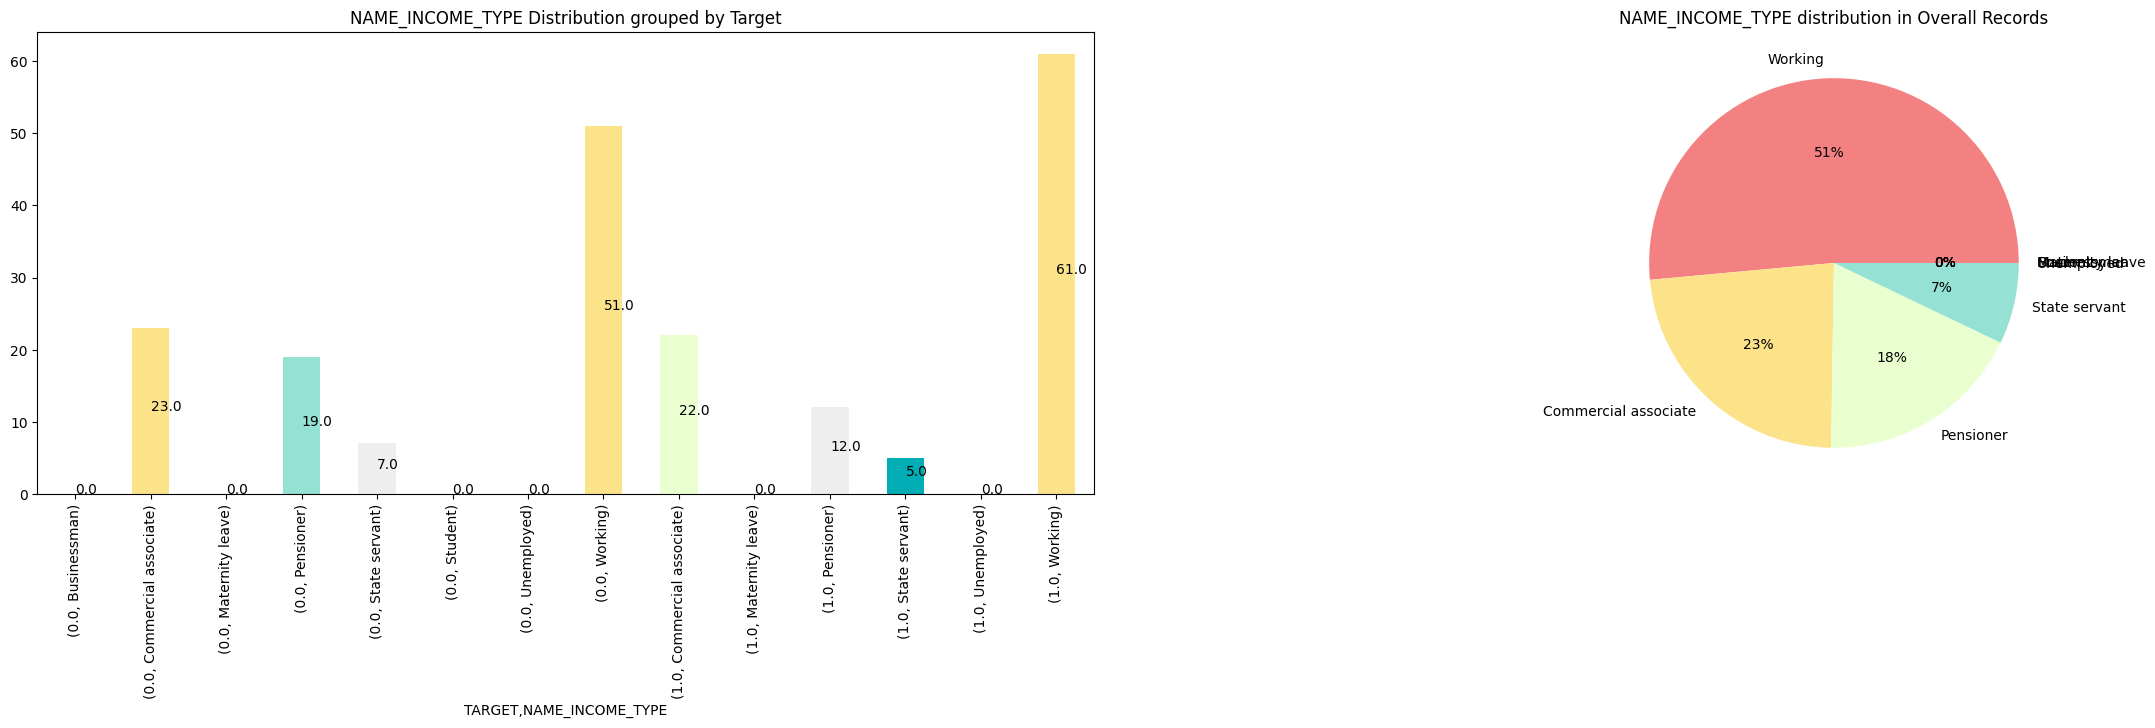

Table View
TARGET  NAME_INCOME_TYPE    
0.0     Businessman              0.0
        Commercial associate    23.0
        Maternity leave          0.0
        Pensioner               19.0
        State servant            7.0
        Student                  0.0
        Unemployed               0.0
        Working                 51.0
1.0     Commercial associate    22.0
        Maternity leave          0.0
        Pensioner               12.0
        State servant            5.0
        Unemployed               0.0
        Working                 61.0
Name: proportion, dtype: float64



Distribution Based on NAME_EDUCATION_TYPE
Description :  SK_ID_CURR 



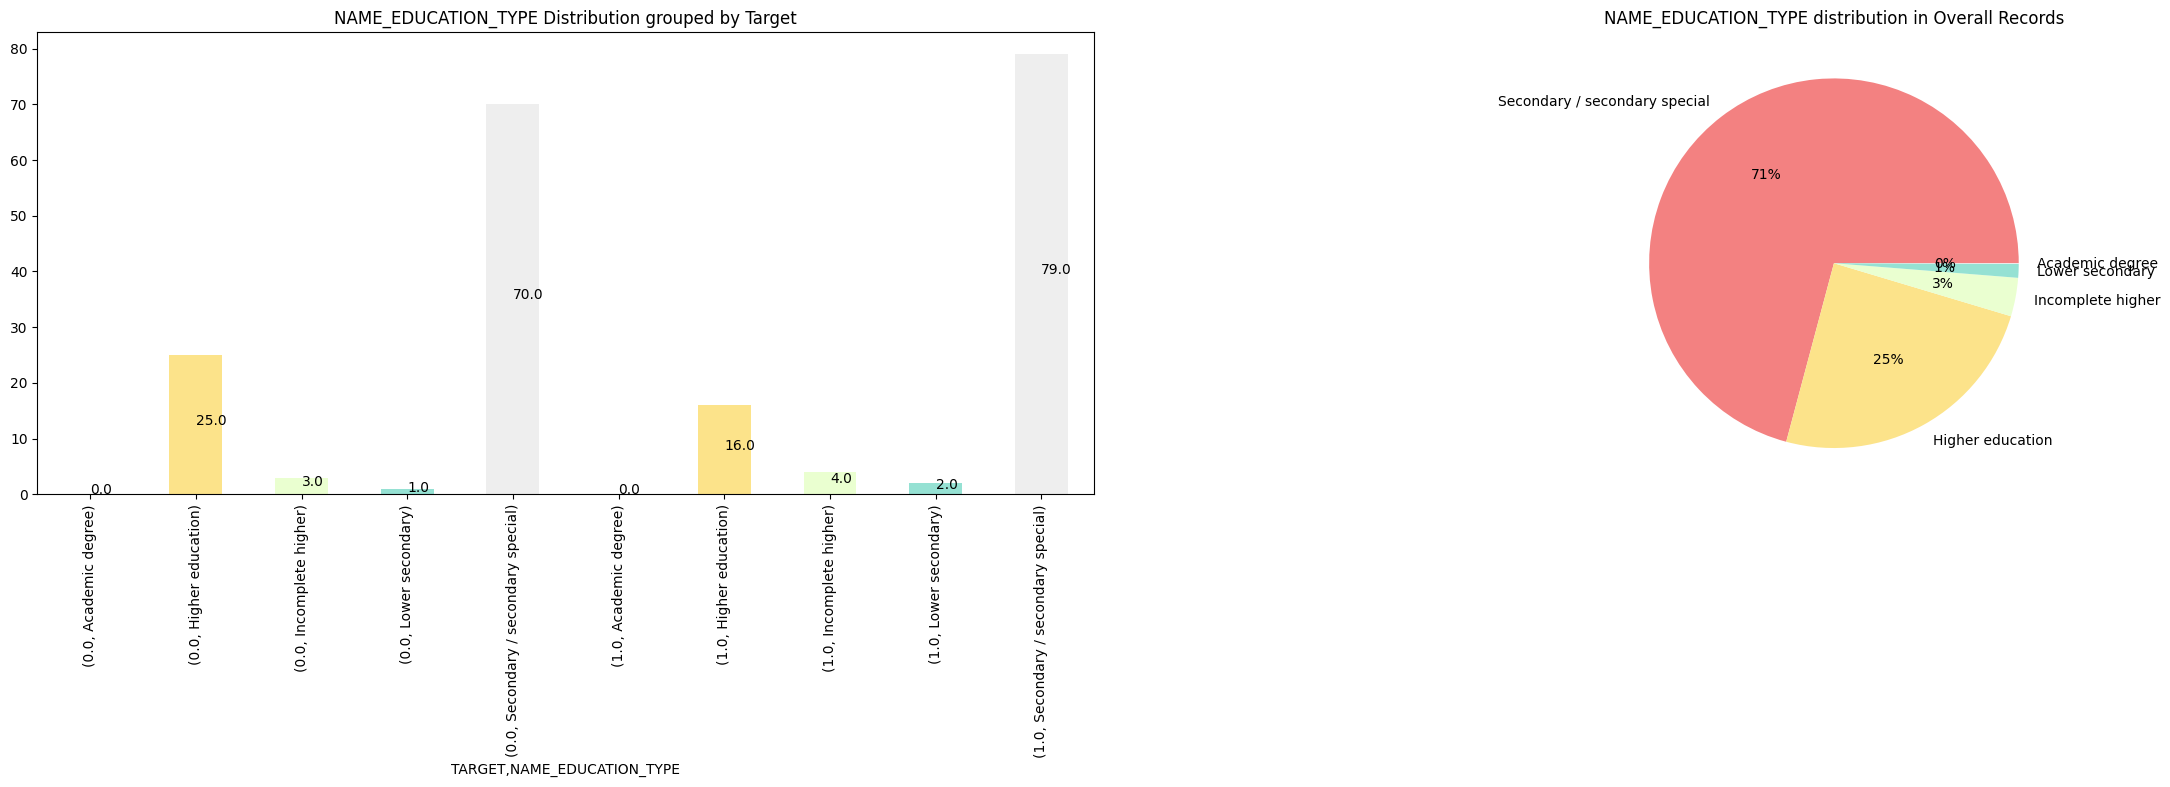

Table View
TARGET  NAME_EDUCATION_TYPE          
0.0     Academic degree                   0.0
        Higher education                 25.0
        Incomplete higher                 3.0
        Lower secondary                   1.0
        Secondary / secondary special    70.0
1.0     Academic degree                   0.0
        Higher education                 16.0
        Incomplete higher                 4.0
        Lower secondary                   2.0
        Secondary / secondary special    79.0
Name: proportion, dtype: float64



Distribution Based on NAME_FAMILY_STATUS
Description :  SK_ID_CURR 



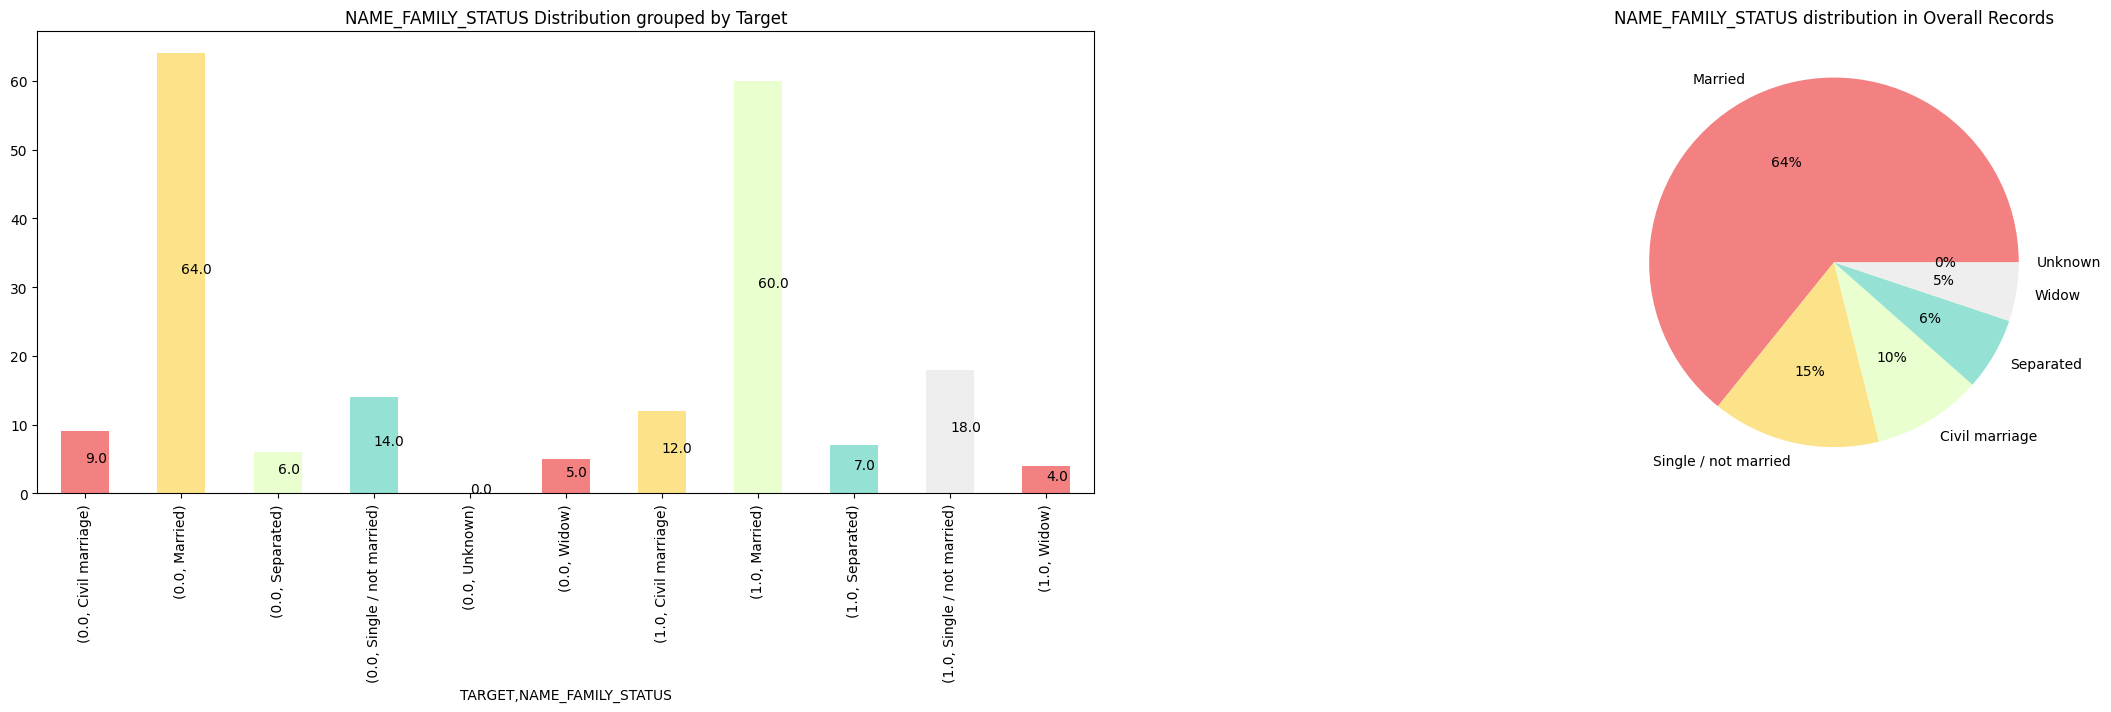

Table View
TARGET  NAME_FAMILY_STATUS  
0.0     Civil marriage           9.0
        Married                 64.0
        Separated                6.0
        Single / not married    14.0
        Unknown                  0.0
        Widow                    5.0
1.0     Civil marriage          12.0
        Married                 60.0
        Separated                7.0
        Single / not married    18.0
        Widow                    4.0
Name: proportion, dtype: float64



Distribution Based on NAME_HOUSING_TYPE
Description :  SK_ID_CURR 



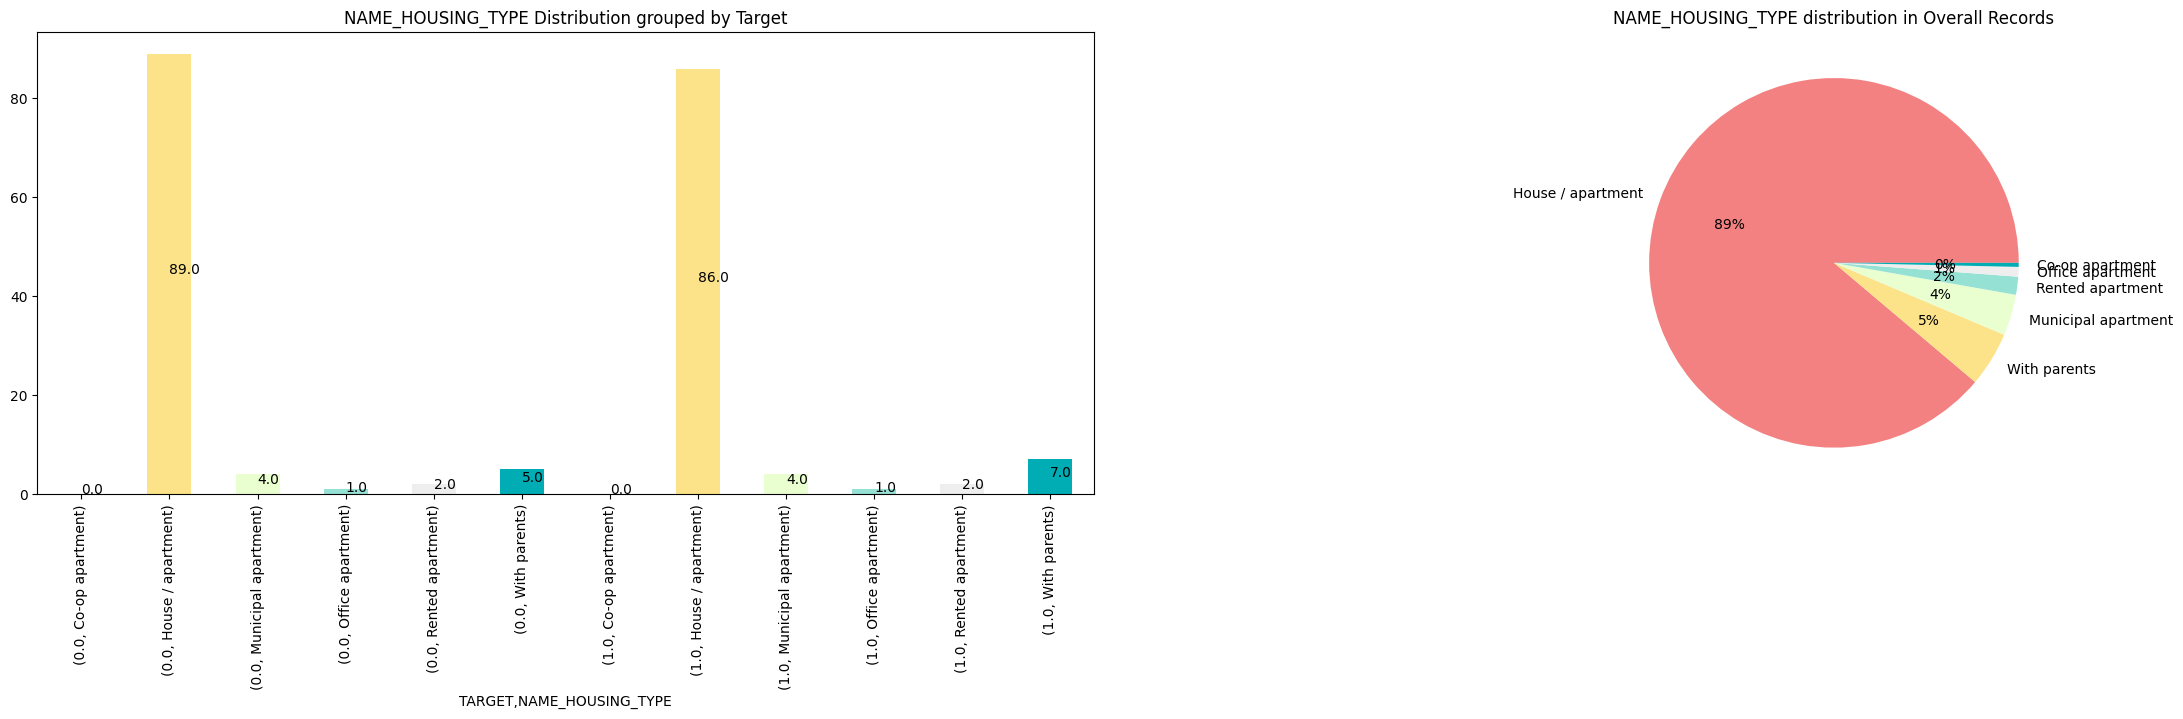

Table View
TARGET  NAME_HOUSING_TYPE  
0.0     Co-op apartment         0.0
        House / apartment      89.0
        Municipal apartment     4.0
        Office apartment        1.0
        Rented apartment        2.0
        With parents            5.0
1.0     Co-op apartment         0.0
        House / apartment      86.0
        Municipal apartment     4.0
        Office apartment        1.0
        Rented apartment        2.0
        With parents            7.0
Name: proportion, dtype: float64



Distribution Based on OCCUPATION_TYPE
Description :  SK_ID_CURR 



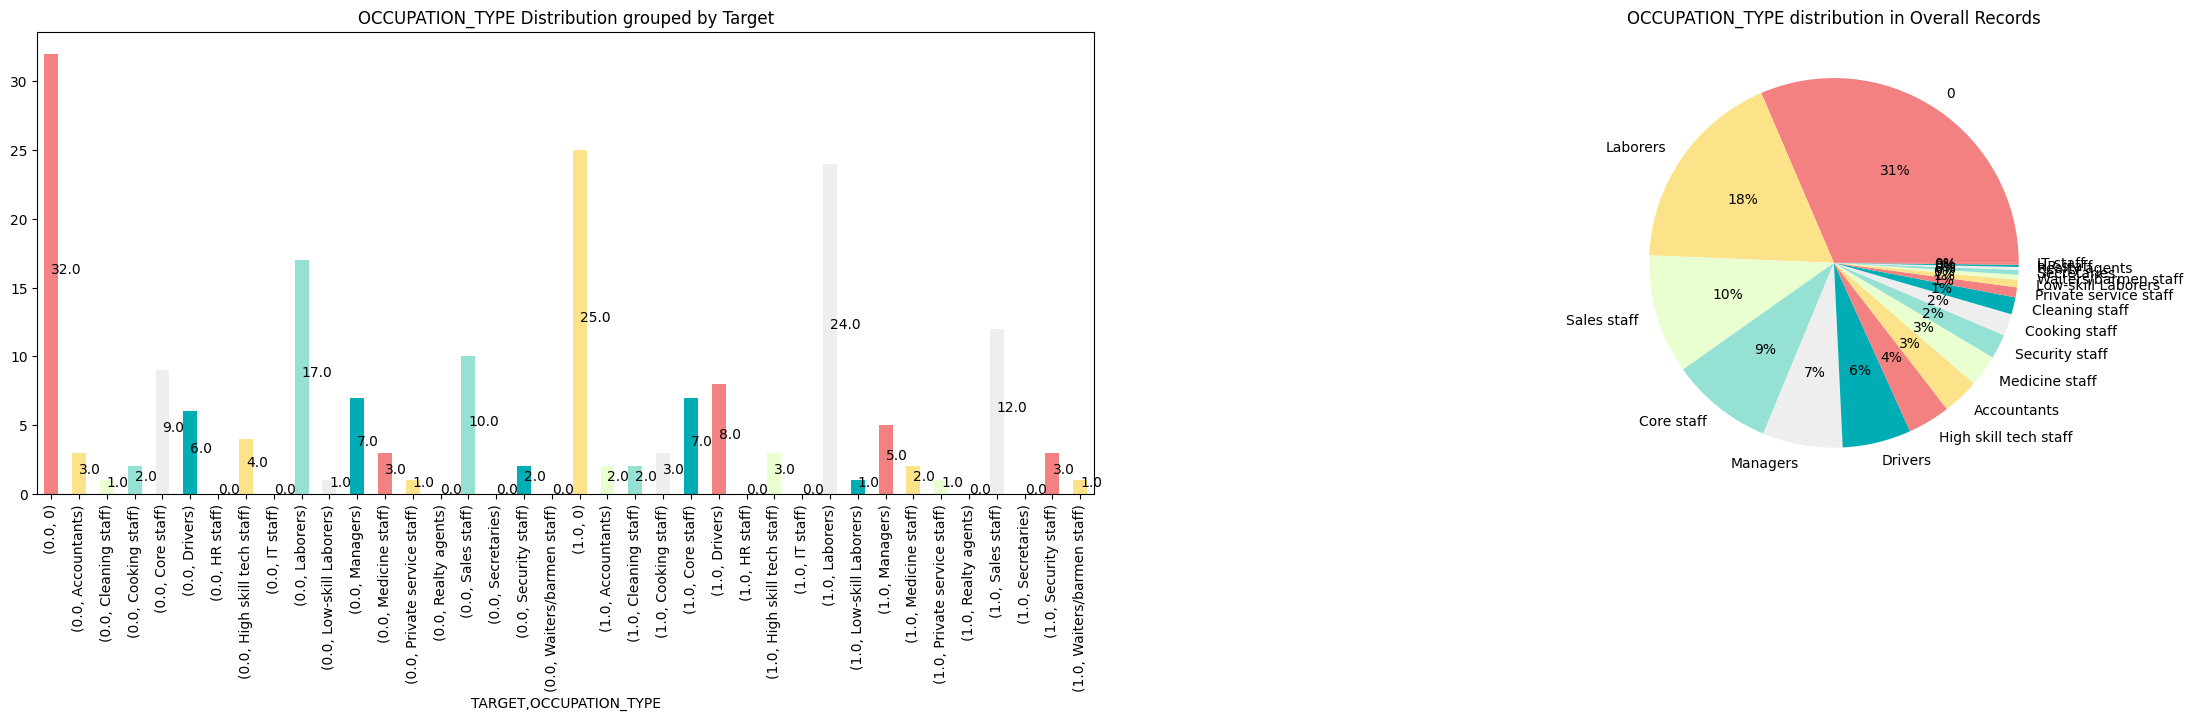

Table View
TARGET  OCCUPATION_TYPE      
0.0     0                        32.0
        Accountants               3.0
        Cleaning staff            1.0
        Cooking staff             2.0
        Core staff                9.0
        Drivers                   6.0
        HR staff                  0.0
        High skill tech staff     4.0
        IT staff                  0.0
        Laborers                 17.0
        Low-skill Laborers        1.0
        Managers                  7.0
        Medicine staff            3.0
        Private service staff     1.0
        Realty agents             0.0
        Sales staff              10.0
        Secretaries               0.0
        Security staff            2.0
        Waiters/barmen staff      0.0
1.0     0                        25.0
        Accountants               2.0
        Cleaning staff            2.0
        Cooking staff             3.0
        Core staff                7.0
        Drivers                   8.0
        H

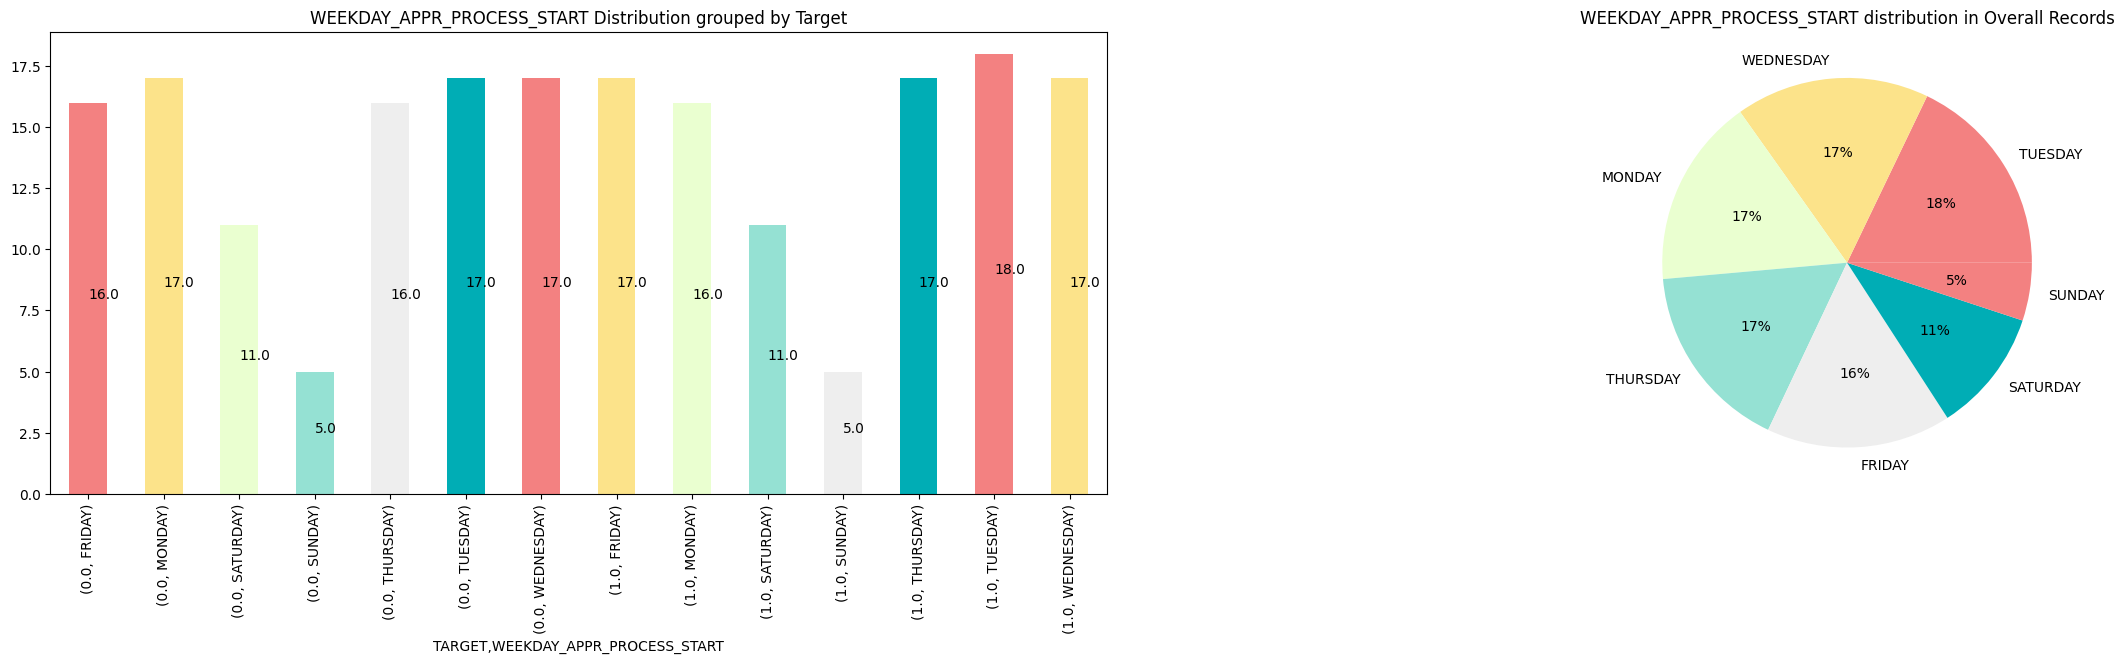

Table View
TARGET  WEEKDAY_APPR_PROCESS_START
0.0     FRIDAY                        16.0
        MONDAY                        17.0
        SATURDAY                      11.0
        SUNDAY                         5.0
        THURSDAY                      16.0
        TUESDAY                       17.0
        WEDNESDAY                     17.0
1.0     FRIDAY                        17.0
        MONDAY                        16.0
        SATURDAY                      11.0
        SUNDAY                         5.0
        THURSDAY                      17.0
        TUESDAY                       18.0
        WEDNESDAY                     17.0
Name: proportion, dtype: float64



Distribution Based on ORGANIZATION_TYPE
Description :  SK_ID_CURR 



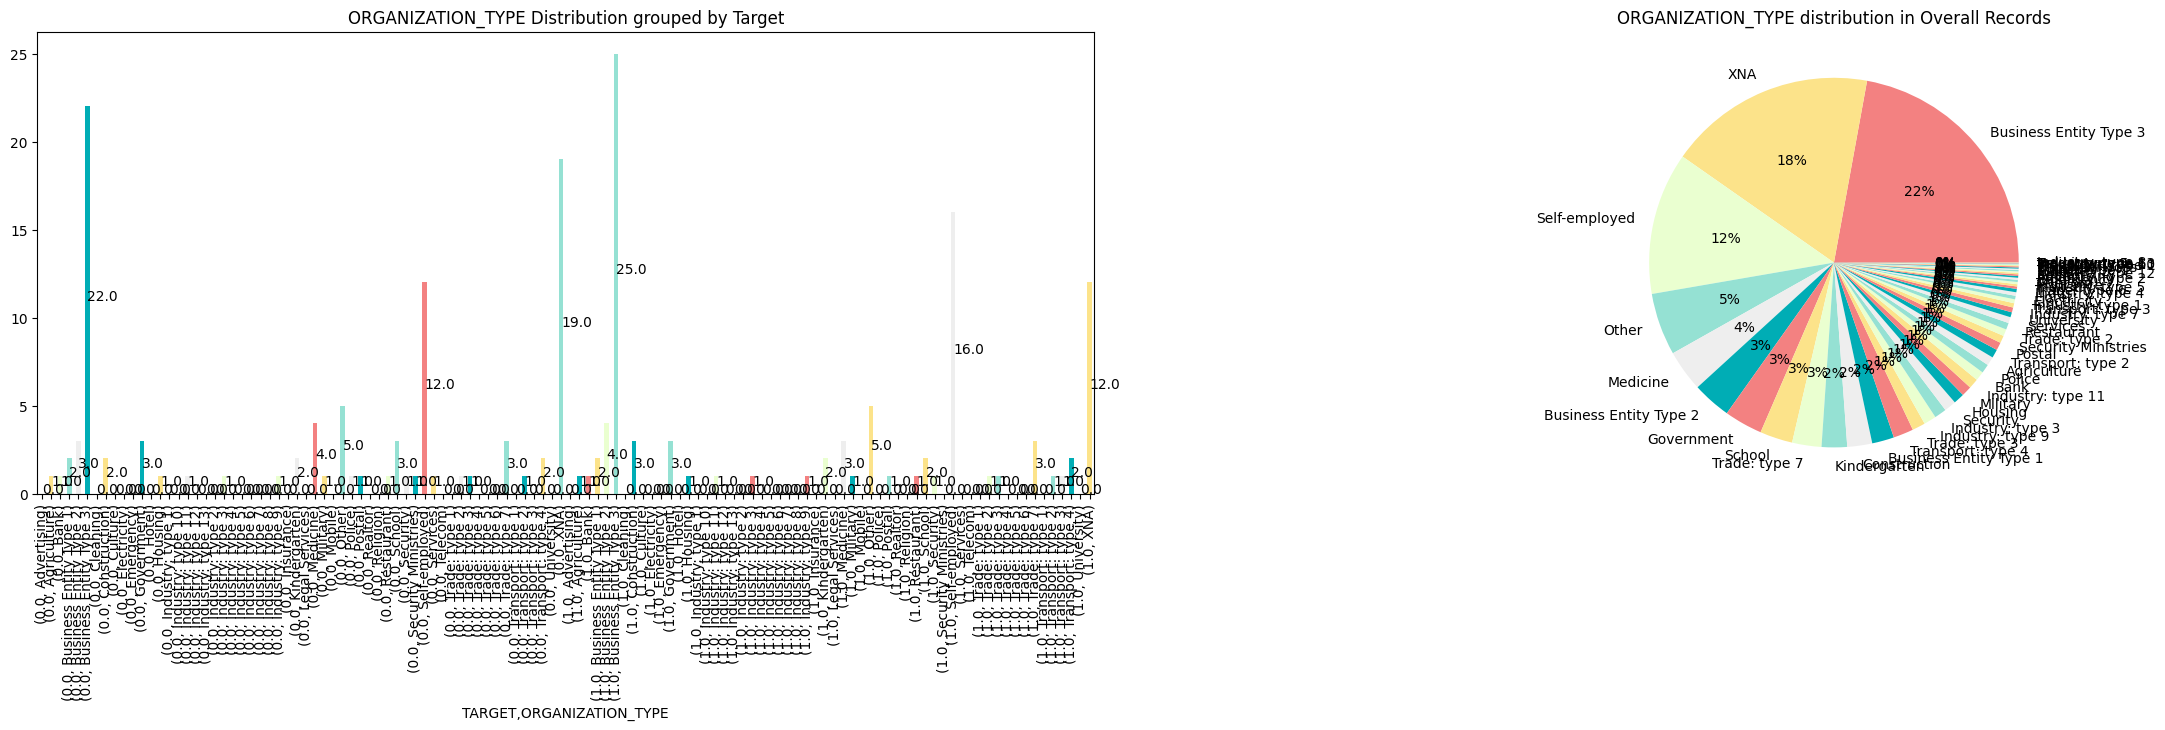

Table View
TARGET  ORGANIZATION_TYPE     
0.0     Advertising                0.0
        Agriculture                1.0
        Bank                       1.0
        Business Entity Type 1     2.0
        Business Entity Type 2     3.0
                                  ... 
1.0     Transport: type 2          1.0
        Transport: type 3          1.0
        Transport: type 4          2.0
        University                 0.0
        XNA                       12.0
Name: proportion, Length: 116, dtype: float64



Distribution Based on FONDKAPREMONT_MODE
Description :  SK_ID_CURR 



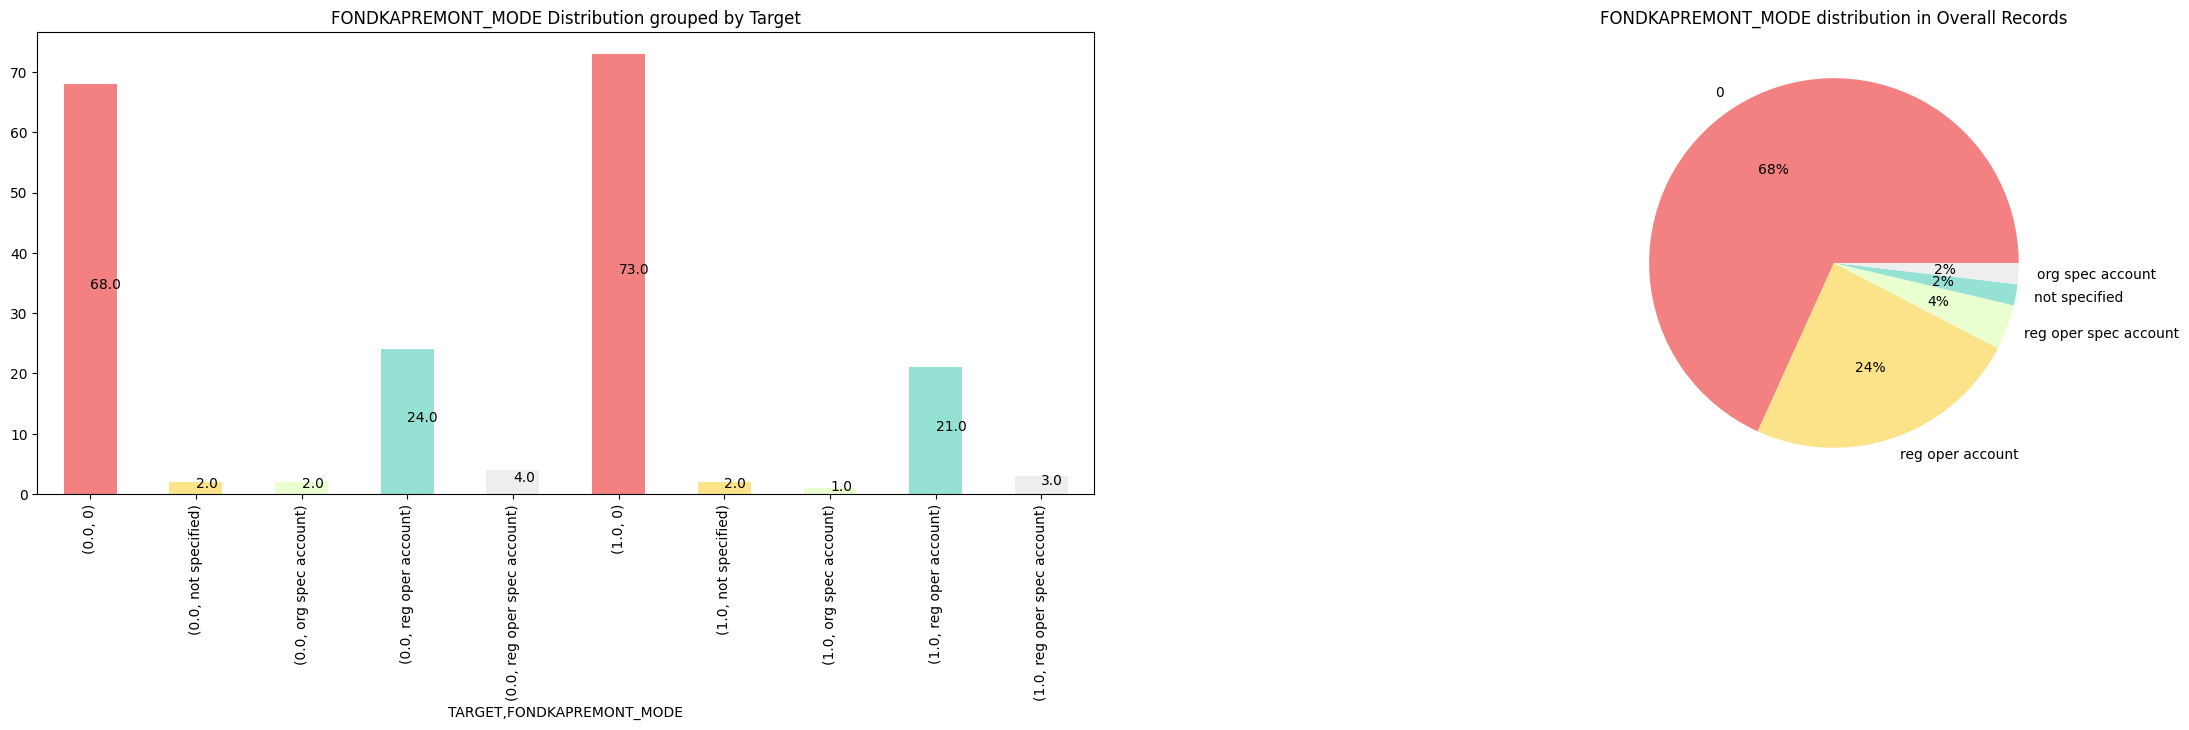

Table View
TARGET  FONDKAPREMONT_MODE   
0.0     0                        68.0
        not specified             2.0
        org spec account          2.0
        reg oper account         24.0
        reg oper spec account     4.0
1.0     0                        73.0
        not specified             2.0
        org spec account          1.0
        reg oper account         21.0
        reg oper spec account     3.0
Name: proportion, dtype: float64



Distribution Based on HOUSETYPE_MODE
Description :  SK_ID_CURR 



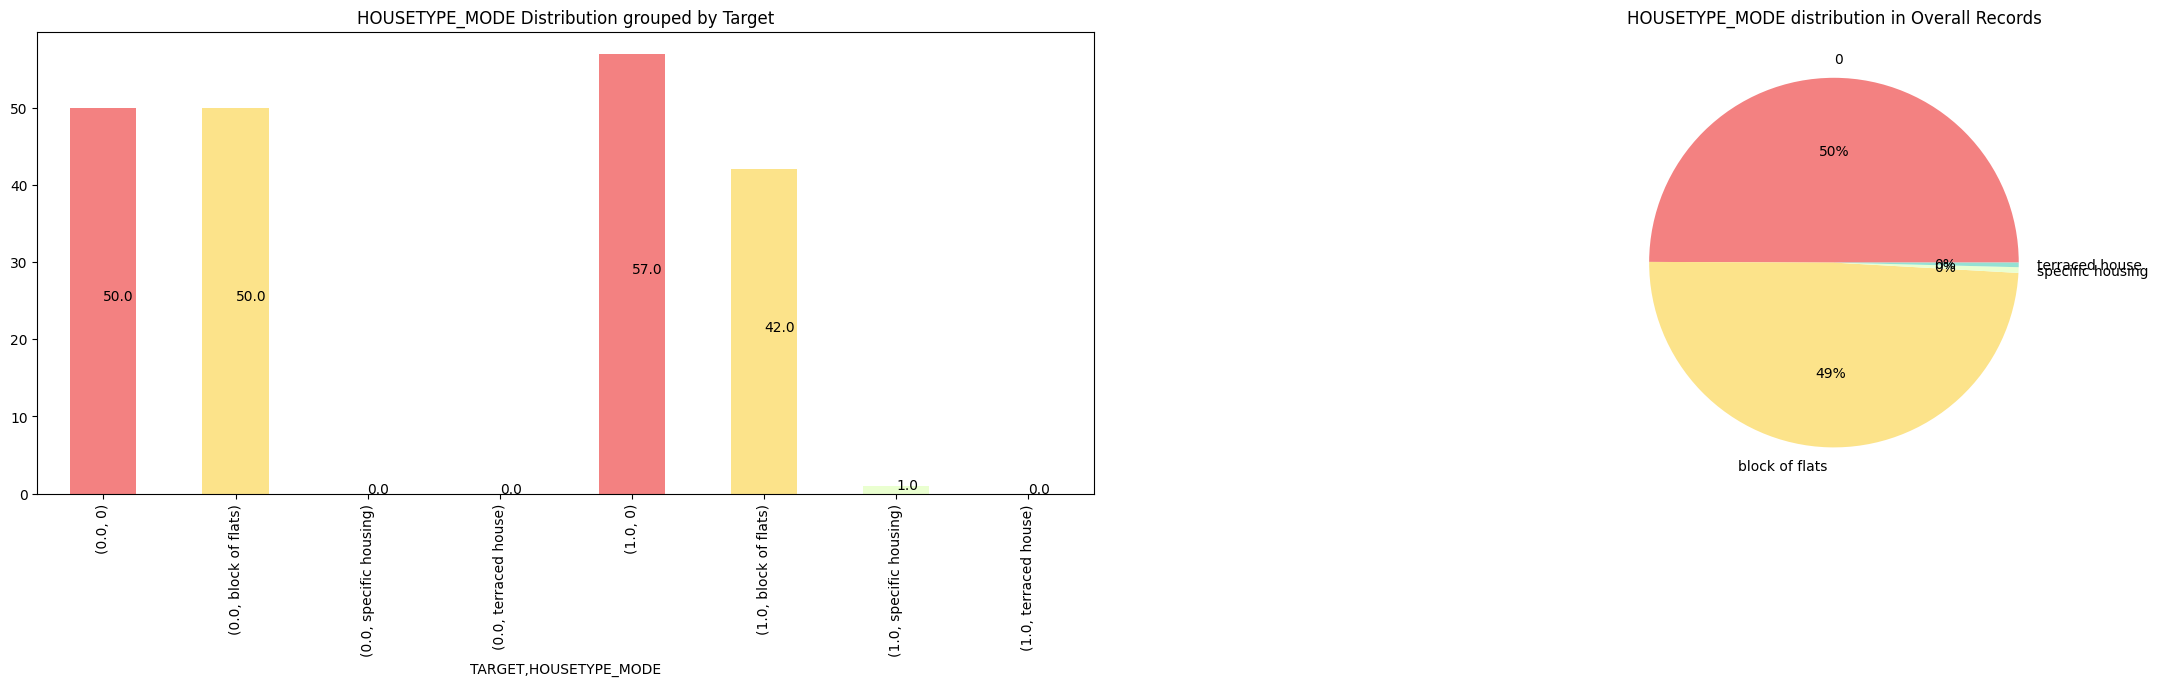

Table View
TARGET  HOUSETYPE_MODE  
0.0     0                   50.0
        block of flats      50.0
        specific housing     0.0
        terraced house       0.0
1.0     0                   57.0
        block of flats      42.0
        specific housing     1.0
        terraced house       0.0
Name: proportion, dtype: float64



Distribution Based on WALLSMATERIAL_MODE
Description :  SK_ID_CURR 



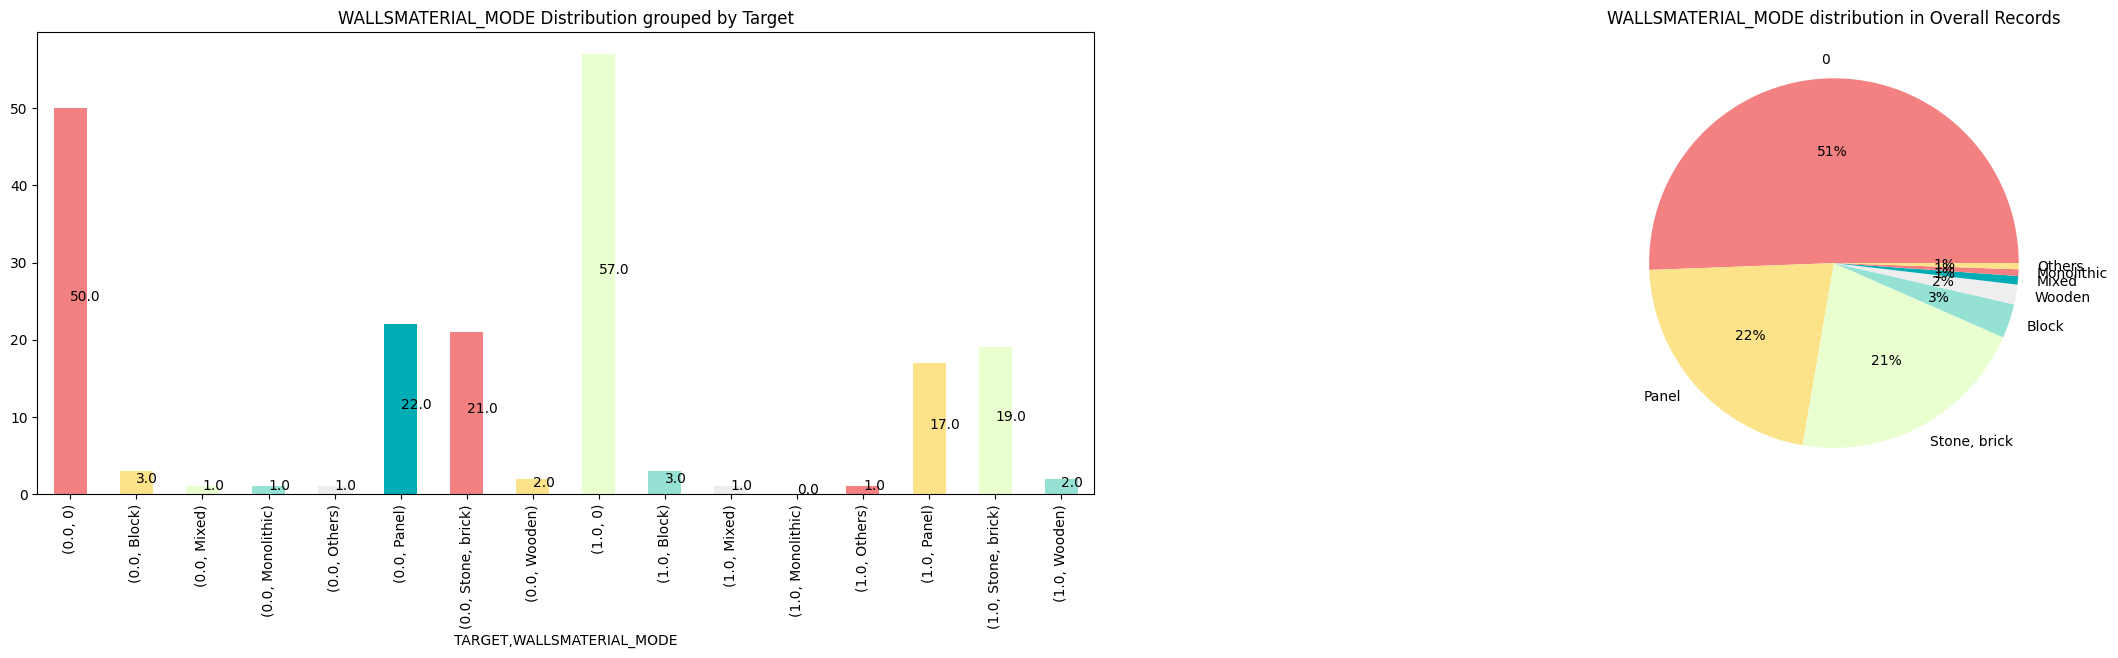

Table View
TARGET  WALLSMATERIAL_MODE
0.0     0                     50.0
        Block                  3.0
        Mixed                  1.0
        Monolithic             1.0
        Others                 1.0
        Panel                 22.0
        Stone, brick          21.0
        Wooden                 2.0
1.0     0                     57.0
        Block                  3.0
        Mixed                  1.0
        Monolithic             0.0
        Others                 1.0
        Panel                 17.0
        Stone, brick          19.0
        Wooden                 2.0
Name: proportion, dtype: float64



Distribution Based on EMERGENCYSTATE_MODE
Description :  SK_ID_CURR 



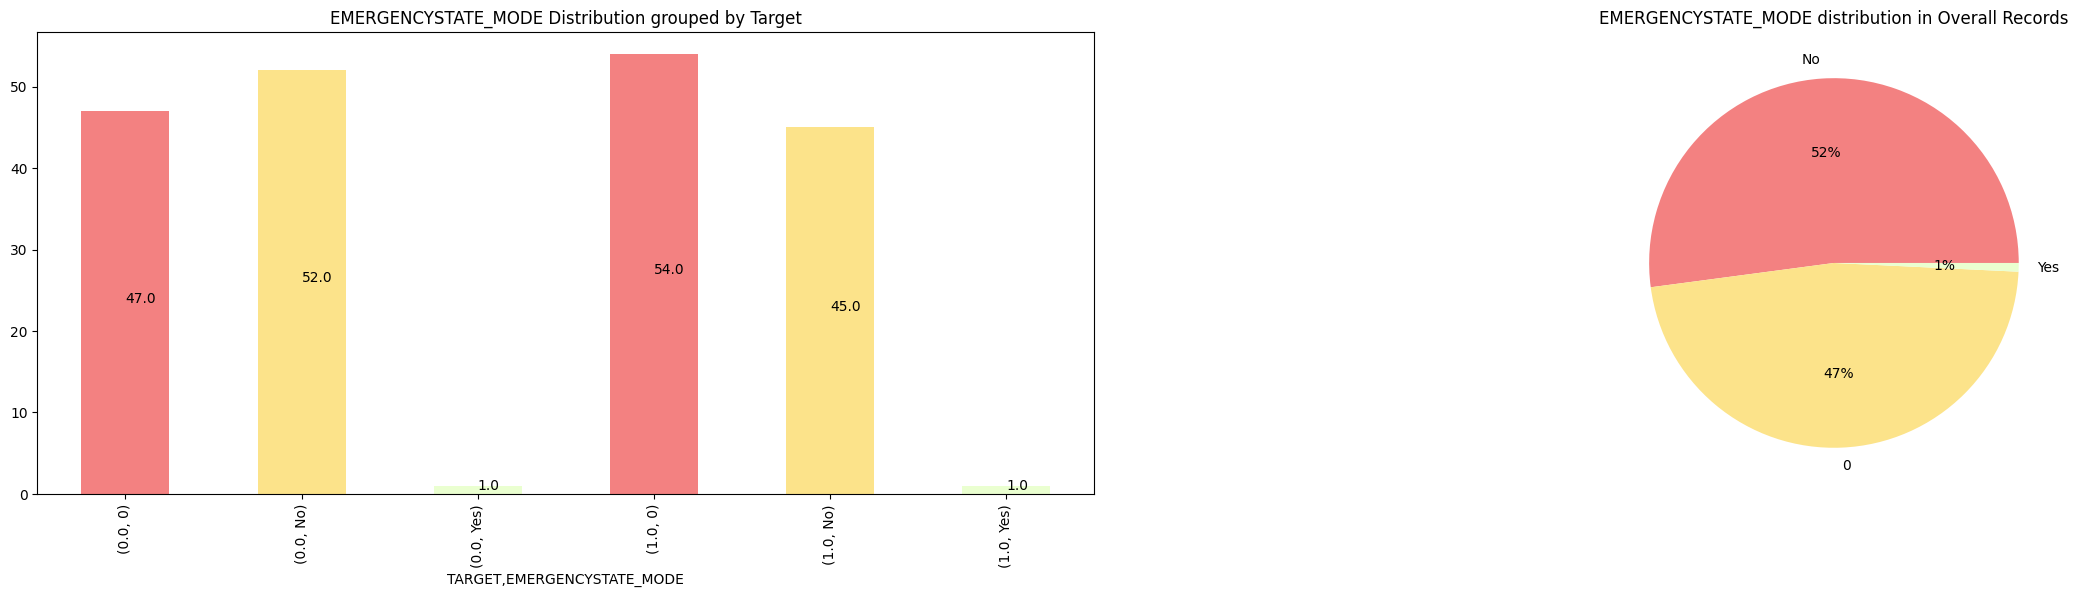

Table View
TARGET  EMERGENCYSTATE_MODE
0.0     0                      47.0
        No                     52.0
        Yes                     1.0
1.0     0                      54.0
        No                     45.0
        Yes                     1.0
Name: proportion, dtype: float64





In [33]:

file = current_data
#file = file[file["TARGET"]==1.0]
    
def distributionGraphs(x):
    print("\033[1m\033[1;3mDistribution Based on "+str(x)+"\033[0m")
    print('Description : ',columns_data[(columns_data == 'current_data') & (columns_data == x)],'\n')
    
    #Create a normalized value count converted to percentage
    target_group = round(file.groupby('TARGET')[x].value_counts(normalize=True,sort=False)*100)
    
    #cnt = int((target_group.count()))
    cnt = int((target_group.count()/2))
        
    all_colr = ['#F38181','#FCE38A','#EAFFD0','#95E1D3','#EEEEEE','#00ADB5']
    colors = all_colr[:cnt]
    plt.figure(figsize=(30,6))
    
    plt.subplot(121)
    plt.title(str(x)+' Distribution grouped by Target')
    ax = target_group.plot(kind='bar',color=colors)
    
    # A method to print values in Bar
    for bar in ax.patches:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height()/2, str(bar.get_height()))
    
    plt.subplot(122)
    plt.title(str(x)+' distribution in Overall Records')
    (current_data[x].value_counts(normalize=True)*100).plot(kind='pie', autopct = "%1.0f%%", colors=colors)
    plt.ylabel(' ')

    plt.show()
    
    print("\033[1m\033[1;3mTable View\033[0m")
    print(target_group)
    print("\n\n")

for feature in current_data_object[1:5]: #add column list numbers to control [1:2]
    distributionGraphs(feature)


## Numeric Column Distribution

Numeric cols 55
Area cols 9
Flag cols 26
Days cols 6
Amount cols 10
Distribution Based on OWN_CAR_AGE
Description :  SK_ID_CURR


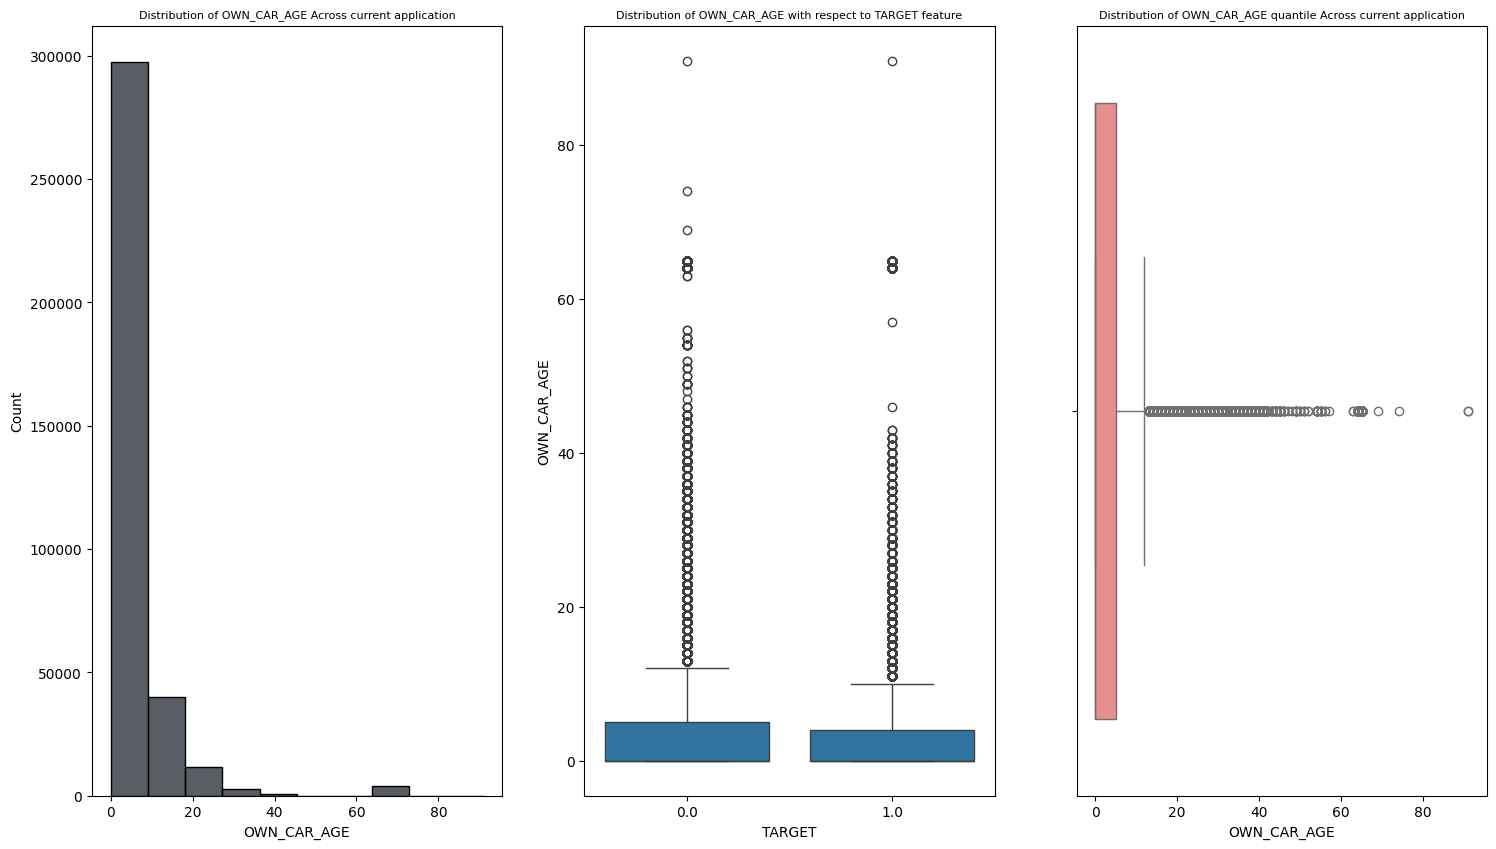

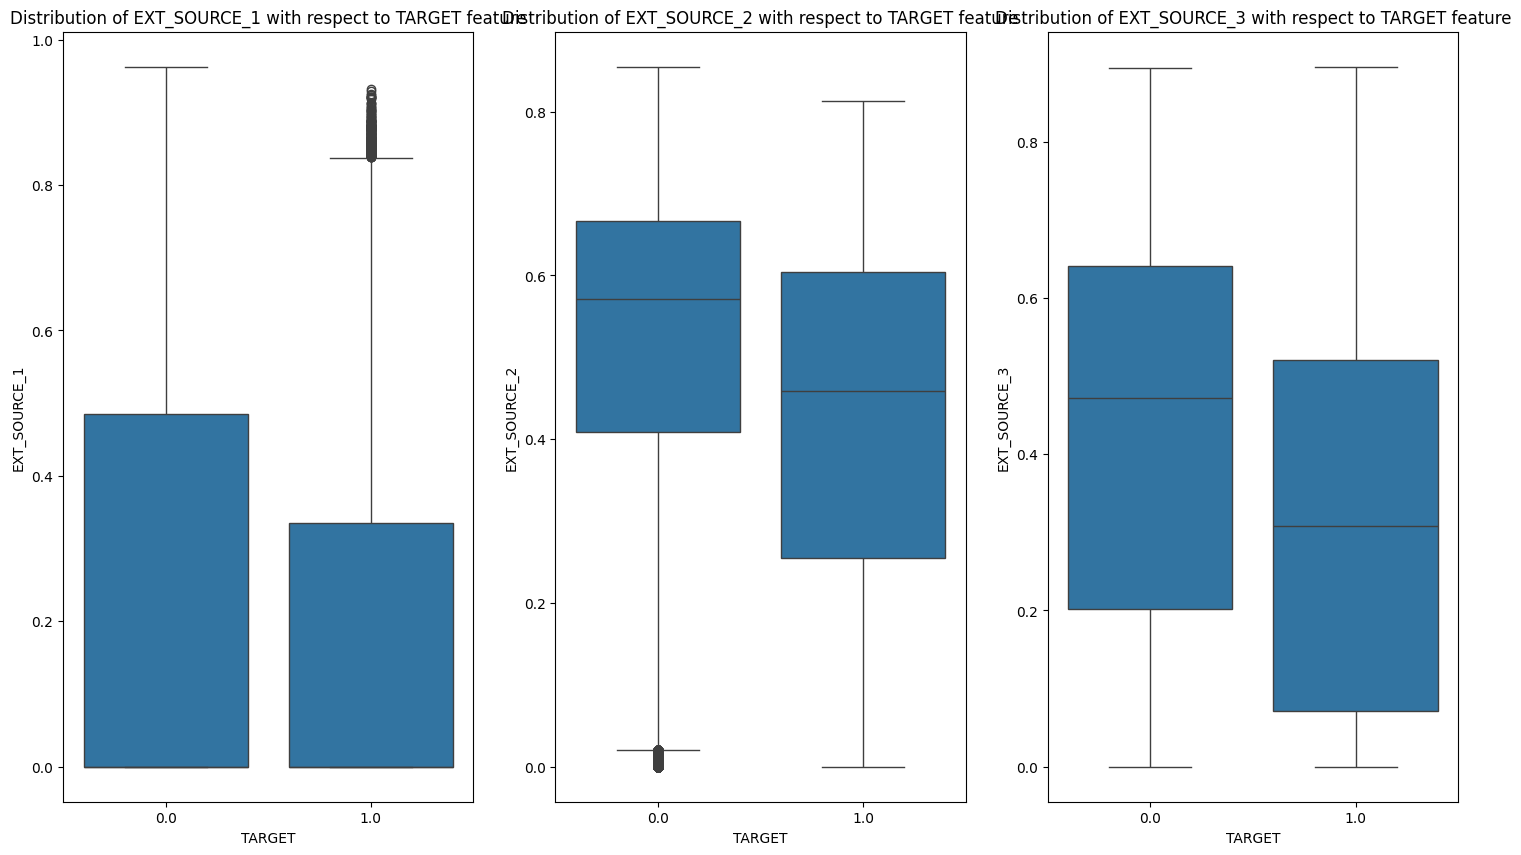

Distribution Based on FLAG_MOBIL
Description :  SK_ID_CURR 



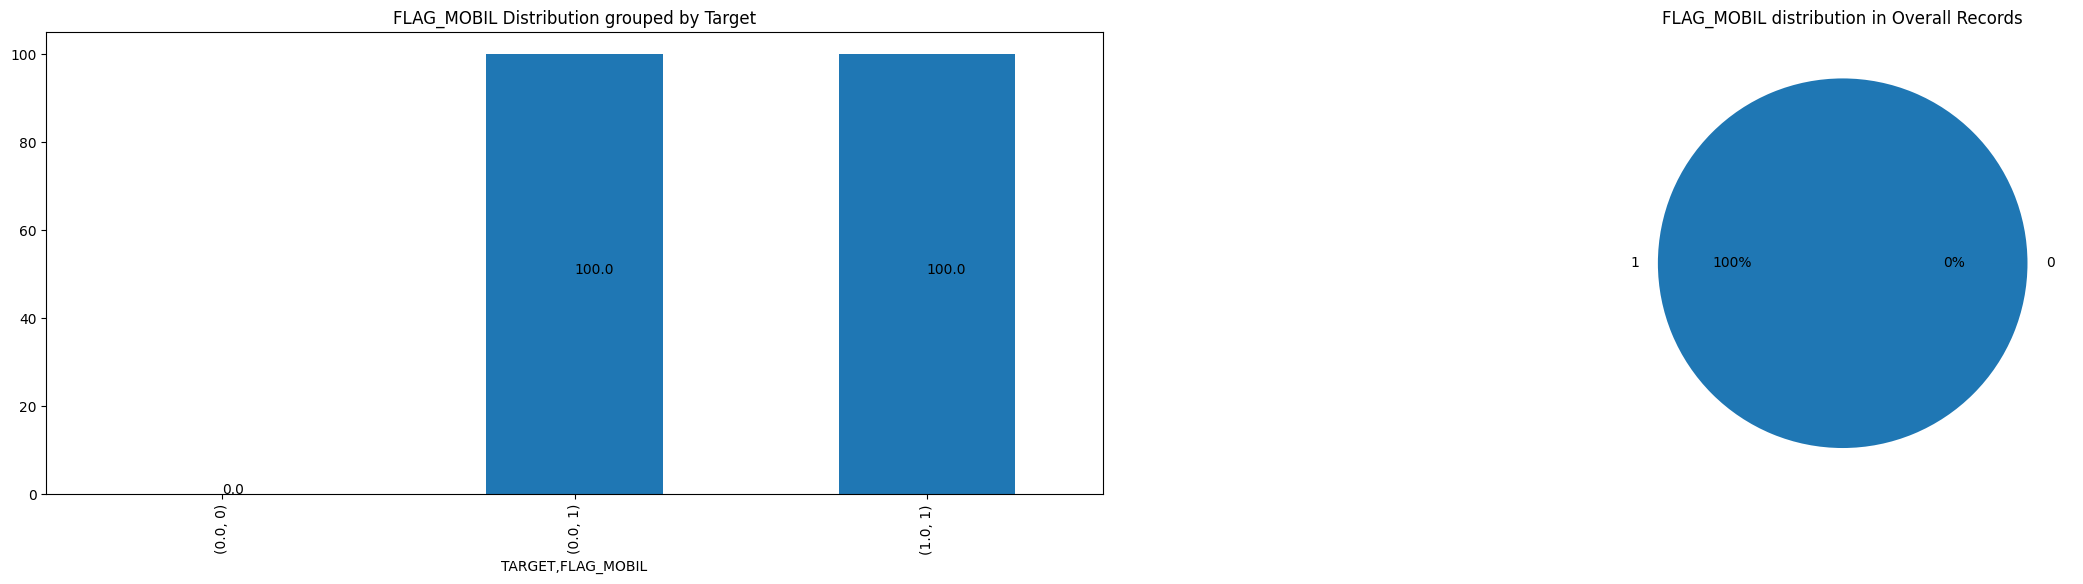

Table View
TARGET  FLAG_MOBIL
0.0     0               0.0
        1             100.0
1.0     1             100.0
Name: proportion, dtype: float64



Distribution Based on FLAG_EMP_PHONE
Description :  SK_ID_CURR 



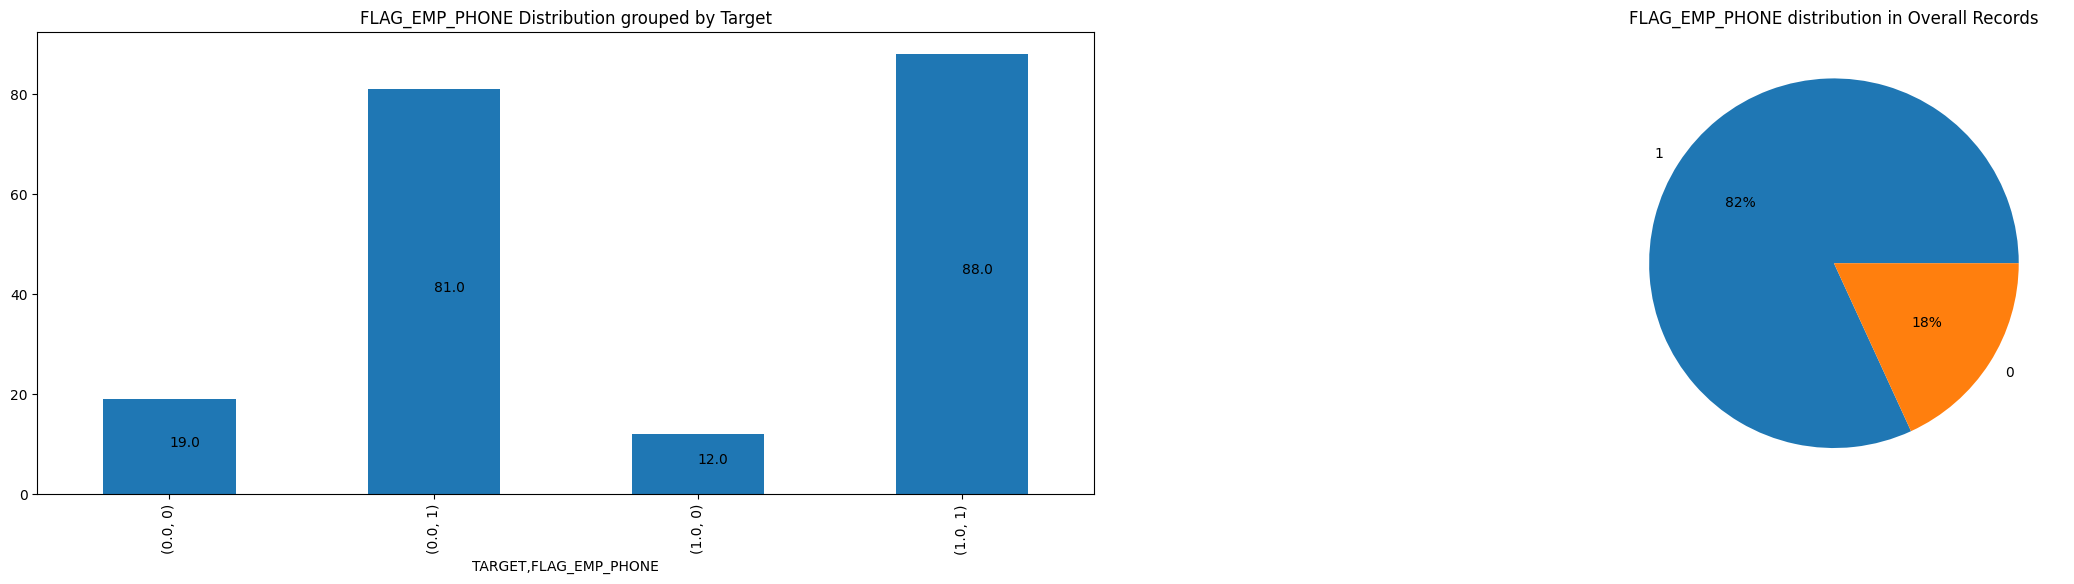

Table View
TARGET  FLAG_EMP_PHONE
0.0     0                 19.0
        1                 81.0
1.0     0                 12.0
        1                 88.0
Name: proportion, dtype: float64



Distribution Based on FLAG_WORK_PHONE
Description :  SK_ID_CURR 



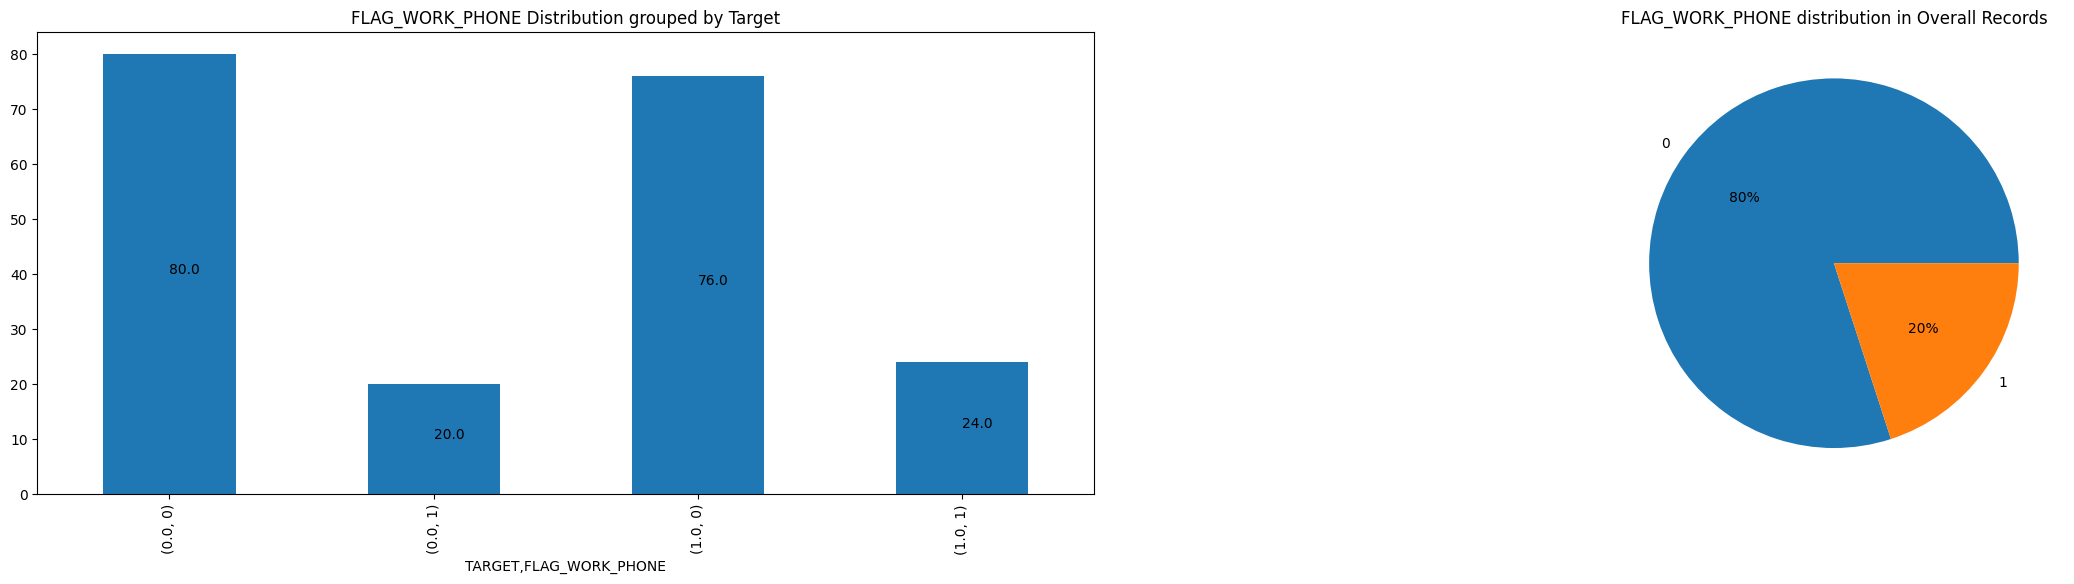

Table View
TARGET  FLAG_WORK_PHONE
0.0     0                  80.0
        1                  20.0
1.0     0                  76.0
        1                  24.0
Name: proportion, dtype: float64



Distribution Based on FLAG_CONT_MOBILE
Description :  SK_ID_CURR 



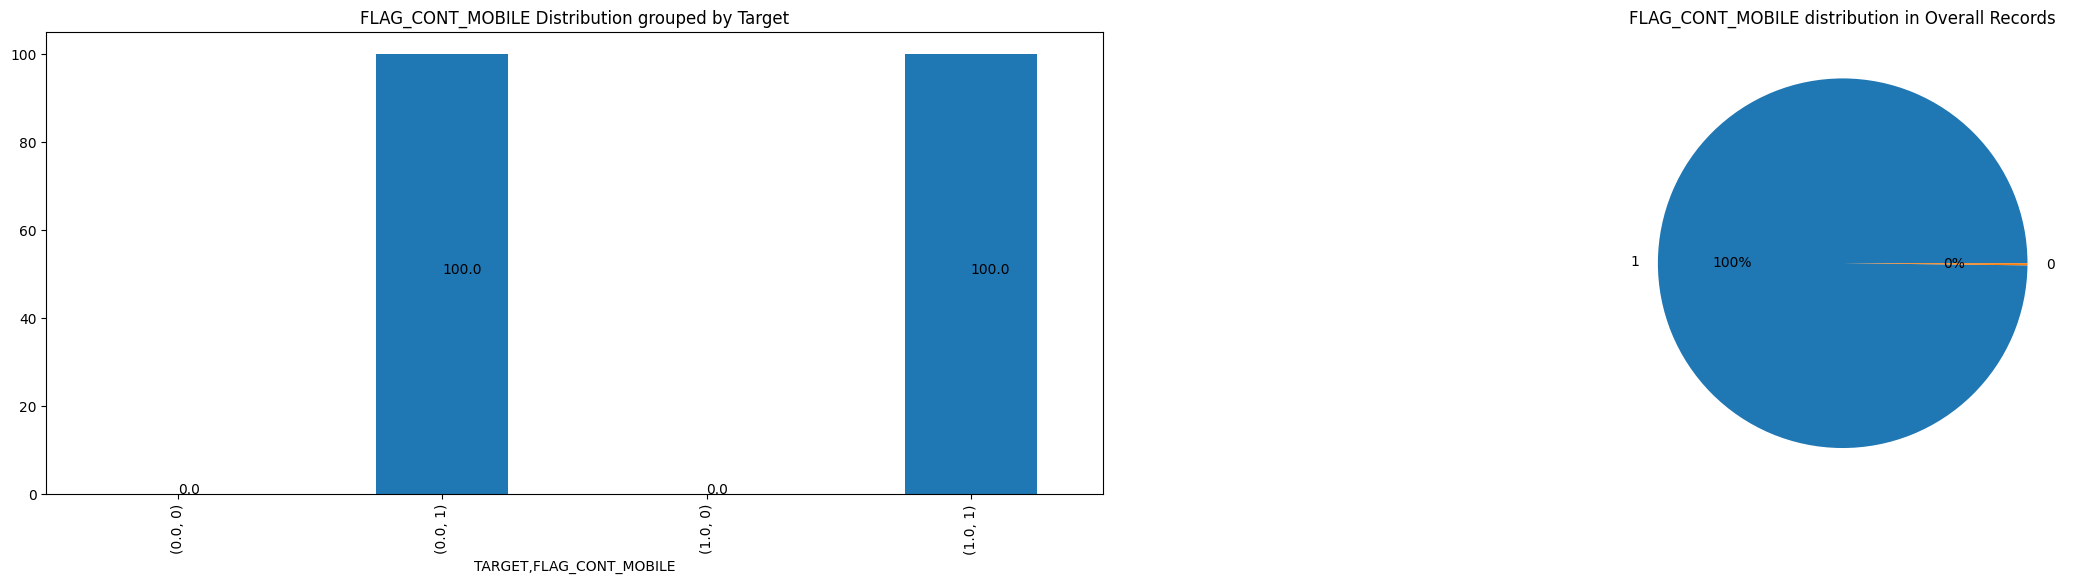

Table View
TARGET  FLAG_CONT_MOBILE
0.0     0                     0.0
        1                   100.0
1.0     0                     0.0
        1                   100.0
Name: proportion, dtype: float64



Distribution Based on FLAG_PHONE
Description :  SK_ID_CURR 



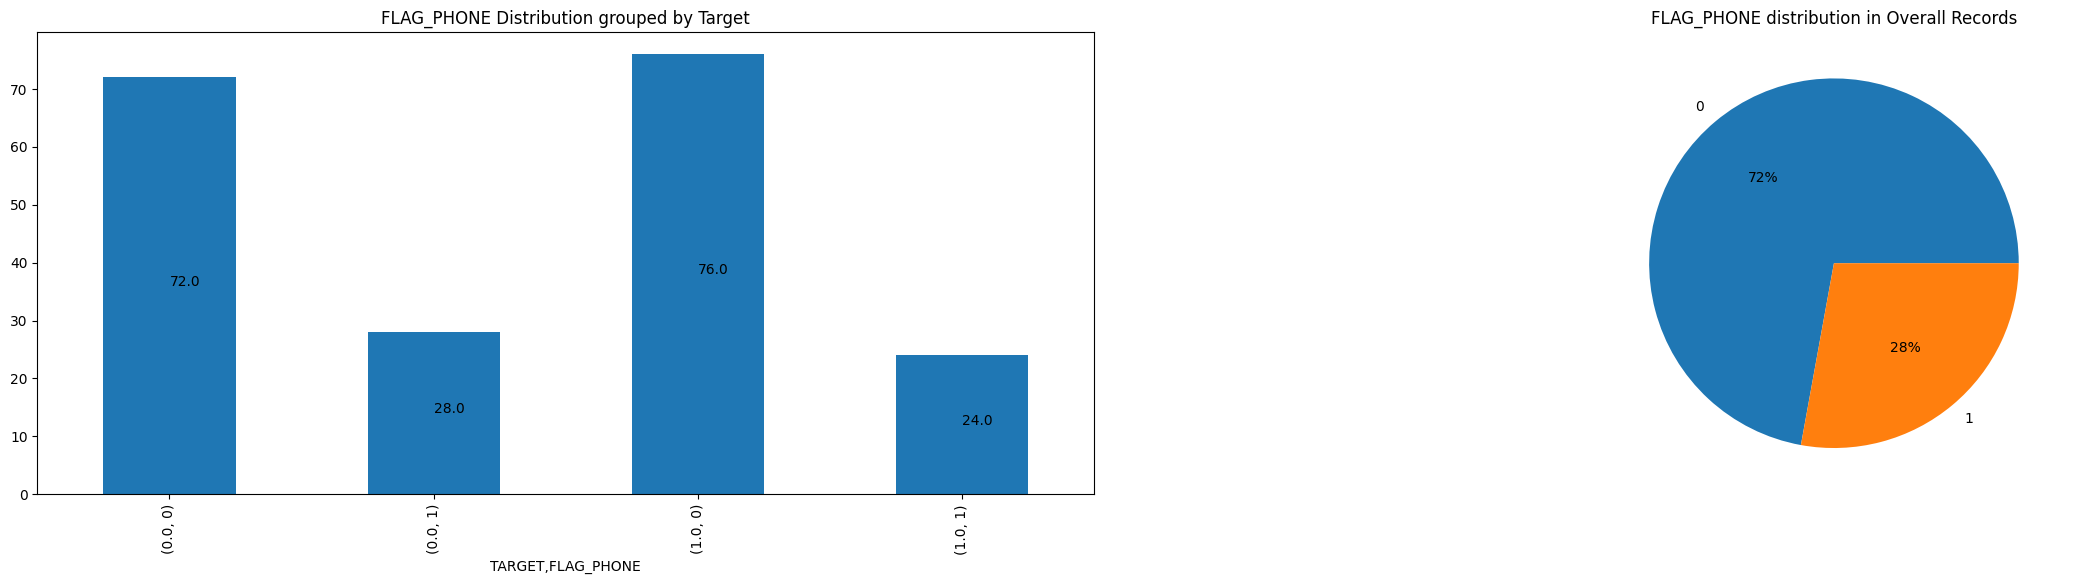

Table View
TARGET  FLAG_PHONE
0.0     0             72.0
        1             28.0
1.0     0             76.0
        1             24.0
Name: proportion, dtype: float64



Distribution Based on FLAG_EMAIL
Description :  SK_ID_CURR 



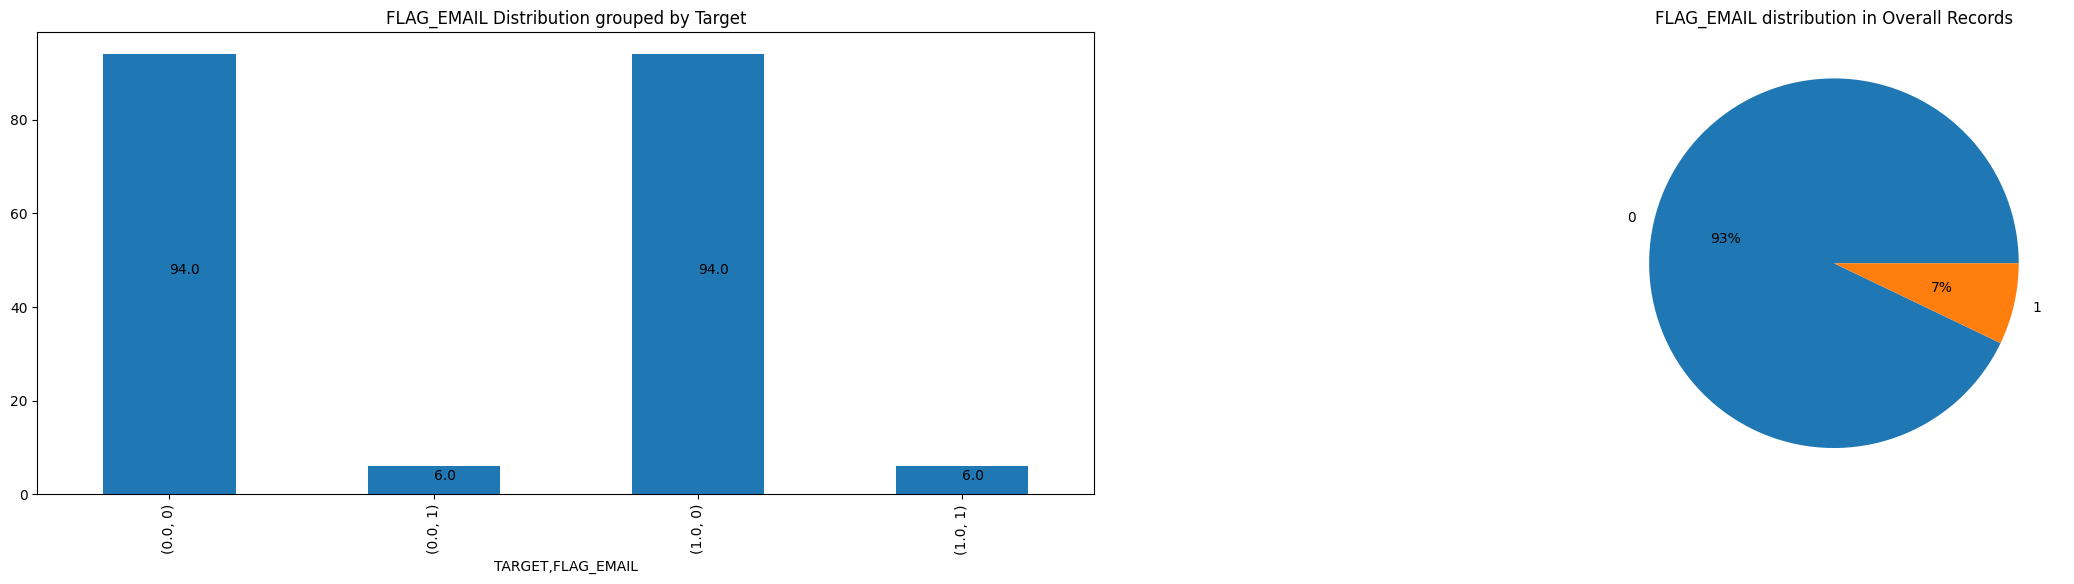

Table View
TARGET  FLAG_EMAIL
0.0     0             94.0
        1              6.0
1.0     0             94.0
        1              6.0
Name: proportion, dtype: float64



Distribution Based on FLAG_DOCUMENT_2
Description :  SK_ID_CURR 



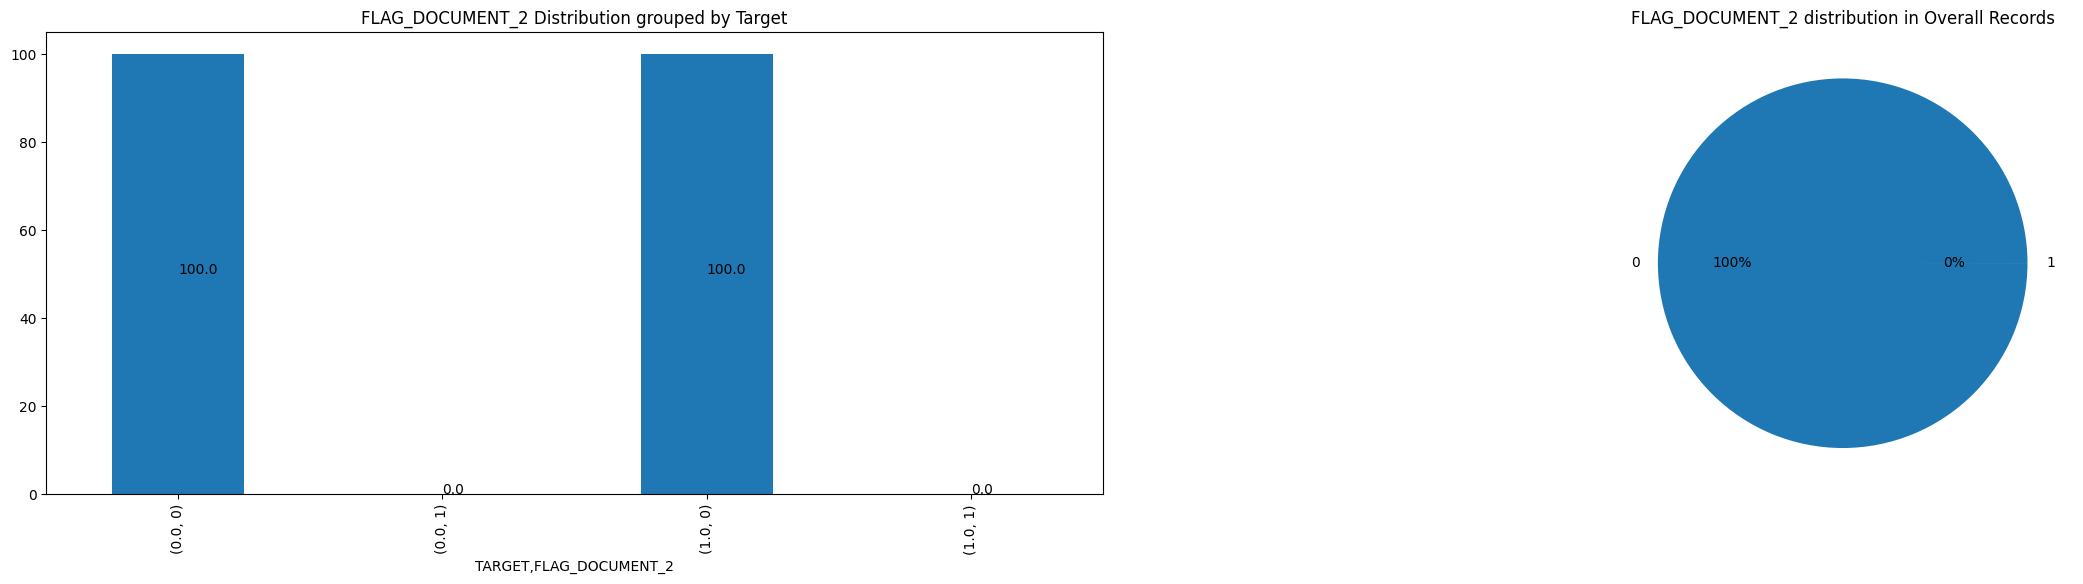

Table View
TARGET  FLAG_DOCUMENT_2
0.0     0                  100.0
        1                    0.0
1.0     0                  100.0
        1                    0.0
Name: proportion, dtype: float64



Distribution Based on FLAG_DOCUMENT_3
Description :  SK_ID_CURR 



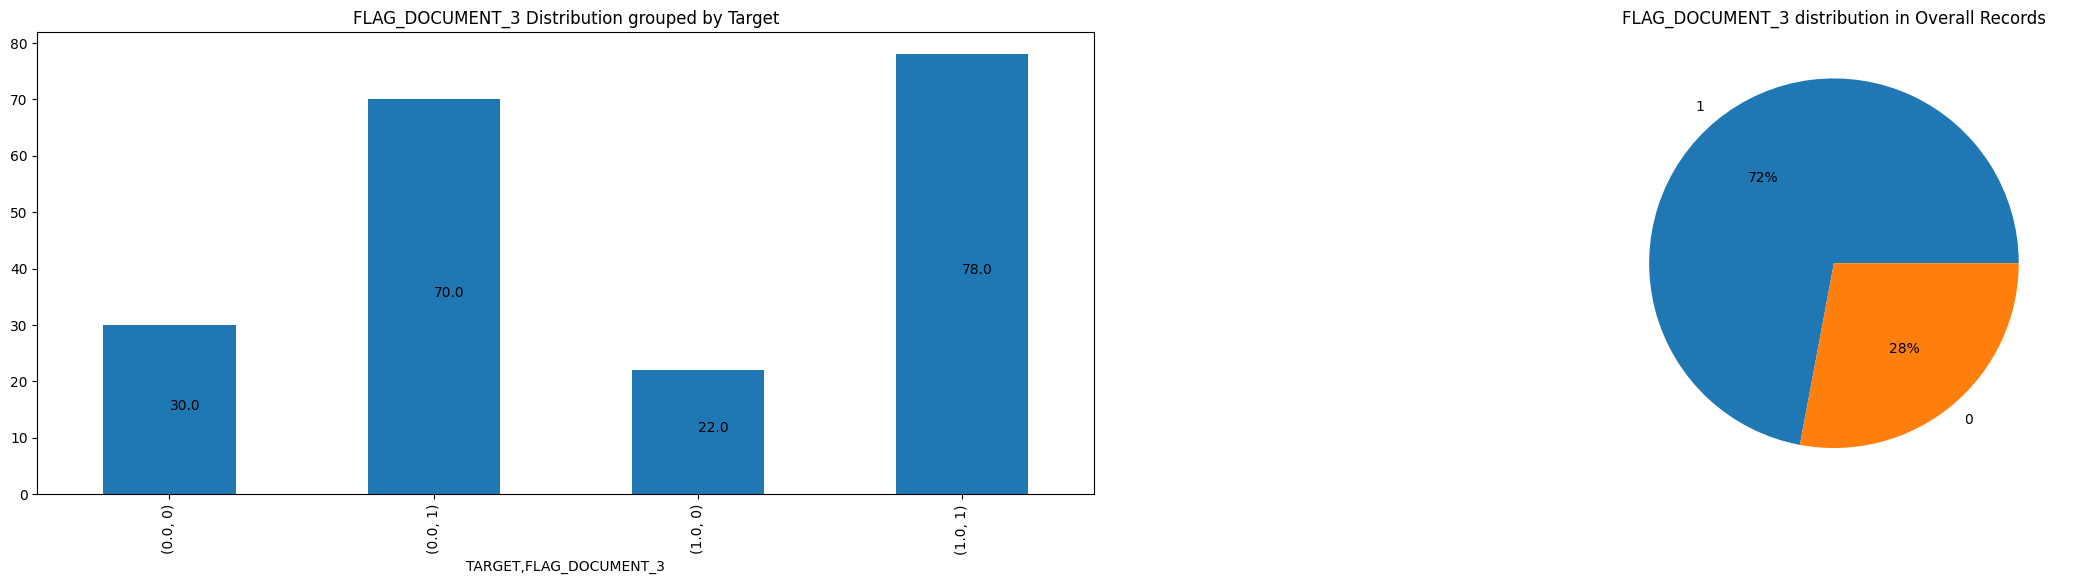

Table View
TARGET  FLAG_DOCUMENT_3
0.0     0                  30.0
        1                  70.0
1.0     0                  22.0
        1                  78.0
Name: proportion, dtype: float64



Distribution Based on FLAG_DOCUMENT_4
Description :  SK_ID_CURR 



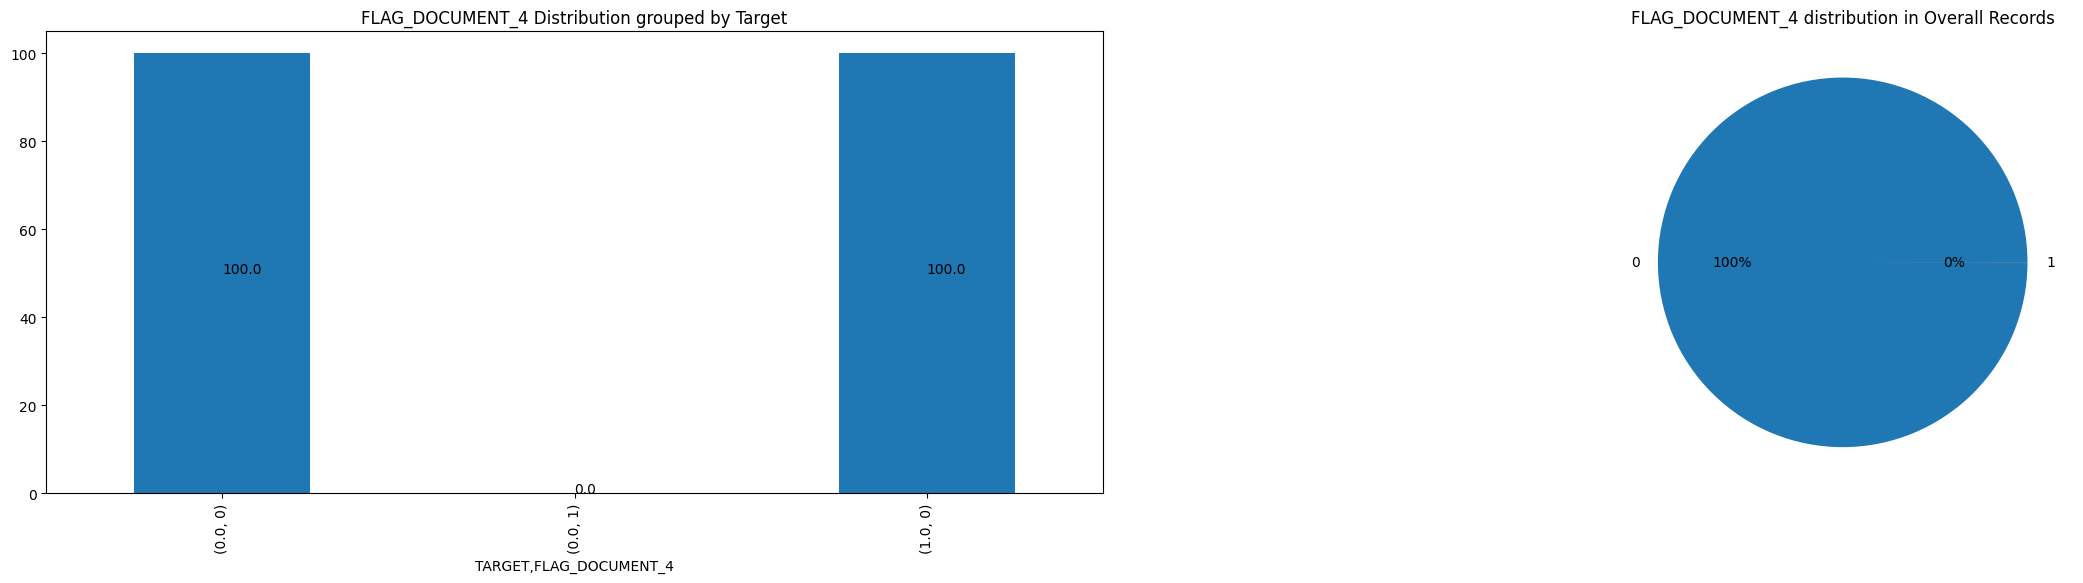

Table View
TARGET  FLAG_DOCUMENT_4
0.0     0                  100.0
        1                    0.0
1.0     0                  100.0
Name: proportion, dtype: float64



Distribution Based on FLAG_DOCUMENT_5
Description :  SK_ID_CURR 



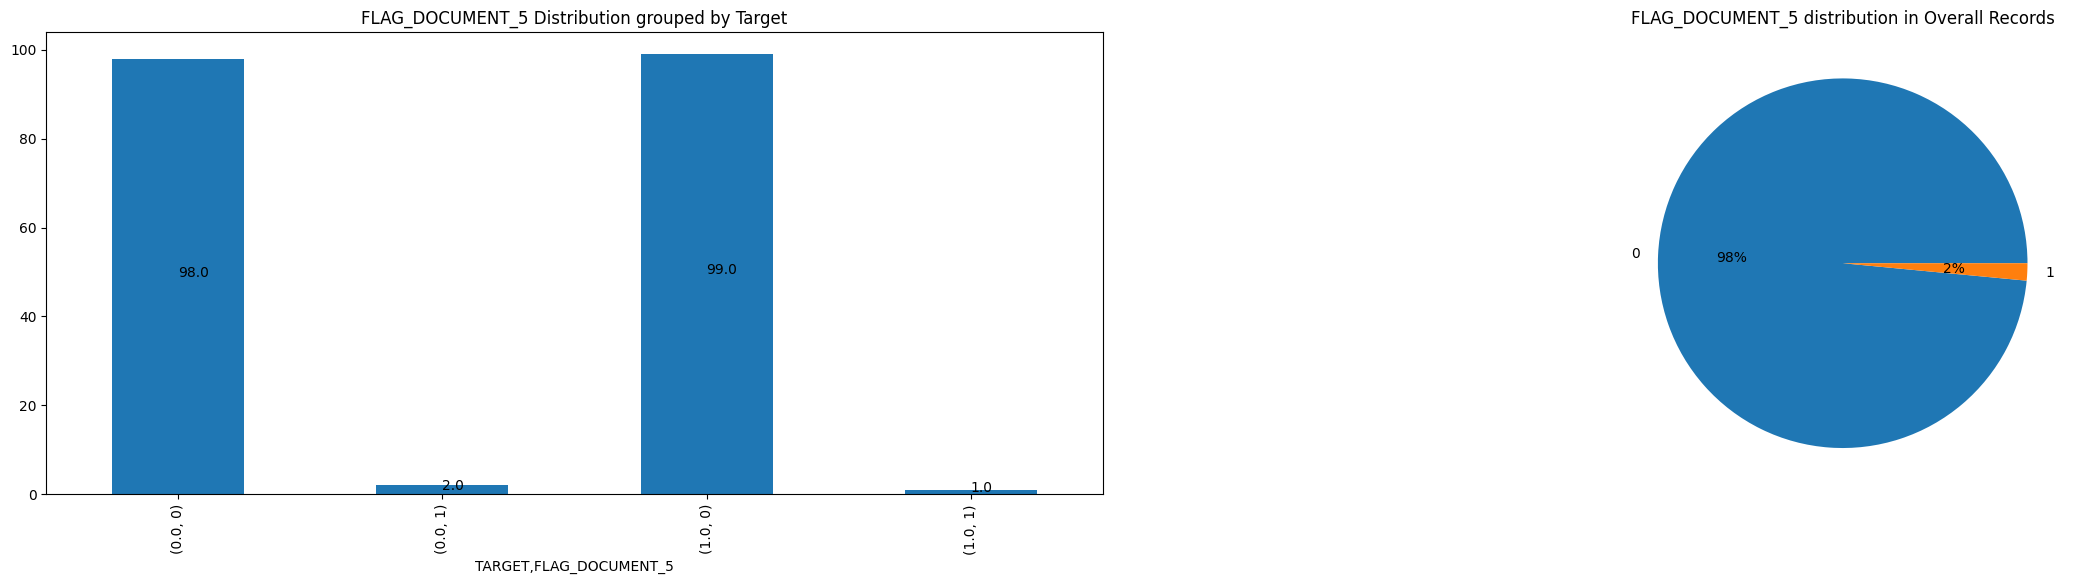

Table View
TARGET  FLAG_DOCUMENT_5
0.0     0                  98.0
        1                   2.0
1.0     0                  99.0
        1                   1.0
Name: proportion, dtype: float64



Distribution Based on FLAG_DOCUMENT_6
Description :  SK_ID_CURR 



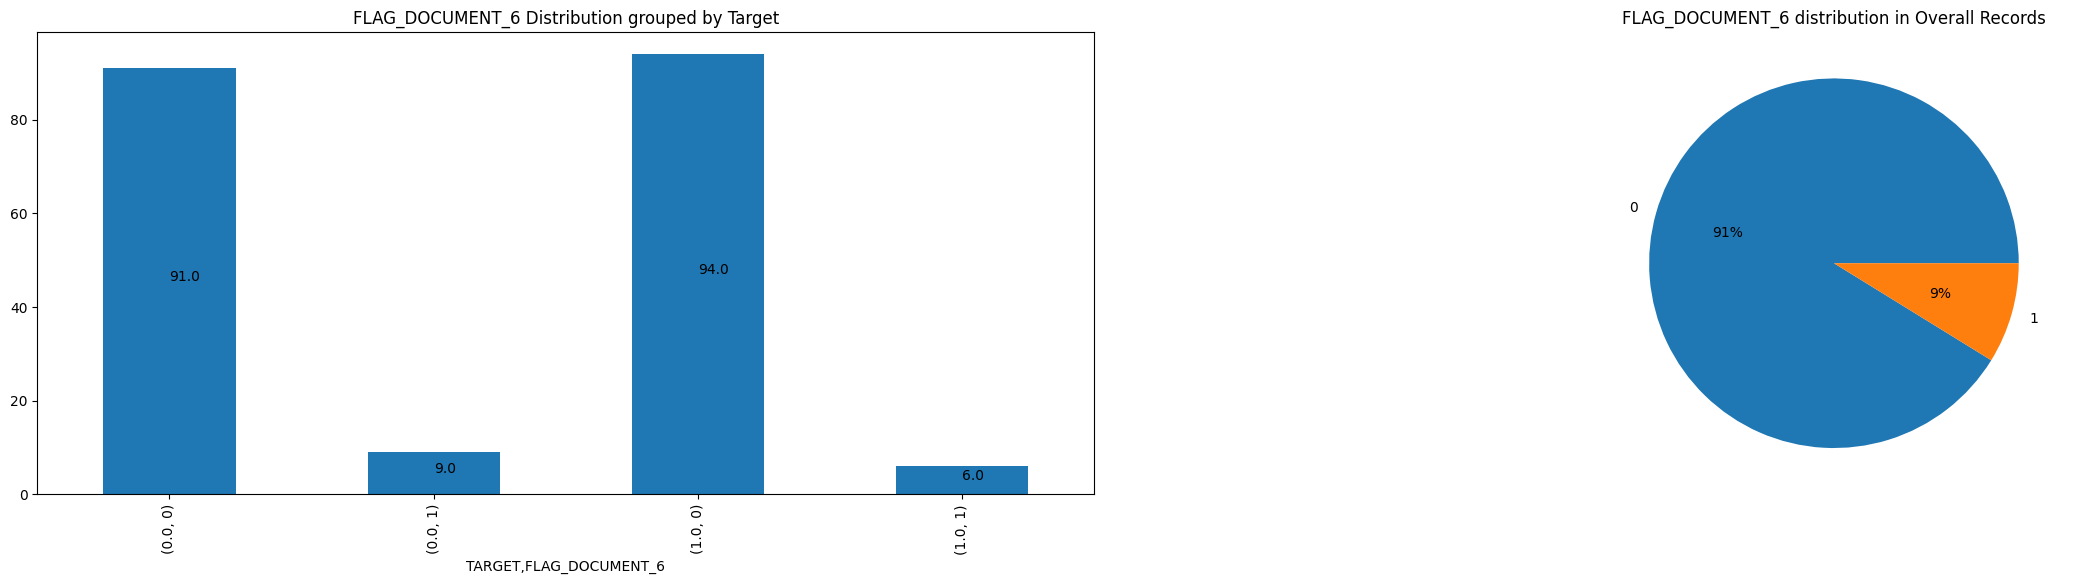

Table View
TARGET  FLAG_DOCUMENT_6
0.0     0                  91.0
        1                   9.0
1.0     0                  94.0
        1                   6.0
Name: proportion, dtype: float64



Distribution Based on FLAG_DOCUMENT_7
Description :  SK_ID_CURR 



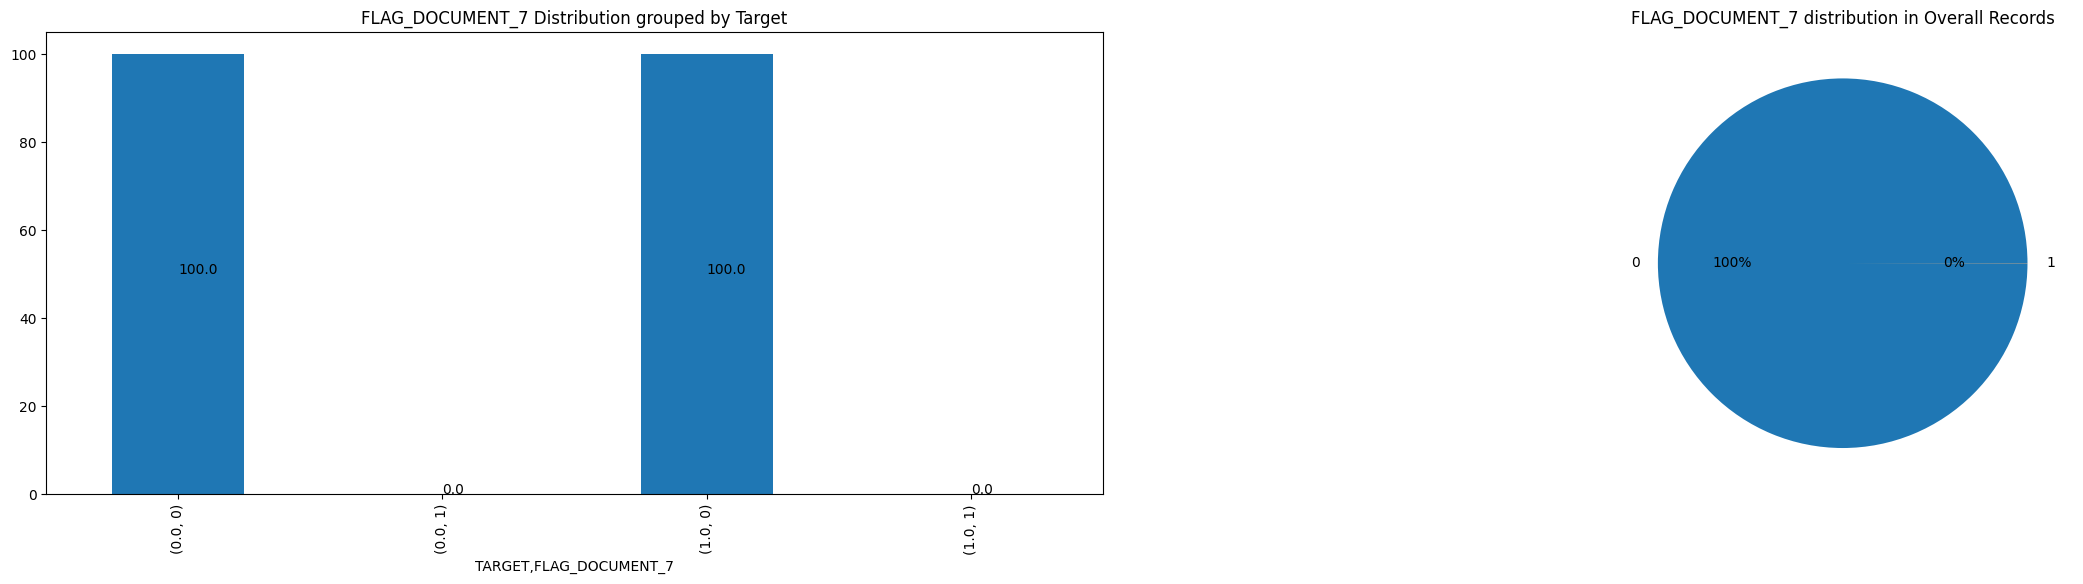

Table View
TARGET  FLAG_DOCUMENT_7
0.0     0                  100.0
        1                    0.0
1.0     0                  100.0
        1                    0.0
Name: proportion, dtype: float64



Distribution Based on FLAG_DOCUMENT_8
Description :  SK_ID_CURR 



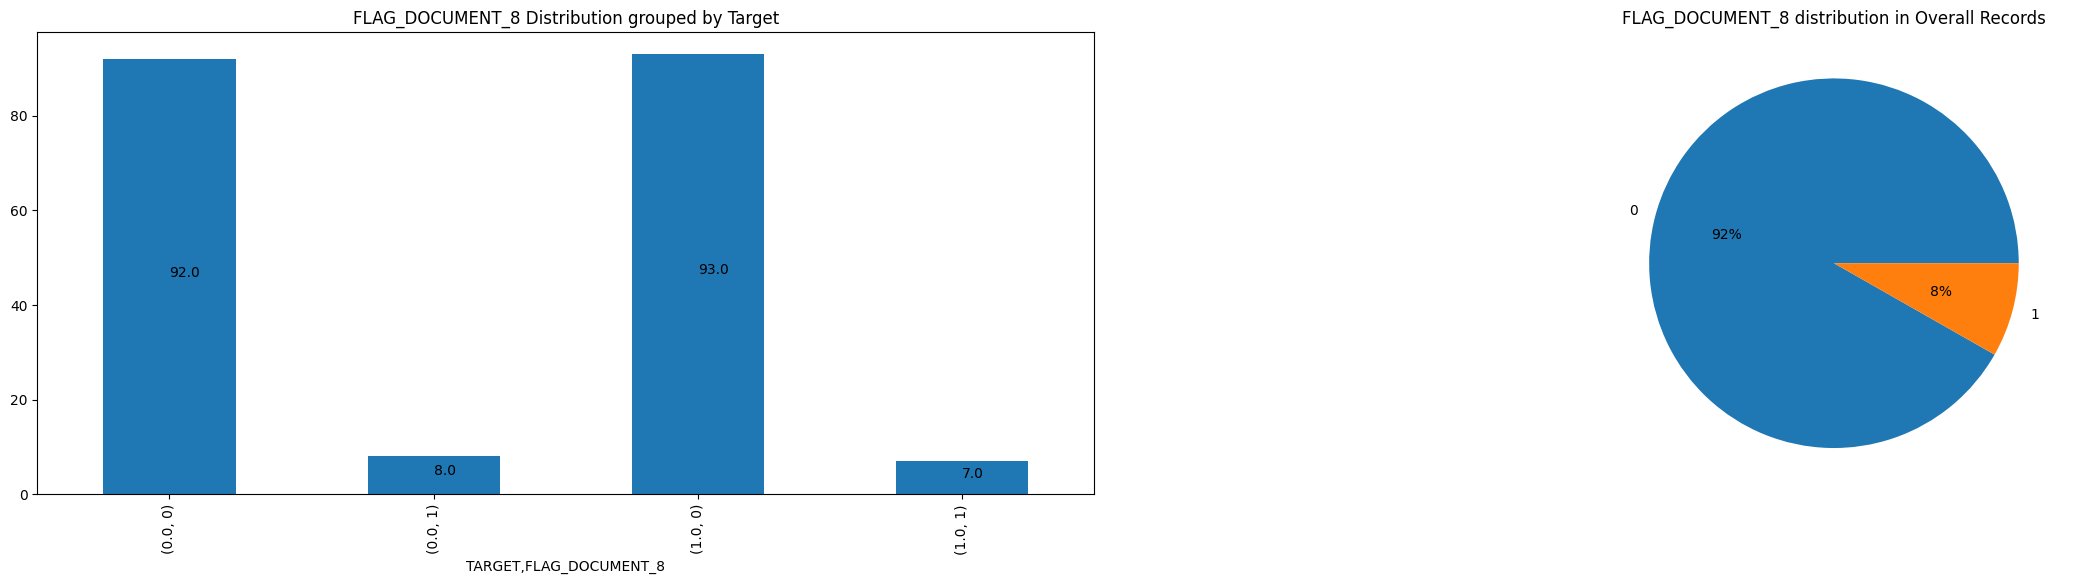

Table View
TARGET  FLAG_DOCUMENT_8
0.0     0                  92.0
        1                   8.0
1.0     0                  93.0
        1                   7.0
Name: proportion, dtype: float64



Distribution Based on FLAG_DOCUMENT_9
Description :  SK_ID_CURR 



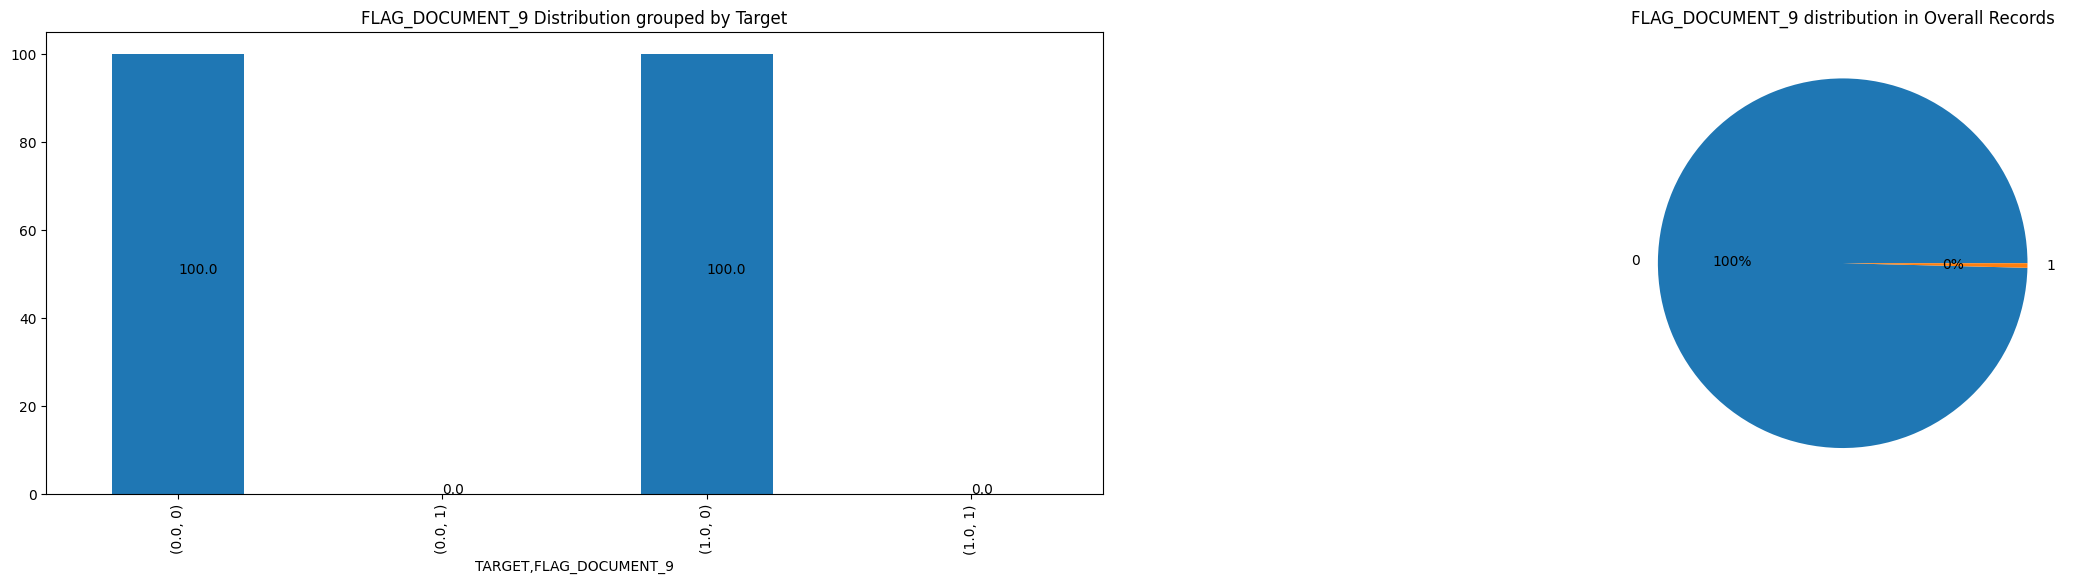

Table View
TARGET  FLAG_DOCUMENT_9
0.0     0                  100.0
        1                    0.0
1.0     0                  100.0
        1                    0.0
Name: proportion, dtype: float64



Distribution Based on FLAG_DOCUMENT_10
Description :  SK_ID_CURR 



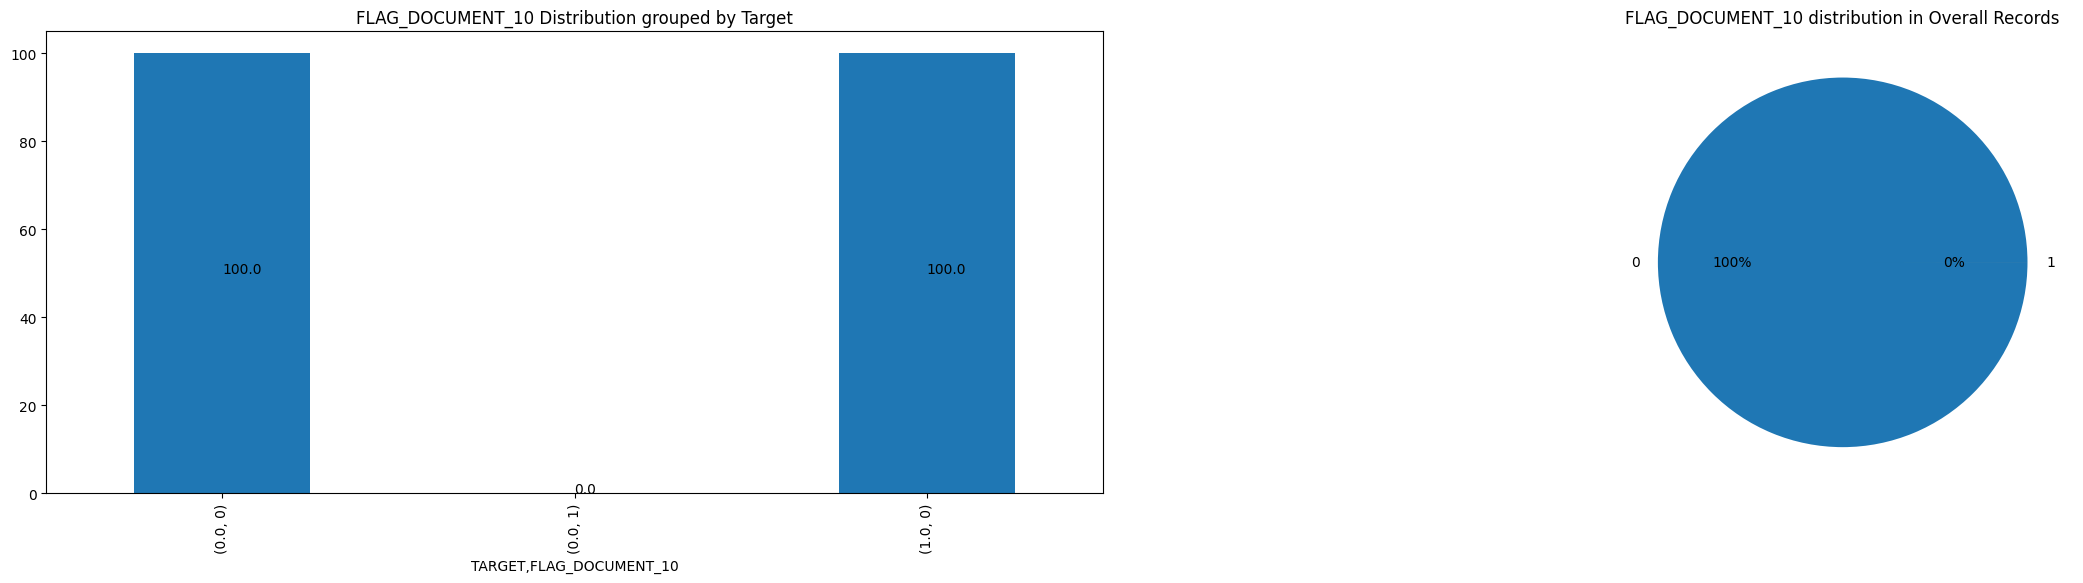

Table View
TARGET  FLAG_DOCUMENT_10
0.0     0                   100.0
        1                     0.0
1.0     0                   100.0
Name: proportion, dtype: float64



Distribution Based on FLAG_DOCUMENT_11
Description :  SK_ID_CURR 



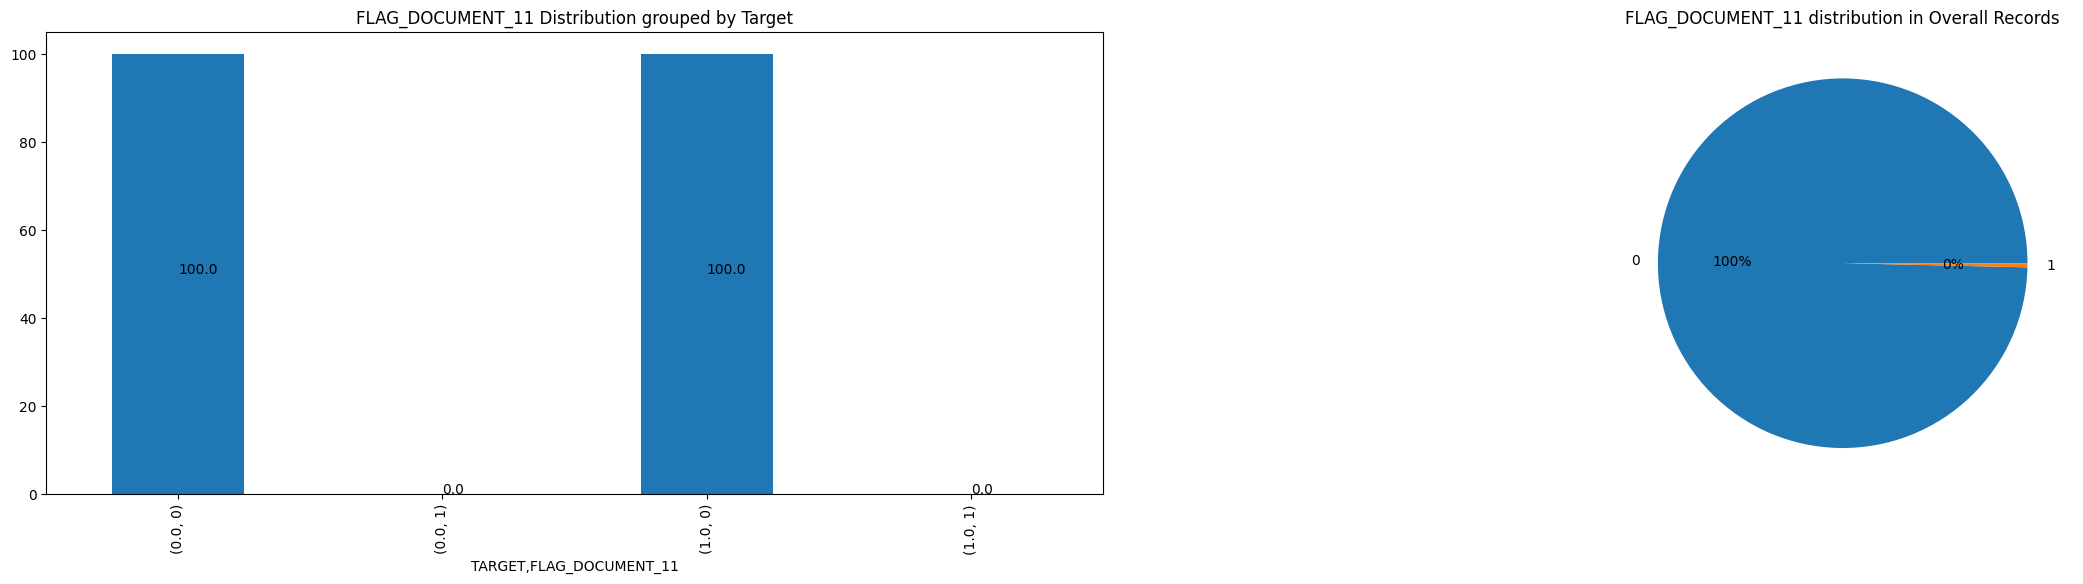

Table View
TARGET  FLAG_DOCUMENT_11
0.0     0                   100.0
        1                     0.0
1.0     0                   100.0
        1                     0.0
Name: proportion, dtype: float64



Distribution Based on FLAG_DOCUMENT_12
Description :  SK_ID_CURR 



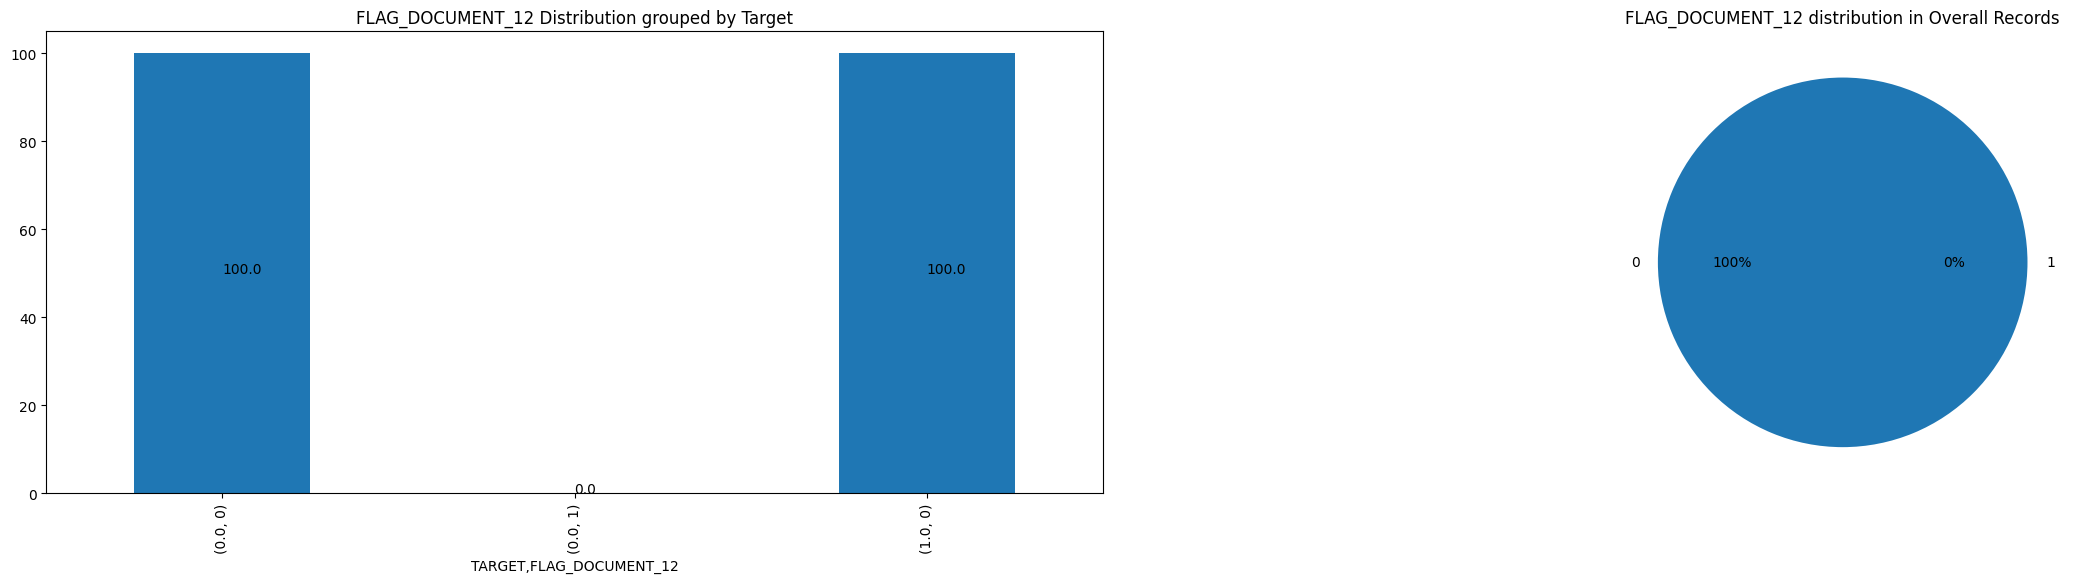

Table View
TARGET  FLAG_DOCUMENT_12
0.0     0                   100.0
        1                     0.0
1.0     0                   100.0
Name: proportion, dtype: float64



Distribution Based on FLAG_DOCUMENT_13
Description :  SK_ID_CURR 



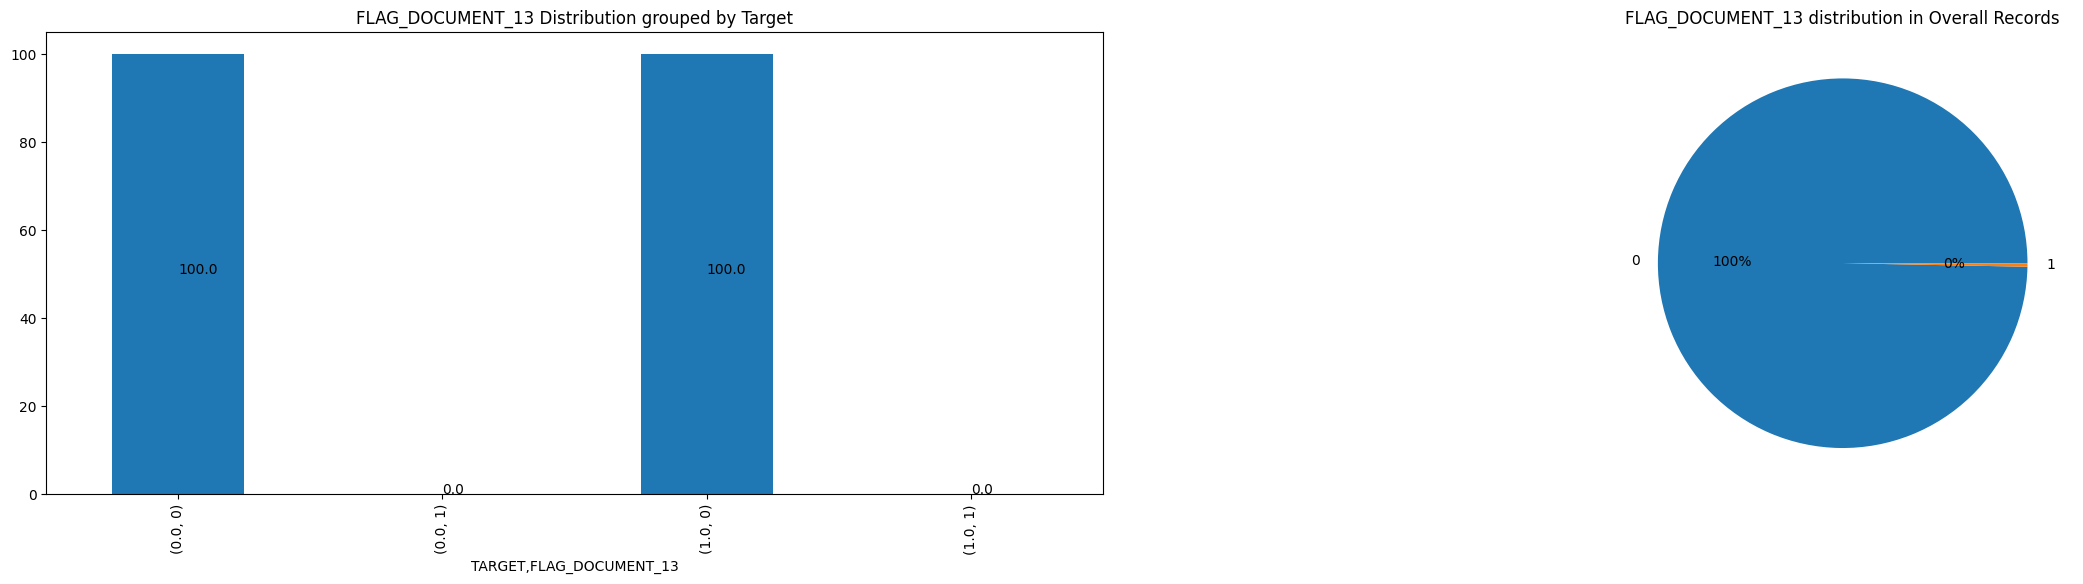

Table View
TARGET  FLAG_DOCUMENT_13
0.0     0                   100.0
        1                     0.0
1.0     0                   100.0
        1                     0.0
Name: proportion, dtype: float64



Distribution Based on FLAG_DOCUMENT_14
Description :  SK_ID_CURR 



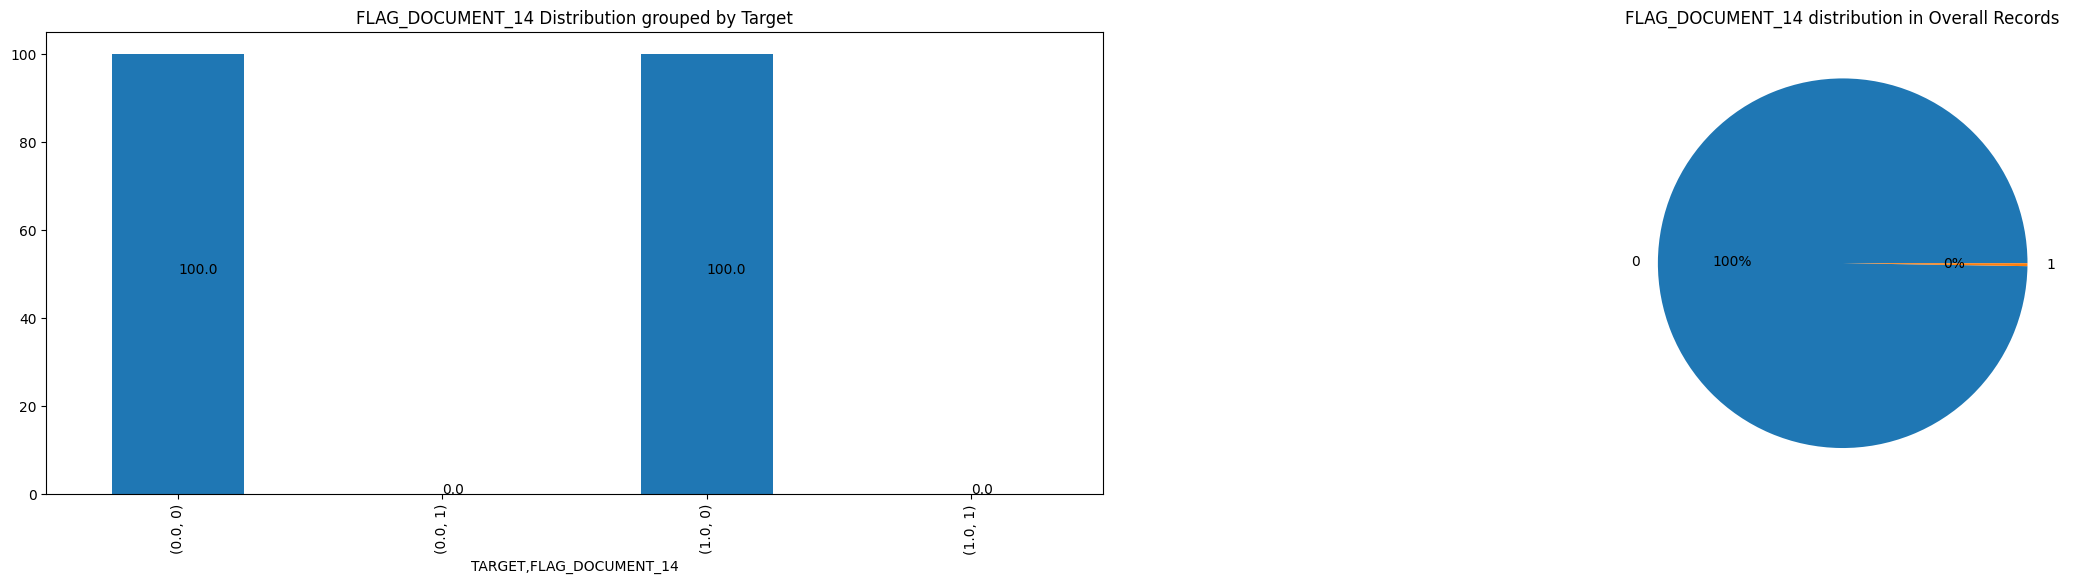

Table View
TARGET  FLAG_DOCUMENT_14
0.0     0                   100.0
        1                     0.0
1.0     0                   100.0
        1                     0.0
Name: proportion, dtype: float64



Distribution Based on FLAG_DOCUMENT_15
Description :  SK_ID_CURR 



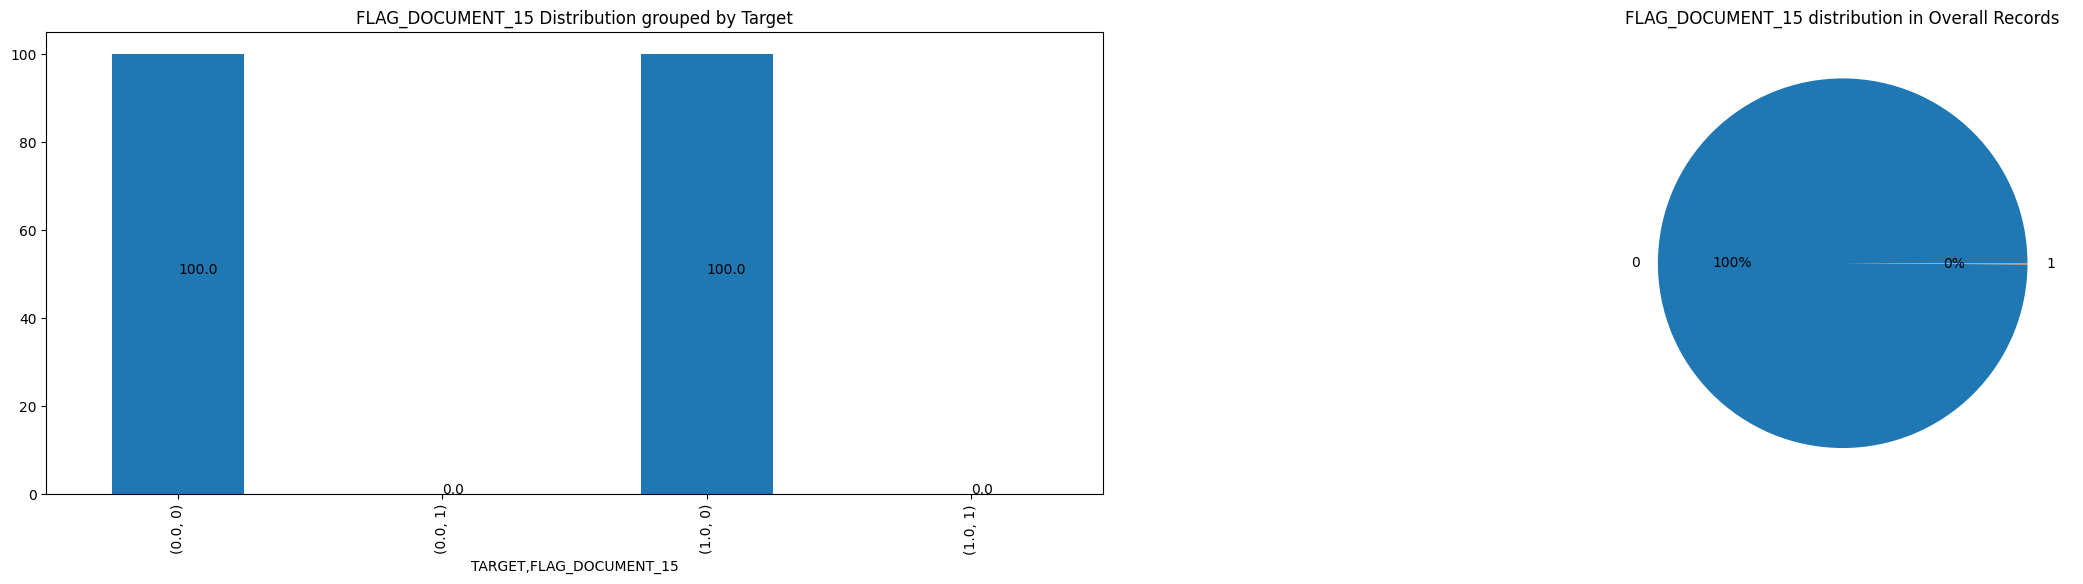

Table View
TARGET  FLAG_DOCUMENT_15
0.0     0                   100.0
        1                     0.0
1.0     0                   100.0
        1                     0.0
Name: proportion, dtype: float64



Distribution Based on FLAG_DOCUMENT_16
Description :  SK_ID_CURR 



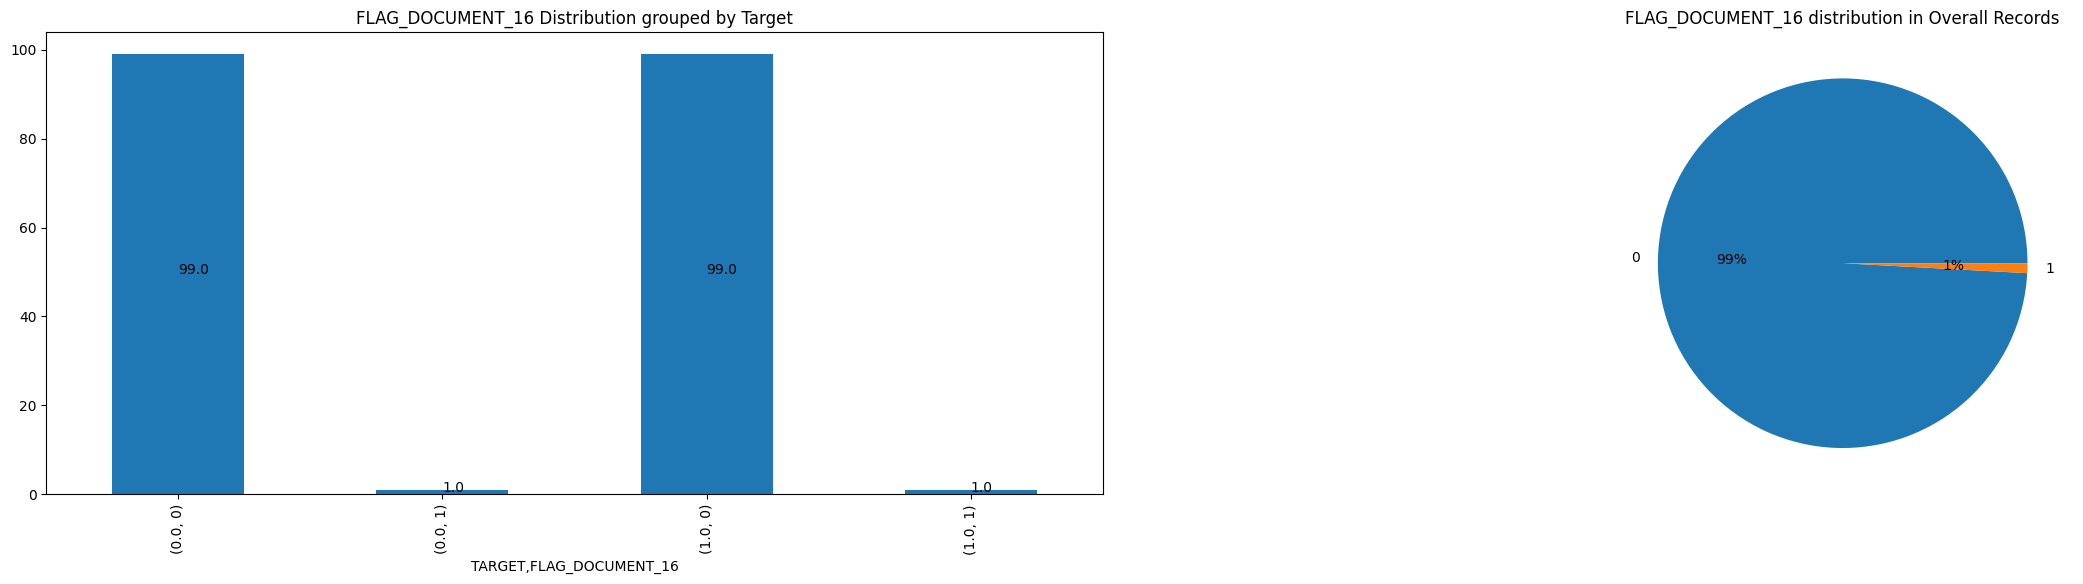

Table View
TARGET  FLAG_DOCUMENT_16
0.0     0                   99.0
        1                    1.0
1.0     0                   99.0
        1                    1.0
Name: proportion, dtype: float64



Distribution Based on FLAG_DOCUMENT_17
Description :  SK_ID_CURR 



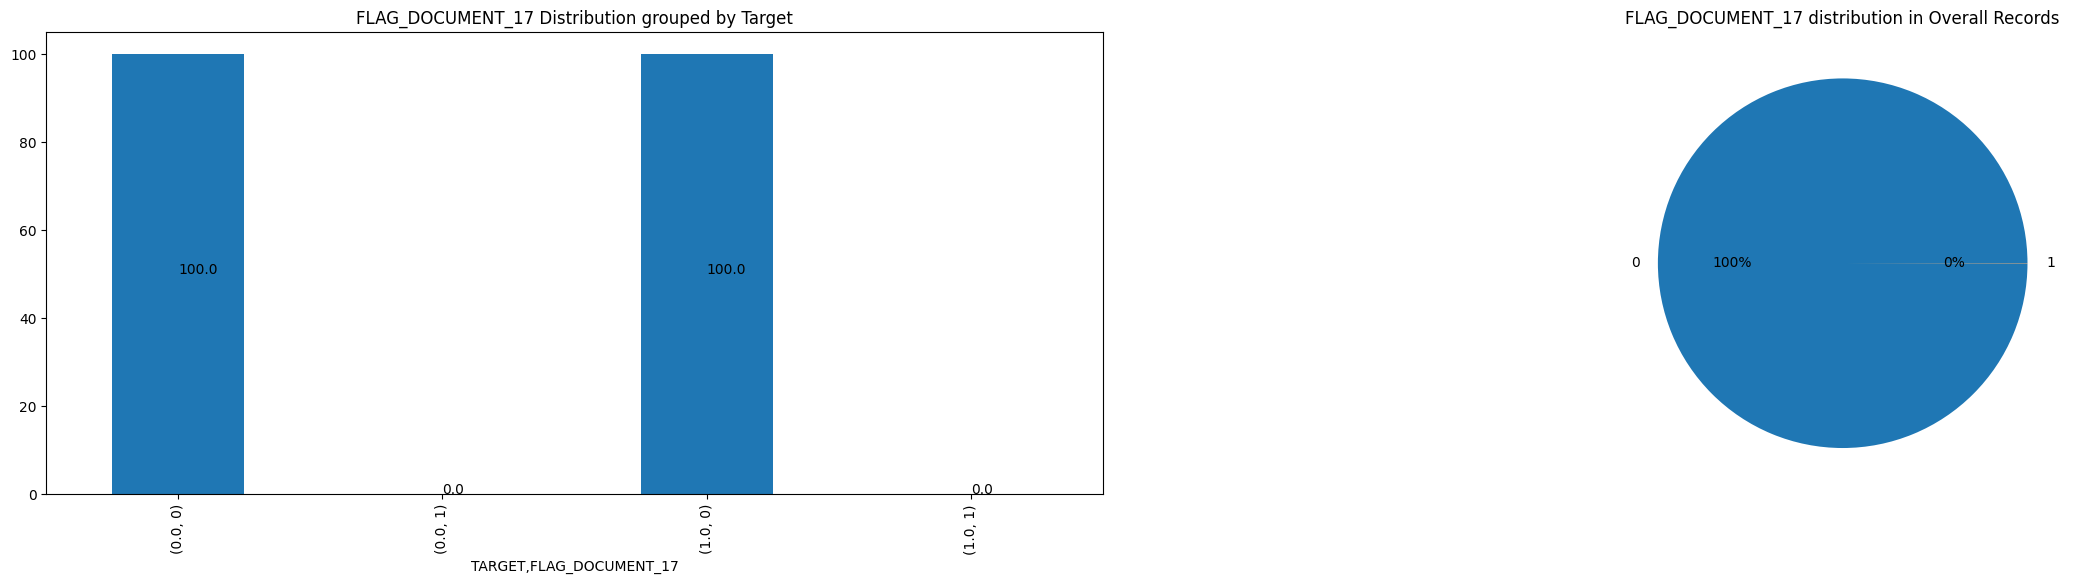

Table View
TARGET  FLAG_DOCUMENT_17
0.0     0                   100.0
        1                     0.0
1.0     0                   100.0
        1                     0.0
Name: proportion, dtype: float64



Distribution Based on FLAG_DOCUMENT_18
Description :  SK_ID_CURR 



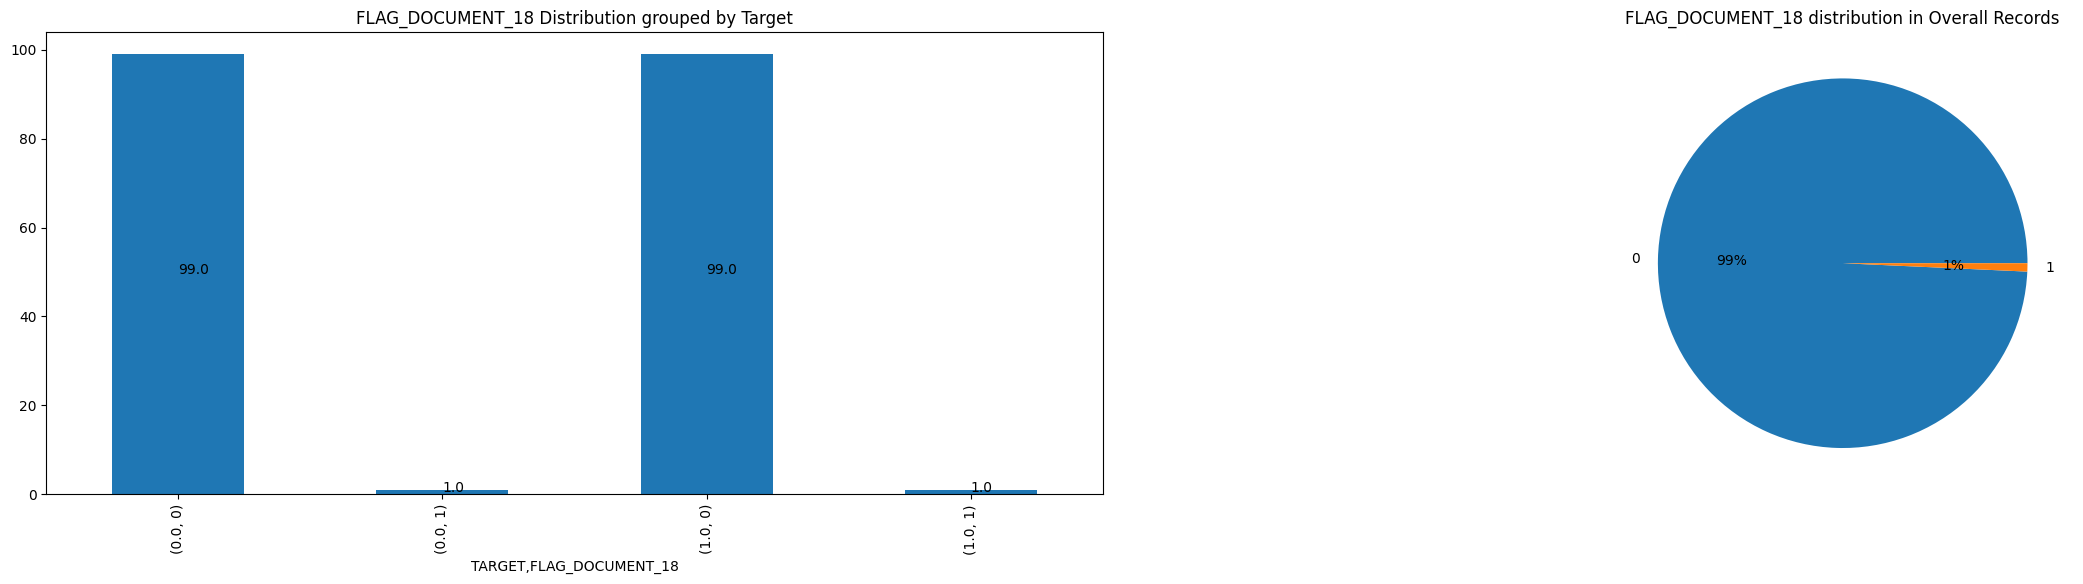

Table View
TARGET  FLAG_DOCUMENT_18
0.0     0                   99.0
        1                    1.0
1.0     0                   99.0
        1                    1.0
Name: proportion, dtype: float64



Distribution Based on FLAG_DOCUMENT_19
Description :  SK_ID_CURR 



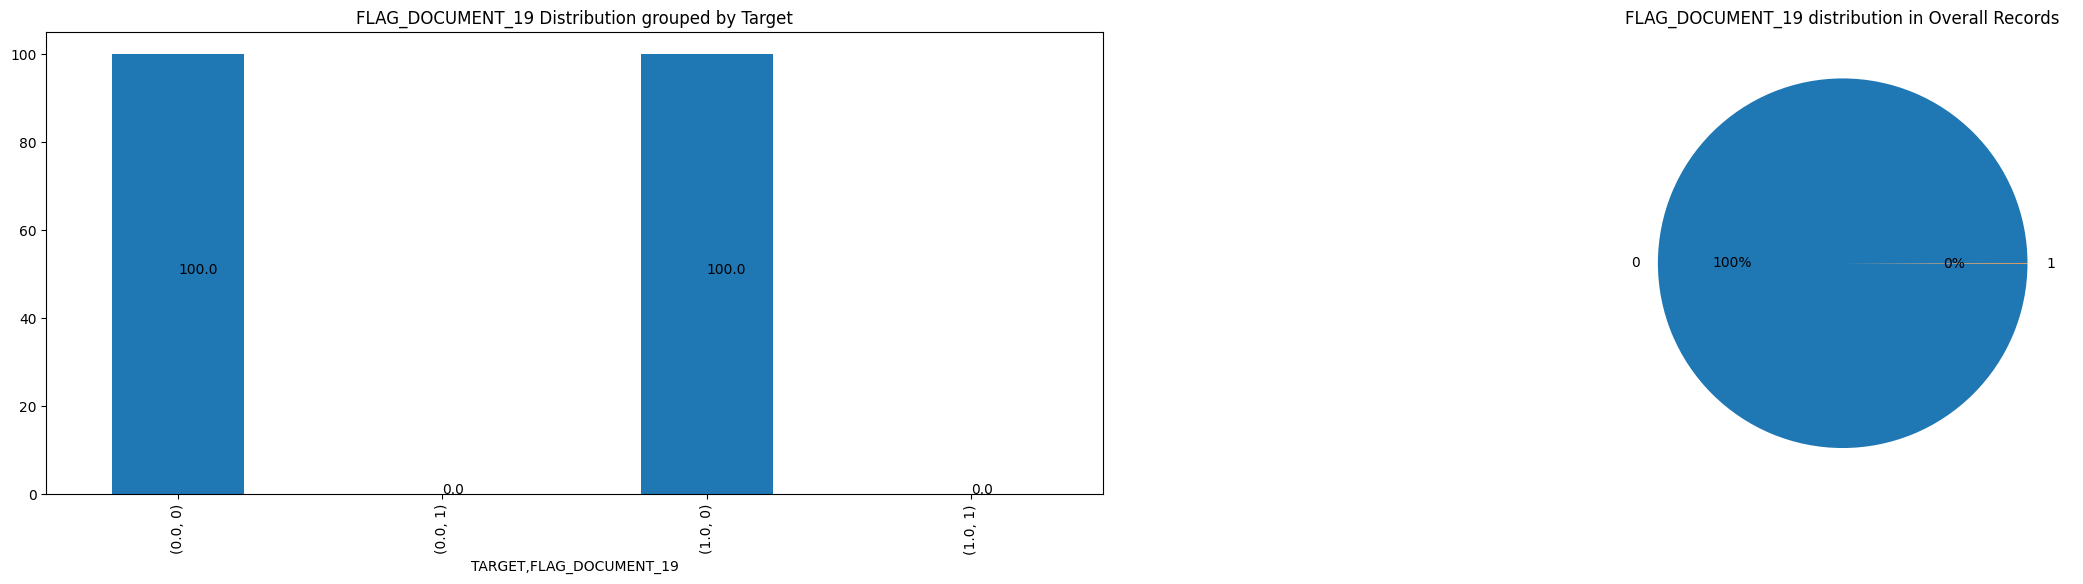

Table View
TARGET  FLAG_DOCUMENT_19
0.0     0                   100.0
        1                     0.0
1.0     0                   100.0
        1                     0.0
Name: proportion, dtype: float64



Distribution Based on FLAG_DOCUMENT_20
Description :  SK_ID_CURR 



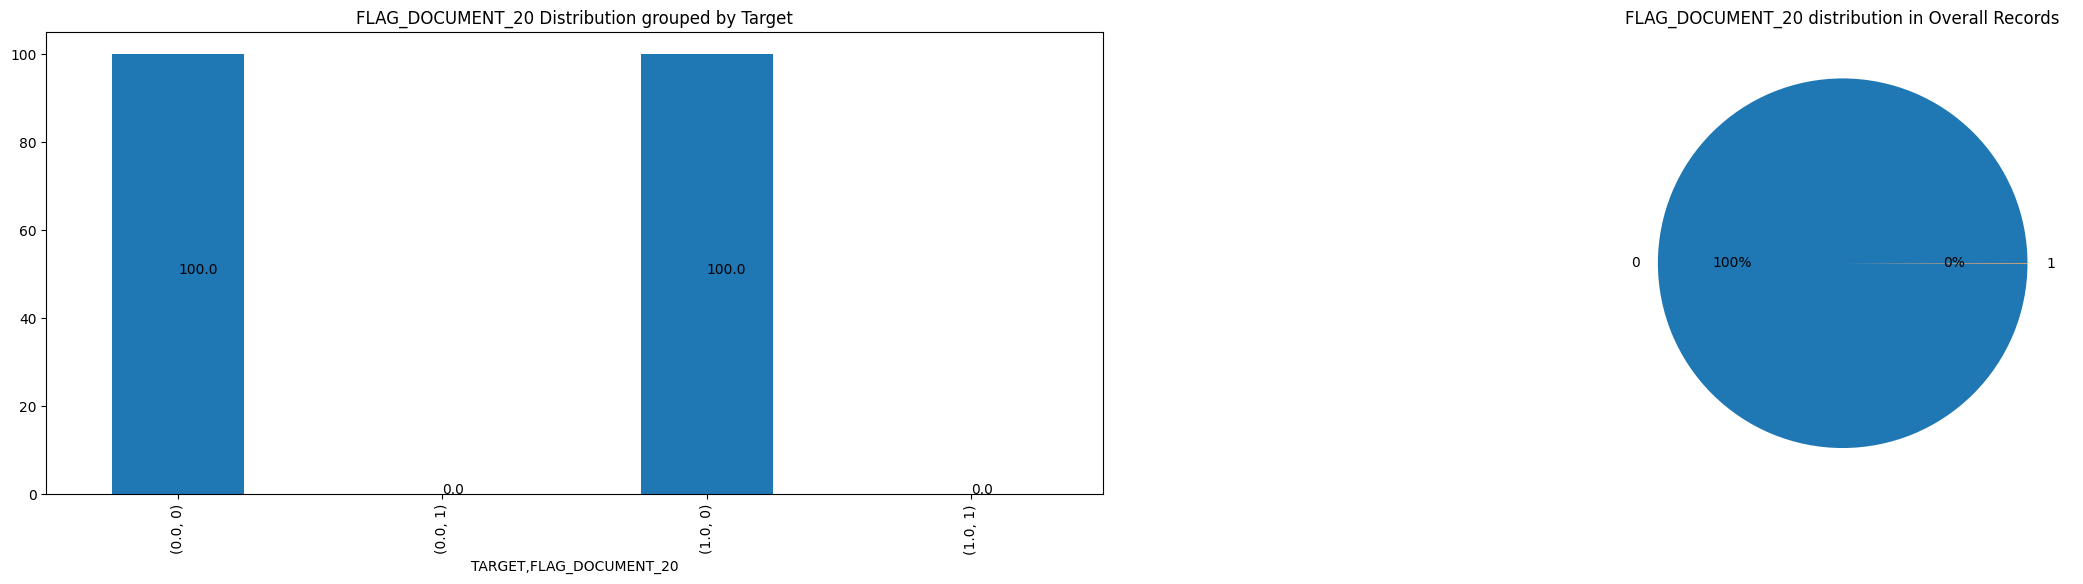

Table View
TARGET  FLAG_DOCUMENT_20
0.0     0                   100.0
        1                     0.0
1.0     0                   100.0
        1                     0.0
Name: proportion, dtype: float64



Distribution Based on FLAG_DOCUMENT_21
Description :  SK_ID_CURR 



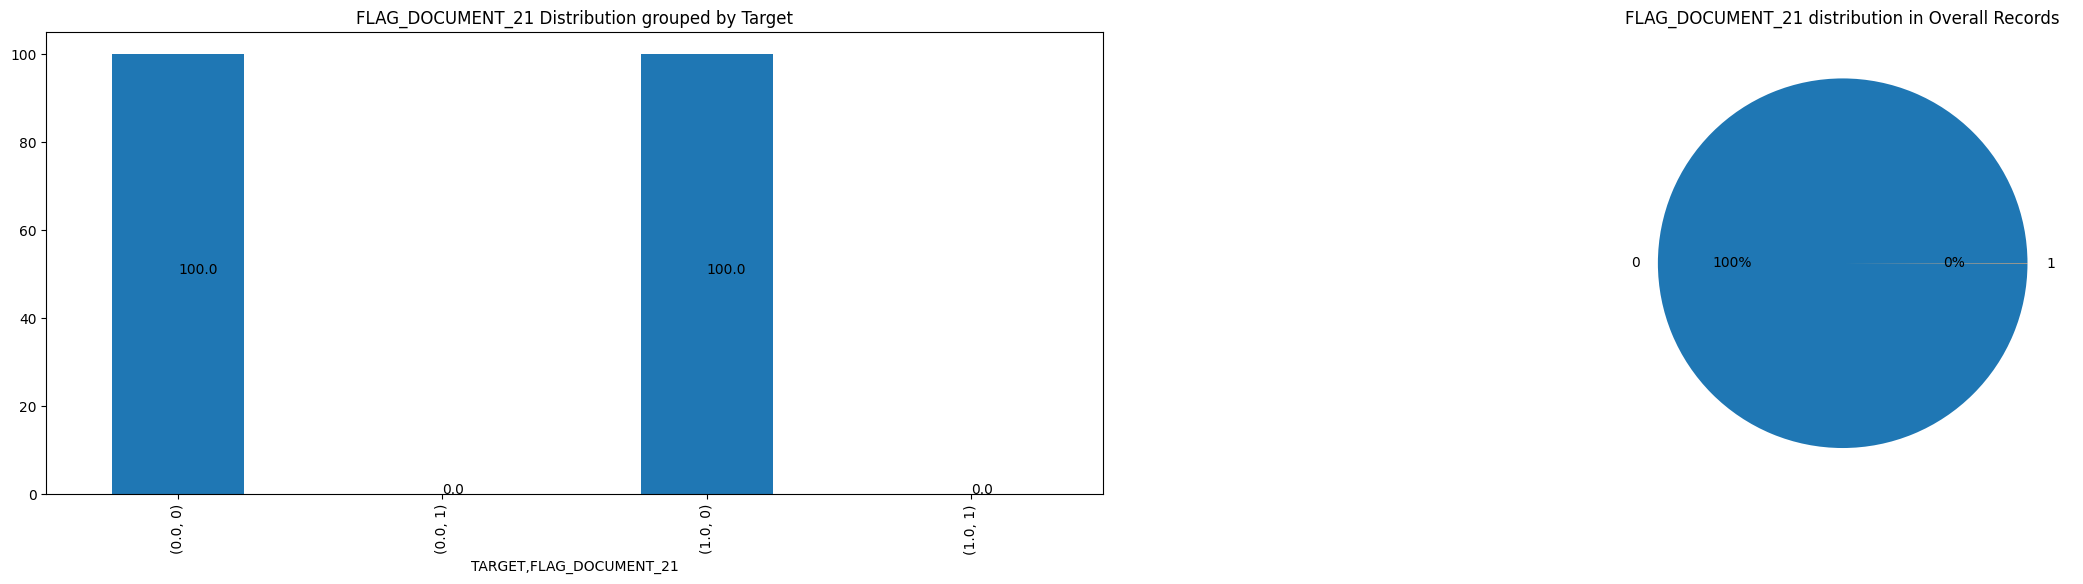

Table View
TARGET  FLAG_DOCUMENT_21
0.0     0                   100.0
        1                     0.0
1.0     0                   100.0
        1                     0.0
Name: proportion, dtype: float64





In [34]:

# =============================================================================
# NUMERICAL ANALYSIS
# =============================================================================
##REMOVING THE COLUMNS WITH NAME STARTING WITH"FLAG"
#Creating list of Flag columns and removing from numeric columns
data_numeric_cols = list(Current_data_Numericonly)
data_flag_cols = [val for val in data_numeric_cols if 'FLAG_' in val]

# remove flags from numeric cols
for val in data_flag_cols:
    data_numeric_cols.remove(val)

data_numeric_cols

#REMOVING ALSO REGION AND CITY FROM NUMERIC
data_area_cols = [val for val in data_numeric_cols if ('REGION_' in val or 'CITY_' in val )]

for val in data_area_cols:
    data_numeric_cols.remove(val)
data_numeric_cols

#REMOVING HOUR AND MINUTE
data_days_cols = [val for val in data_numeric_cols if ('DAYS_' in val or 'HOUR_' in val )]

for val in data_days_cols:
    data_numeric_cols.remove(val)
data_numeric_cols



#REMOVING ALL COLUMNS RELATED TO AMOUNT
data_amt_cols = [val for val in data_numeric_cols if 'AMT_' in val]

for val in data_amt_cols:
    data_numeric_cols.remove(val)

#LISTING THE VARIABLES DELETED FROM OUR NUMERICAL COLUMN
print('Numeric cols',len(data_numeric_cols))
print('Area cols',len(data_area_cols))
print('Flag cols',len(data_flag_cols))
print('Days cols',len(data_days_cols))
print('Amount cols',len(data_amt_cols))

#REMOVING THE TARGET AND CONSUMER ID 
#list(data_numeric_cols).remove('SK_ID_CURR')
data_numeric_cols.remove('TARGET')

# Let's see how values are distributed in numeric cols
current_data_info = round(current_data[data_numeric_cols+data_amt_cols+data_days_cols].describe().T,2)
current_data_info['description'] = current_data_info.index.map(lambda x: columns_data[(columns_data == 'application_data') & (columns_data == x)])
current_data_info

# We have verified the distribution during the data cleaning stage. We'll create a function now to visualize the distribution of numeric values

def numericDistributionGraph(col):
    print("\033[1m\033[1;3mDistribution Based on "+str(col)+"\033[0m")
    print('Description : ',columns_data[(columns_data == 'application_data') & (columns_data == col)])
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(1,3,1)
    sns.histplot(current_data[col], bins=10, color='#222831')
    plt.title('Distribution of '+col+' Across current application', fontsize=8)
    
    plt.subplot(1,3,2)
    sns.boxplot(x='TARGET', y=col ,data=current_data,)
    plt.title('Distribution of '+col+' with respect to TARGET feature', fontsize=8)
    
    plt.subplot(1,3,3)
    sns.boxplot(x=current_data[col],color='#F38181')
    plt.title('Distribution of '+col+' quantile Across current application', fontsize=8)
    


for col in data_numeric_cols[2:3]:
    numericDistributionGraph(col)


# =============================================================================
#EXERCISE:
#    Use new features and make your analysis. 
# 
# =============================================================================

##Example of specific variables: Income external sources
def distGraphs(x):
    print("\033[1m\033[1;3mDistribution Based on "+str(x)+"\033[0m")
    print('Description : ',columns_data[(columns_data == 'current_data') & (columns_data == x)],'\n')
    
    #Create a normalized value count converted to percentage
    target_group = round(file.groupby('TARGET')[x].value_counts(normalize=True,sort=False)*100)
    
    plt.figure(figsize=(30,6))
    
    plt.subplot(121)
    plt.title(str(x)+' Distribution grouped by Target')
    ax = target_group.plot(kind='bar')
    
    for bar in ax.patches:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height()/2, str(bar.get_height()))
    
    plt.subplot(122)
    plt.title(str(x)+' distribution in Overall Records')
    (current_data[x].value_counts(normalize=True)*100).plot(kind='pie', autopct = "%1.0f%%")
    plt.ylabel(' ')

    plt.show()
    
    print("\033[1m\033[1;3mTable View\033[0m")
    print(target_group)
    print("\n\n")

plt.figure(figsize=(18,10))

plt.subplot(1,3,1)
sns.boxplot(x='TARGET', y='EXT_SOURCE_1' ,data=current_data,)
plt.title('Distribution of EXT_SOURCE_1 with respect to TARGET feature')

plt.subplot(1,3,2)
sns.boxplot(x='TARGET', y='EXT_SOURCE_2' ,data=current_data,)
plt.title('Distribution of EXT_SOURCE_2 with respect to TARGET feature')


plt.subplot(1,3,3)
sns.boxplot(x='TARGET', y='EXT_SOURCE_3' ,data=current_data,)
plt.title('Distribution of EXT_SOURCE_3 with respect to TARGET feature')

plt.show()

for col in data_flag_cols:
    distGraphs(col)

